# Tutorial 3: Try several models and initial conditions

In [1]:
import sys
import cmath
import math
import os

if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *

from libra_py import units
import libra_py.models.Holstein as Holstein
from libra_py import tsh
from libra_py import tsh_stat
from libra_py import data_conv
from libra_py import dynamics_hdf5
from libra_py import dynamics_plotting
from libra_py import dynamics_exact
import util.libutil as comn
import time


import h5py
import matplotlib.pyplot as plt   # plots
import numpy as np
#from matplotlib.mlab import griddata
%matplotlib inline 

plt.rc('axes', titlesize=24)      # fontsize of the axes title
plt.rc('axes', labelsize=20)      # fontsize of the x and y labels
plt.rc('legend', fontsize=20)     # legend fontsize
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

colors = {}

colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   

colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      

colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  

colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]

/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::complex<double>, std::allocator<std::complex<double> > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, s

## 1. Define the model & plot the PES

In [2]:
def compute_model(q, params, full_id):

    model = params["model"]
    res = None
    
    if model==1:
        #res = test1(q, params, full_id)
        res = Holstein.Holstein2(q, params, full_id)
    elif model==2:
        pass

    return res


def potential(q, params):
    """
    Thin wrapper of the model Hamiltonians that can be used in 
    the fully-quantum calculations
    """

    # Diabatic properties
    obj = compute_model(q, params, Py2Cpp_int([0,0]))
    
    # Adiabatic properties
    nadi = len(params["E_n"])
    ndof = 1
    ham = nHamiltonian(nadi, nadi, ndof) # ndia, nadi, nnucl
    ham.init_all(2)
        

    ham.compute_diabatic(compute_model, q, params)    
    ham.compute_adiabatic(1);   
    
    
    obj.ham_adi = ham.get_ham_adi()    
    obj.dc1_adi = CMATRIXList() 
    
    for n in range(ndof):    
        x = ham.get_dc1_adi(n)
        for i in range(nadi):
            for j in range(nadi):
                if i!=j:
                    #pass
                    if math.fabs(x.get(i,j).real)>1e+10:
                        x.set(i,j, 0.0+0.0j)                    
                        x.set(j,i, 0.0+0.0j)
                        
        obj.dc1_adi.append( x )    
    
    
    return obj

In [3]:
param_sets = [ {"model":1,
                "E_n":[0.0, -0.001],
                "x_n":[4.0, 0.0],
                "k_n":[0.001, 0.001],
                "V":0.005
               },      
              
               {"model":1,
                "E_n":[0.0, -0.001],
                "x_n":[4.0, 0.0],
                "k_n":[0.001, 0.001],
                "V":0.0005
               },     
    
               {"model":1,
                "E_n":[0.0, -0.001, -0.001, -0.001],
                "x_n":[0.0, -4.0, 4.0, 4.0],
                "k_n":[0.001, 0.001, 0.001, 0.001],
                "V":0.001
               },                                          
              
              {"model":1,
                "E_n":[0.0, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001],
                "x_n":[0.0, -4.0, 4.0, 4.0, 8.0, 8.0, 8.0, 12.0, 12.0, 12.0],
                "k_n":[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001],
                "V":0.001
               }                                          
             ]


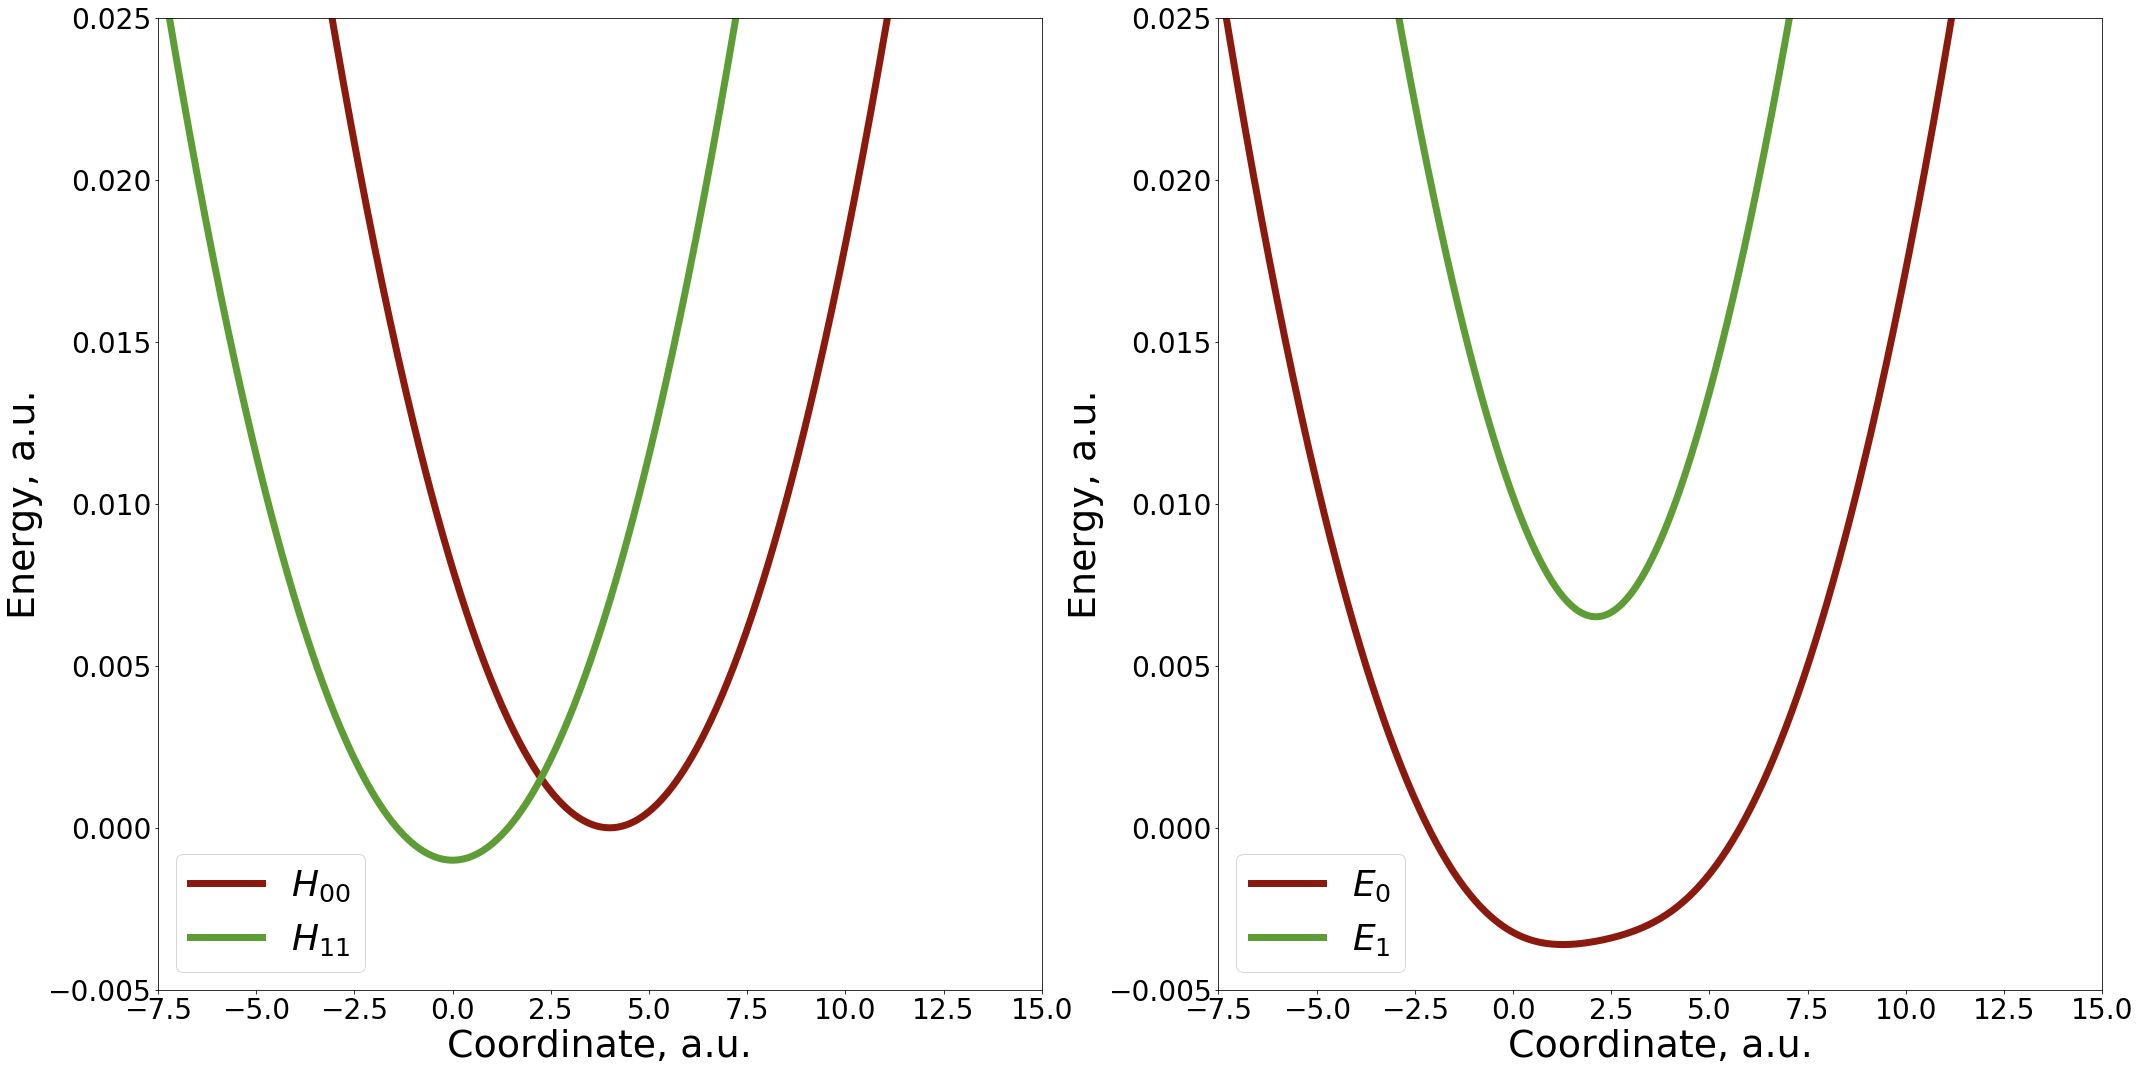

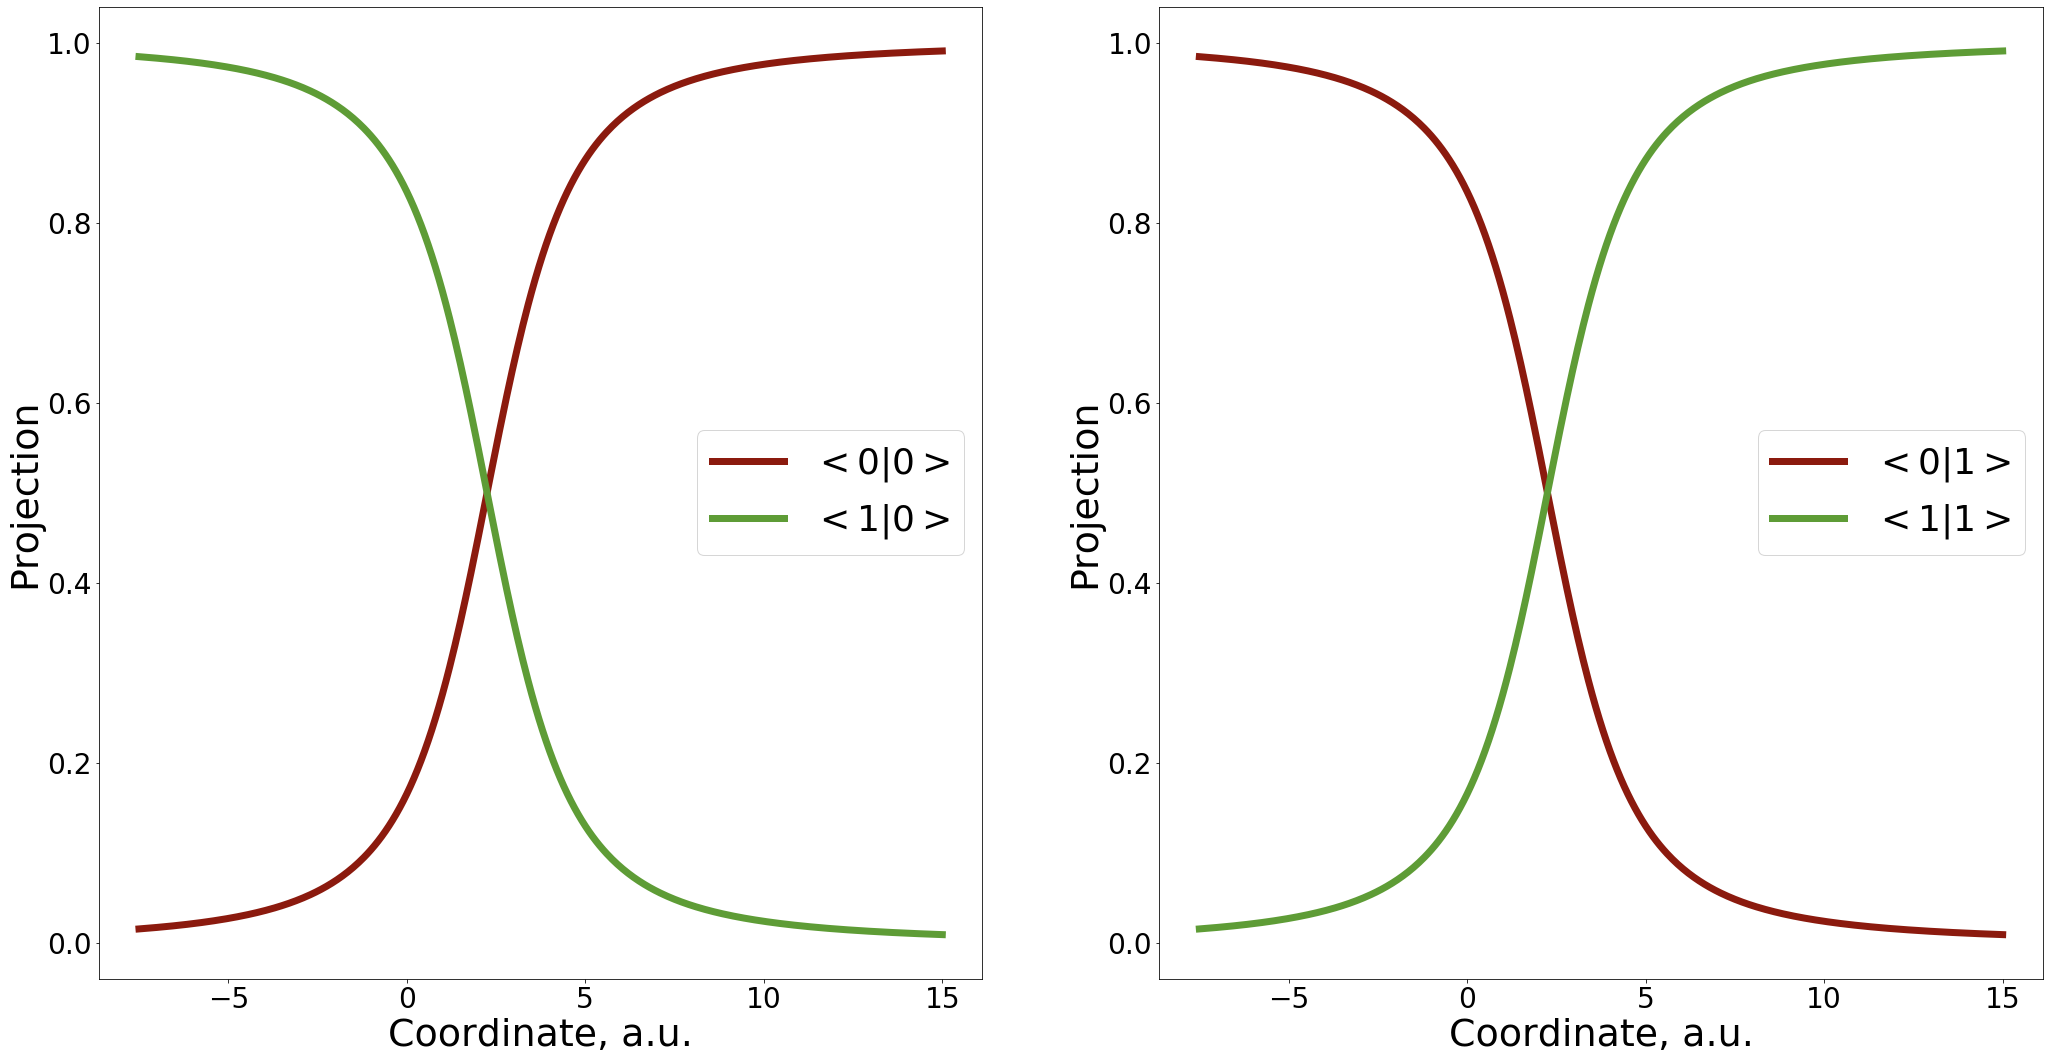

In [4]:
plot_params = {"colors": colors, "clrs_index": clrs_index}
dynamics_plotting.plot_surfaces(compute_model, [ param_sets[0] ], [0,1], -7.5, 15.0, 0.05, plot_params)

## 2. Run the calculations

In [5]:
properties_to_save = [ "timestep", "time", "Ekin_dia", "Ekin_adi", "Epot_dia", 
                       "Epot_adi", "Etot_dia", "Etot_adi", "norm_dia", "norm_adi",
                       "pop_dia", "pop_adi", "q_dia", "q_adi", "p_dia", "p_adi"     ] 


params = { "nsteps":1000, "dt":10.0, "progress_frequency":0.1,
           "rmin":[-15.0], "rmax":[15.0], "dx":[0.1], "nstates":2,
           "x0":[0.0], "p0":[0.0], "istate":[1,0], "masses":[2000.0], "k":[0.001],           
           "integrator":"SOFT",
          
           "prefix":"Tut3-1",
           "hdf5_output_level":2, "compression_level":[0,0,0], "use_compression":1,
           "mem_output_level":0, 
           "txt_output_level":0,
           "properties_to_save": properties_to_save
         }

plot_params = {"prefix":"Tut3-1", "filename":"data.hdf", "hdf5_output_level":3,
                "which_dofs":[0],  "which_adi_states":[0, 1], "which_dia_states":[0, 1],                
                "properties_to_save": properties_to_save                           
              }

In [11]:
def run_case(prefix, model_params, x0, istate):
    """
    To run calculations and to plot the results
    """
    
    params1 = dict(params)
    params1.update({ "prefix":prefix, "x0":x0, "istate":istate })
    res = dynamics_exact.run_relaxation( params1, potential, model_params )

    plot_params1 = dict(plot_params)
    plot_params1.update({"prefix":prefix})
    dynamics_exact.plot_hdf5(plot_params1)

## Model 1

### Case 1

Run calculations with the dynamical parameters  {'nsteps': 1000, 'dt': 10.0, 'progress_frequency': 0.1, 'rmin': [-15.0], 'rmax': [15.0], 'dx': [0.1], 'nstates': 2, 'x0': [0.0], 'p0': [0.0], 'istate': [1, 0], 'masses': [2000.0], 'k': [0.001], 'integrator': 'SOFT', 'prefix': 'Tut3-case-1', 'hdf5_output_level': 2, 'compression_level': [0, 0, 0], 'use_compression': 1, 'mem_output_level': 0, 'txt_output_level': 0, 'properties_to_save': ['timestep', 'time', 'Ekin_dia', 'Ekin_adi', 'Epot_dia', 'Epot_adi', 'Etot_dia', 'Etot_adi', 'norm_dia', 'norm_adi', 'pop_dia', 'pop_adi', 'q_dia', 'q_adi', 'p_dia', 'p_adi']}
Run calculations with the model parameters  {'model': 1, 'E_n': [0.0, -0.001], 'x_n': [4.0, 0.0], 'k_n': [0.001, 0.001], 'V': 0.005}
Norm (dia) =  1.0
Norm (adi) =  1.0
Ekin (dia) =  0.00018012185796967037
Ekin (adi) =  0.00017677669529663636
Epot (dia) =  -0.0031096719171977124
Epot (adi) =  -0.003109671917197712
 step= 0
 step= 100
 step= 200
 step= 300
 step= 400
 step= 500
 step= 60

/home/alexey/miniconda2/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


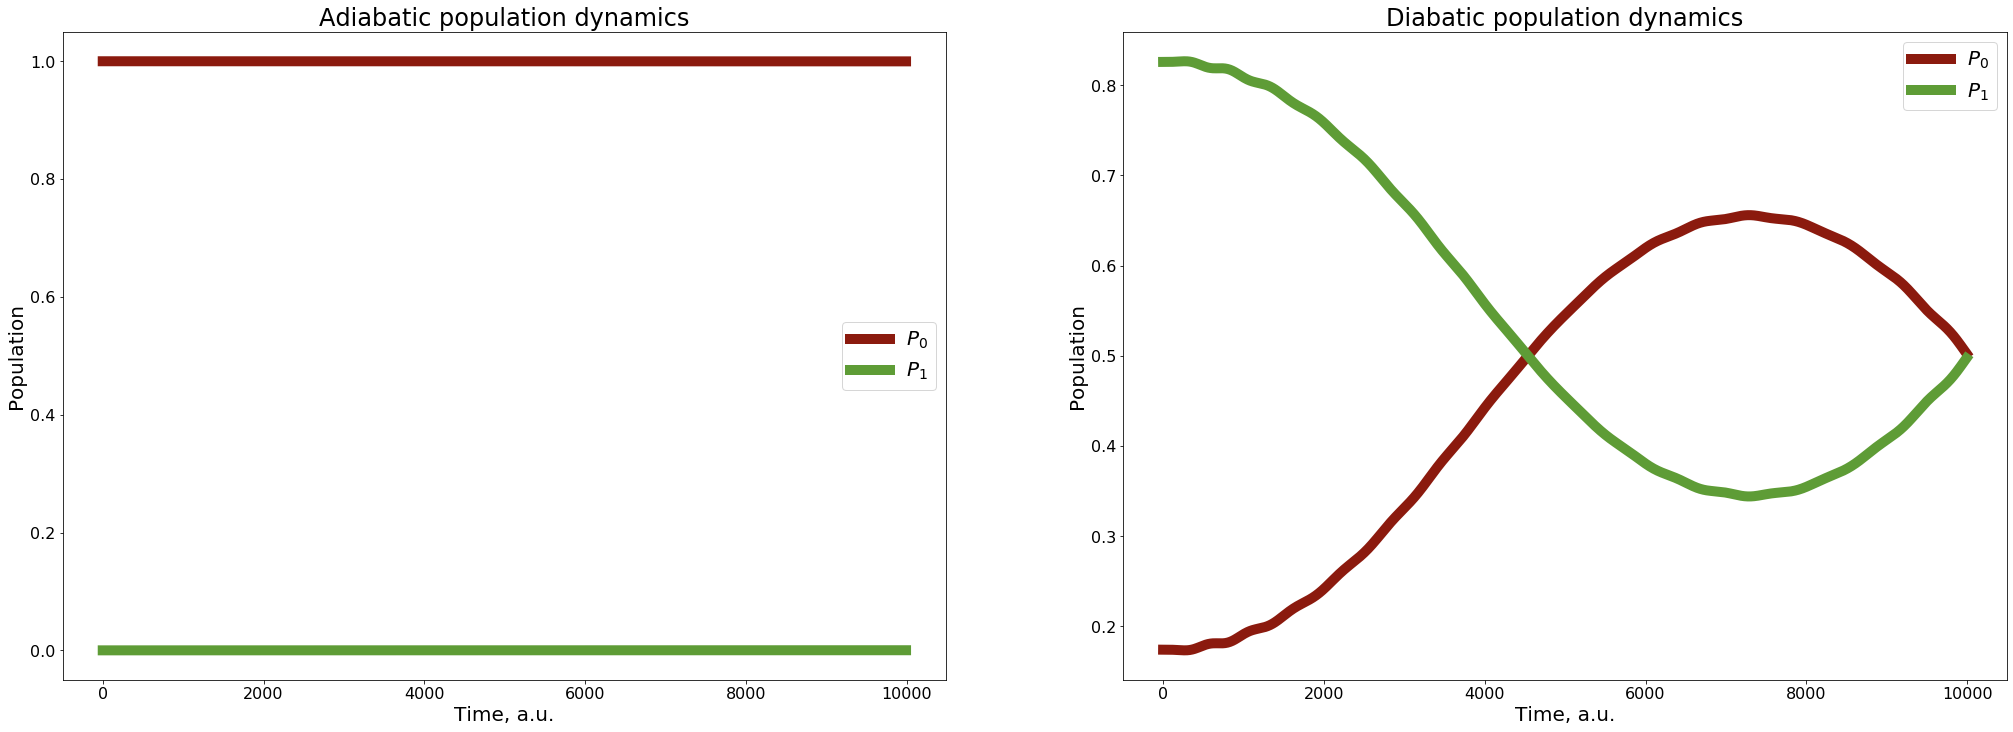

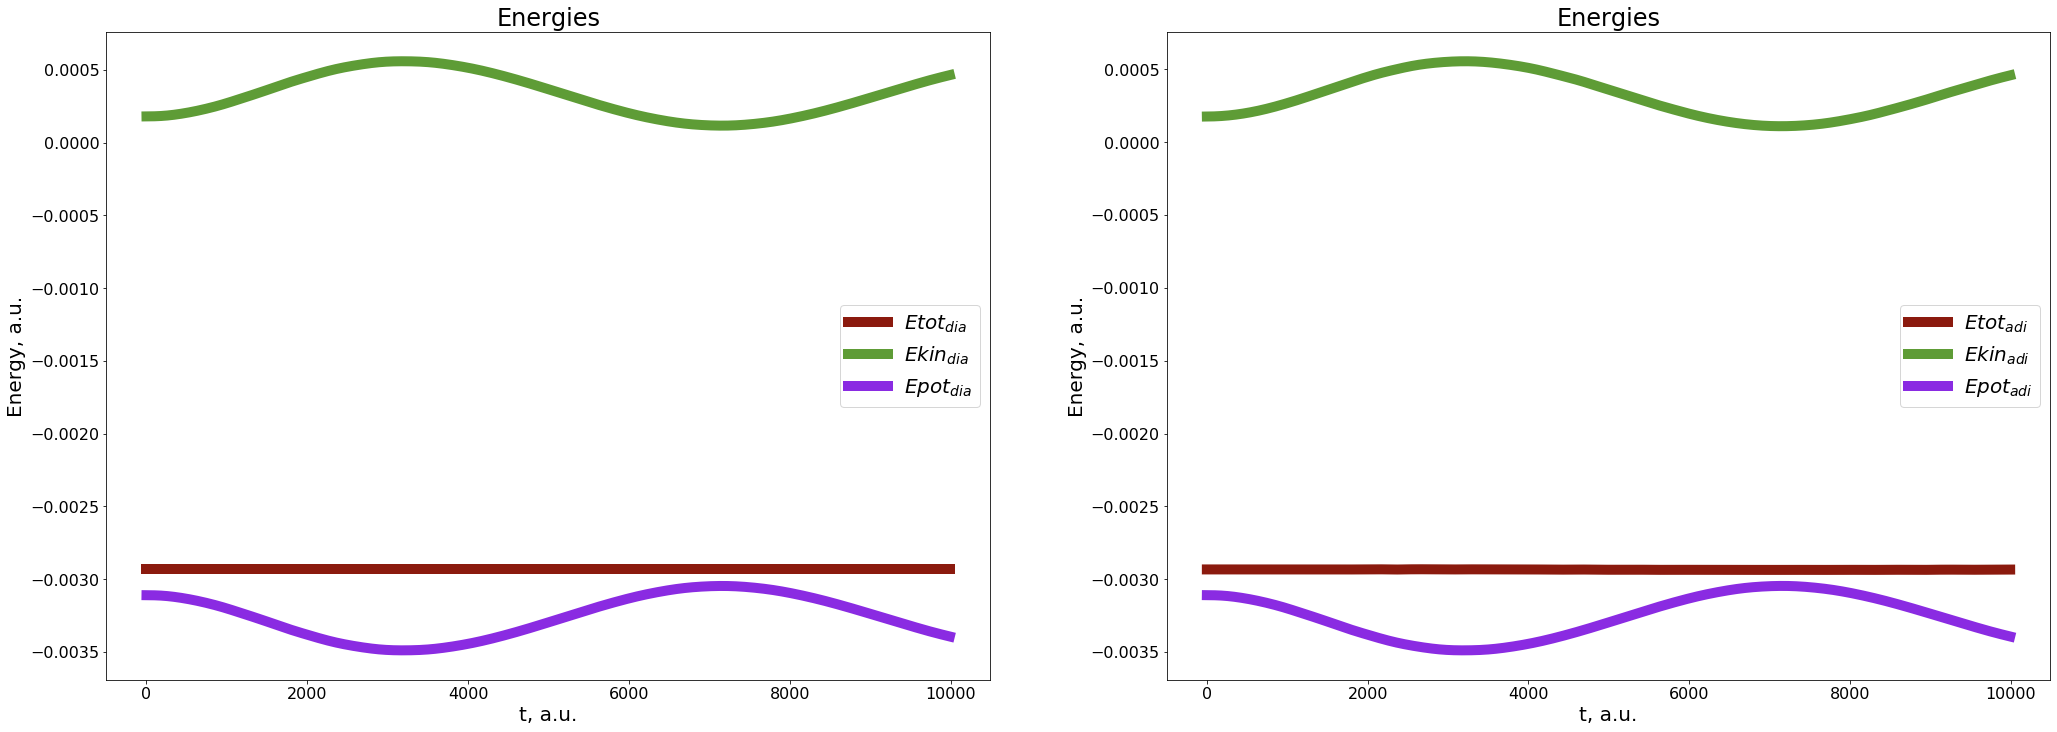

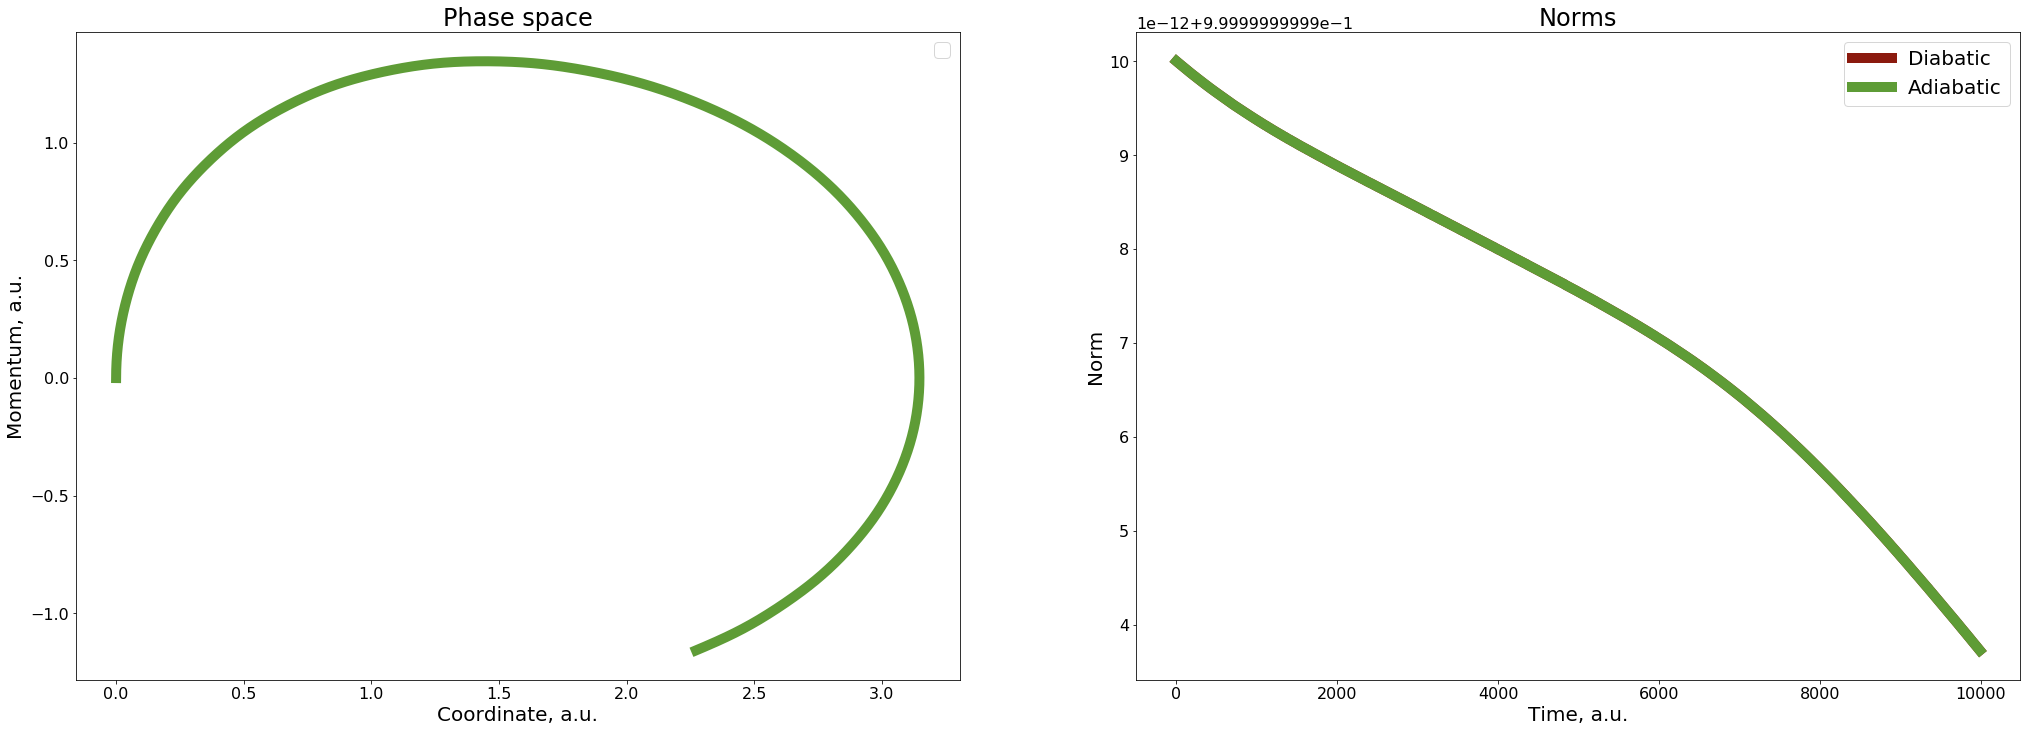

In [12]:
prefix = "Tut3-case-1"

model_params = dict(param_sets[0])
x0 = [0.0]
istate = [1, 0]  # adiabatic state 0


run_case(prefix, model_params, x0, istate)

### Case 2

Run calculations with the dynamical parameters  {'nsteps': 1000, 'dt': 10.0, 'progress_frequency': 0.1, 'rmin': [-15.0], 'rmax': [15.0], 'dx': [0.1], 'nstates': 2, 'x0': [0.0], 'p0': [0.0], 'istate': [0, 0], 'masses': [2000.0], 'k': [0.001], 'integrator': 'SOFT', 'prefix': 'Tut3-case-2', 'hdf5_output_level': 2, 'compression_level': [0, 0, 0], 'use_compression': 1, 'mem_output_level': 0, 'txt_output_level': 0, 'properties_to_save': ['timestep', 'time', 'Ekin_dia', 'Ekin_adi', 'Epot_dia', 'Epot_adi', 'Etot_dia', 'Etot_adi', 'norm_dia', 'norm_adi', 'pop_dia', 'pop_adi', 'q_dia', 'q_adi', 'p_dia', 'p_adi']}
Run calculations with the model parameters  {'model': 1, 'E_n': [0.0, -0.001], 'x_n': [4.0, 0.0], 'k_n': [0.001, 0.001], 'V': 0.005}
Norm (dia) =  1.0
Norm (adi) =  1.0
Ekin (dia) =  0.00017677669529663636
Ekin (adi) =  0.00018369189870265427
Epot (dia) =  0.008176776695296631
Epot (adi) =  0.008176776695296633
 step= 0
 step= 100
 step= 200
 step= 300
 step= 400
 step= 500
 step= 600
 

/home/alexey/miniconda2/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


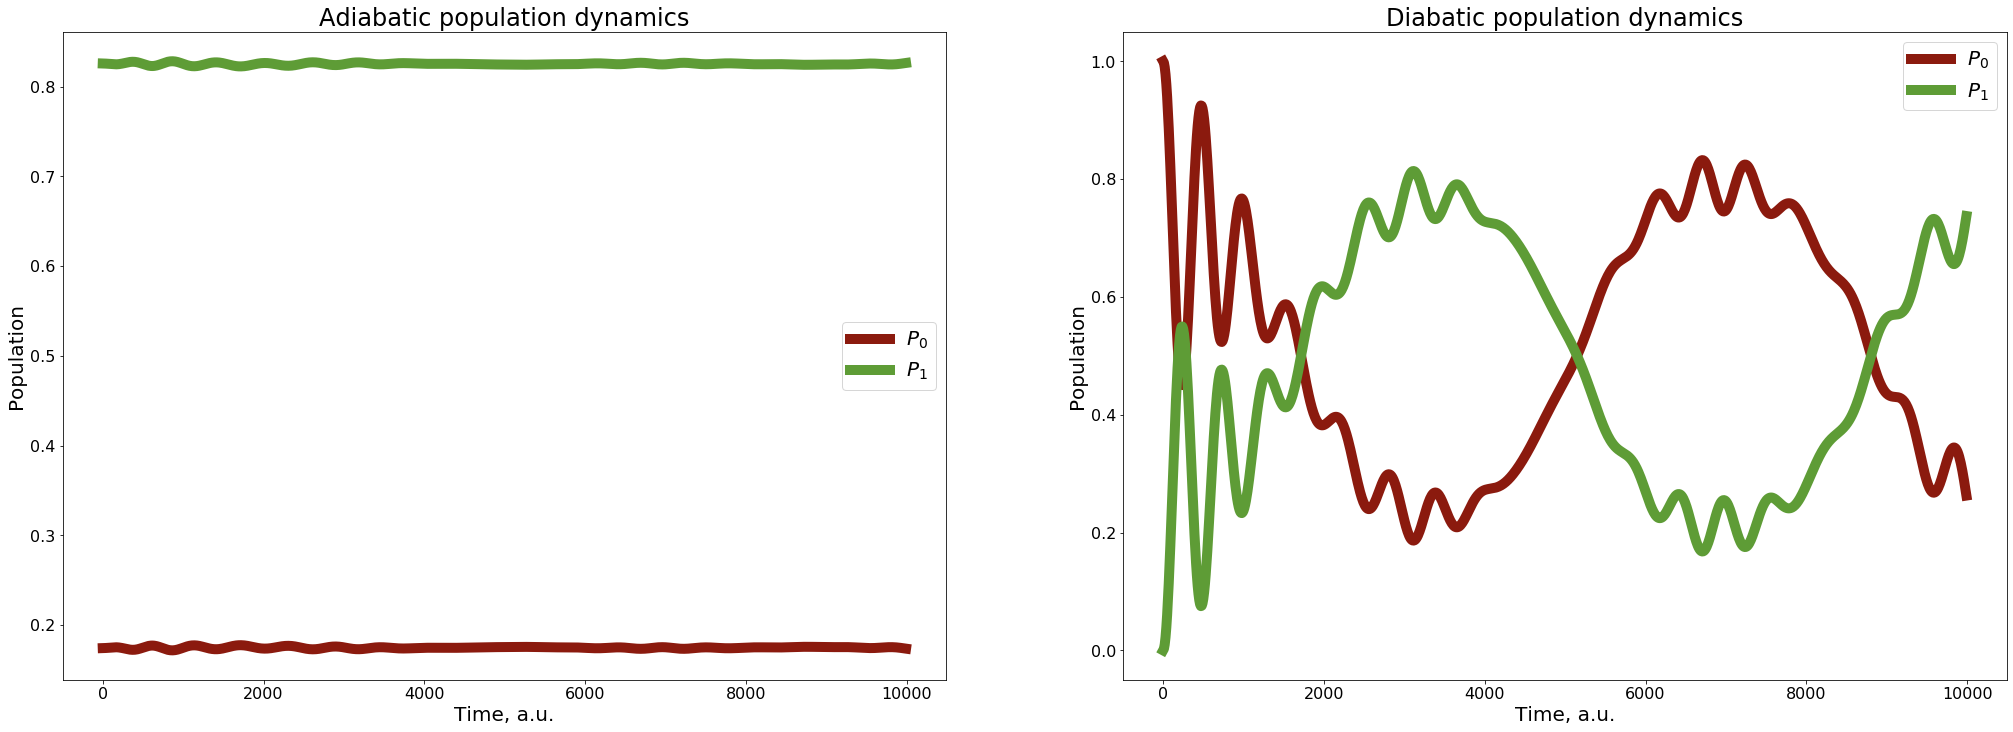

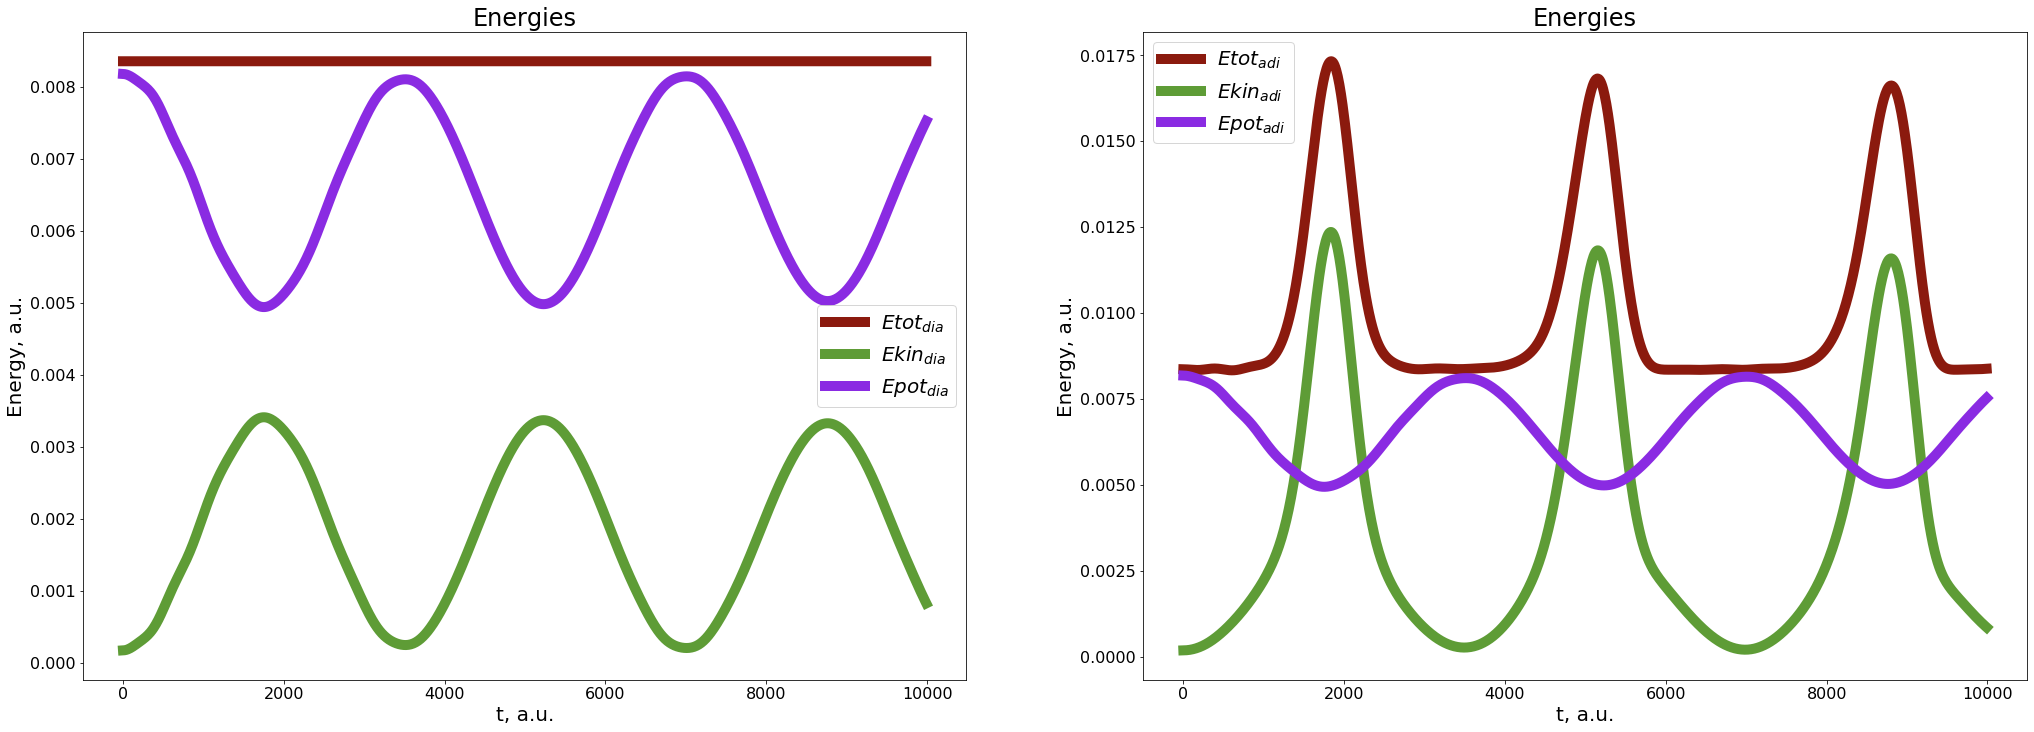

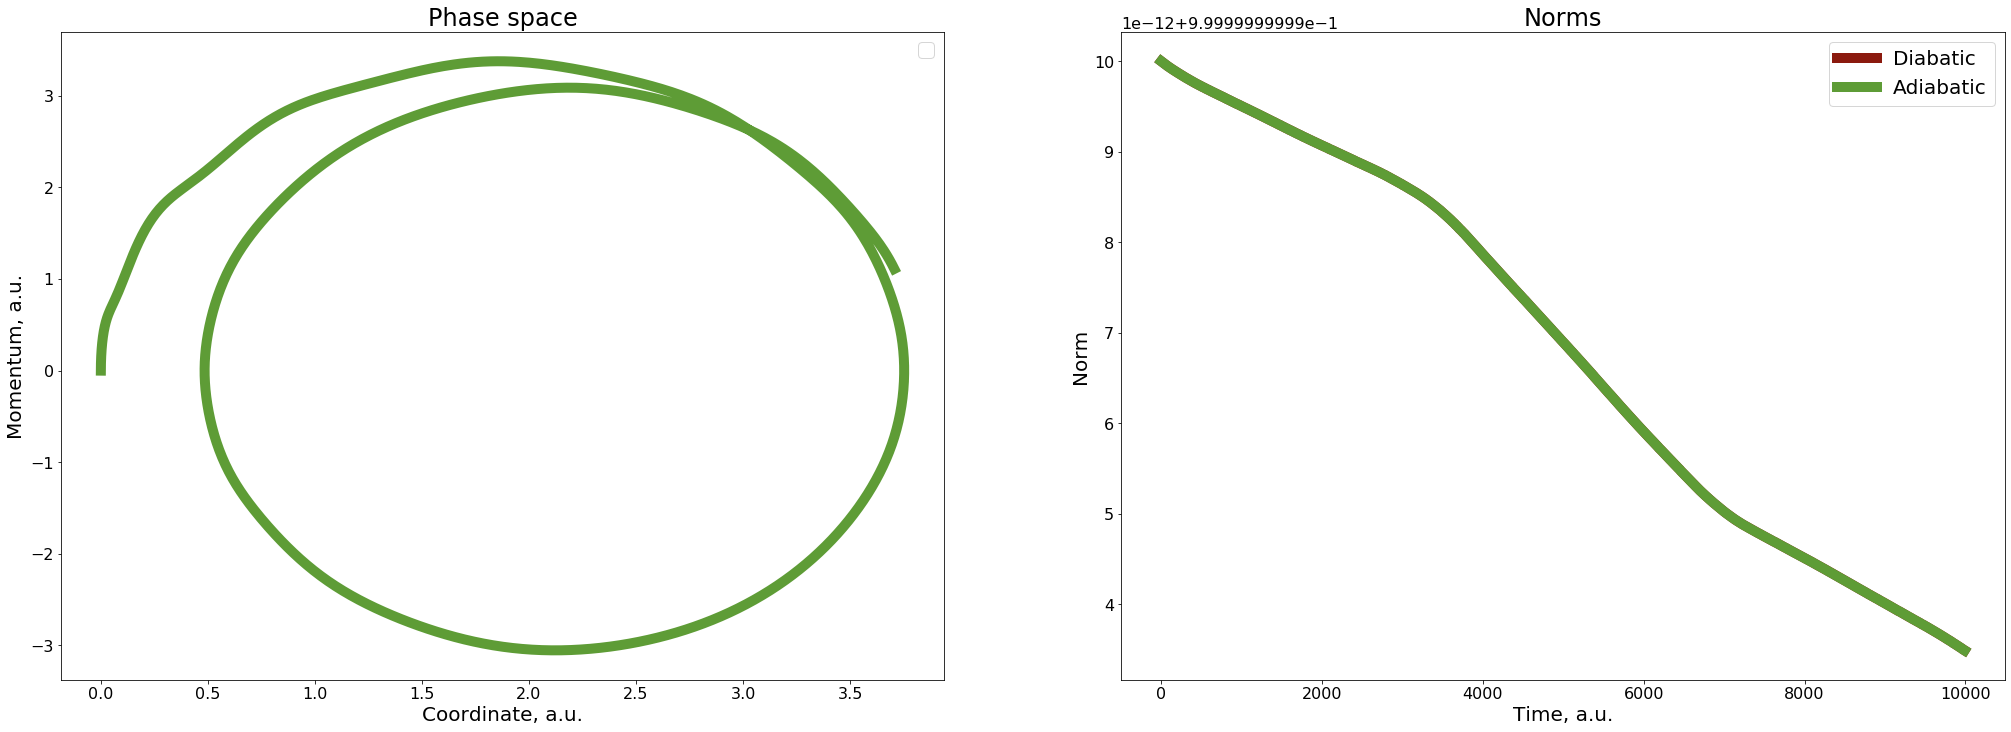

In [13]:
prefix = "Tut3-case-2"

model_params = dict(param_sets[0])
x0 = [0.0]
istate = [0, 0]  # diabatic state 0


run_case(prefix, model_params, x0, istate)

### Case 3

Run calculations with the dynamical parameters  {'nsteps': 1000, 'dt': 10.0, 'progress_frequency': 0.1, 'rmin': [-15.0], 'rmax': [15.0], 'dx': [0.1], 'nstates': 2, 'x0': [-5.0], 'p0': [0.0], 'istate': [1, 0], 'masses': [2000.0], 'k': [0.001], 'integrator': 'SOFT', 'prefix': 'Tut3-case-3', 'hdf5_output_level': 2, 'compression_level': [0, 0, 0], 'use_compression': 1, 'mem_output_level': 0, 'txt_output_level': 0, 'properties_to_save': ['timestep', 'time', 'Ekin_dia', 'Ekin_adi', 'Epot_dia', 'Epot_adi', 'Etot_dia', 'Etot_adi', 'norm_dia', 'norm_adi', 'pop_dia', 'pop_adi', 'q_dia', 'q_adi', 'p_dia', 'p_adi']}
Run calculations with the model parameters  {'model': 1, 'E_n': [0.0, -0.001], 'x_n': [4.0, 0.0], 'k_n': [0.001, 0.001], 'V': 0.005}
Norm (dia) =  0.9999999999999997
Norm (adi) =  0.9999999999999997
Ekin (dia) =  0.00017689586067281838
Ekin (adi) =  0.00017677669529663644
Epot (dia) =  0.010833937370927285
Epot (adi) =  0.010833937370927289
 step= 0
 step= 100
 step= 200
 step= 300
 st

/home/alexey/miniconda2/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


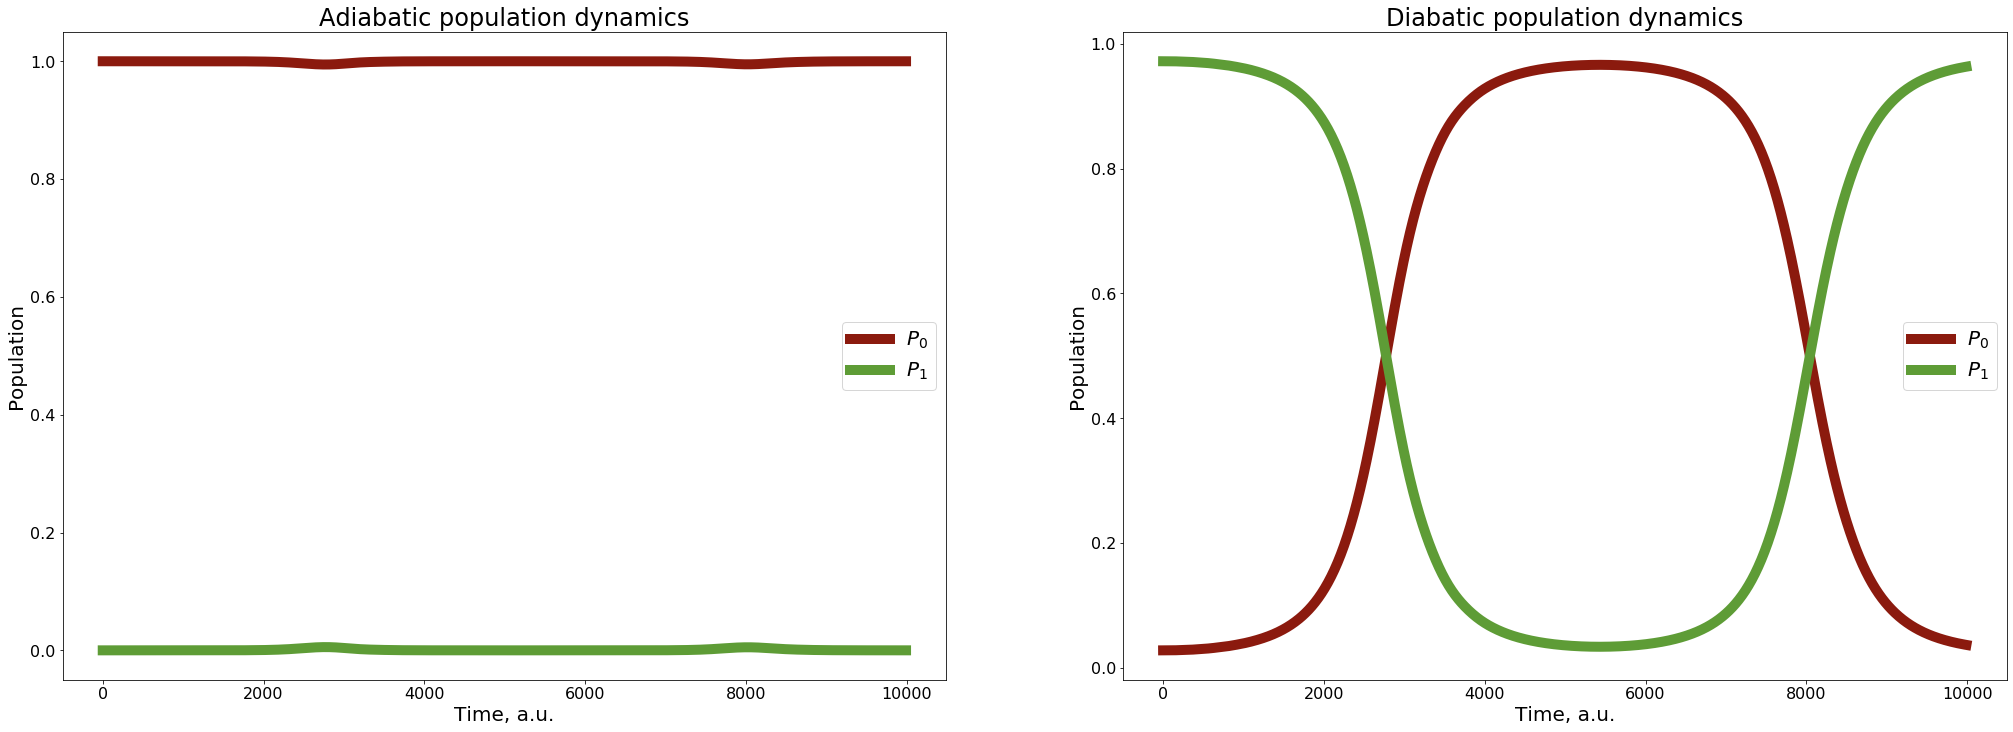

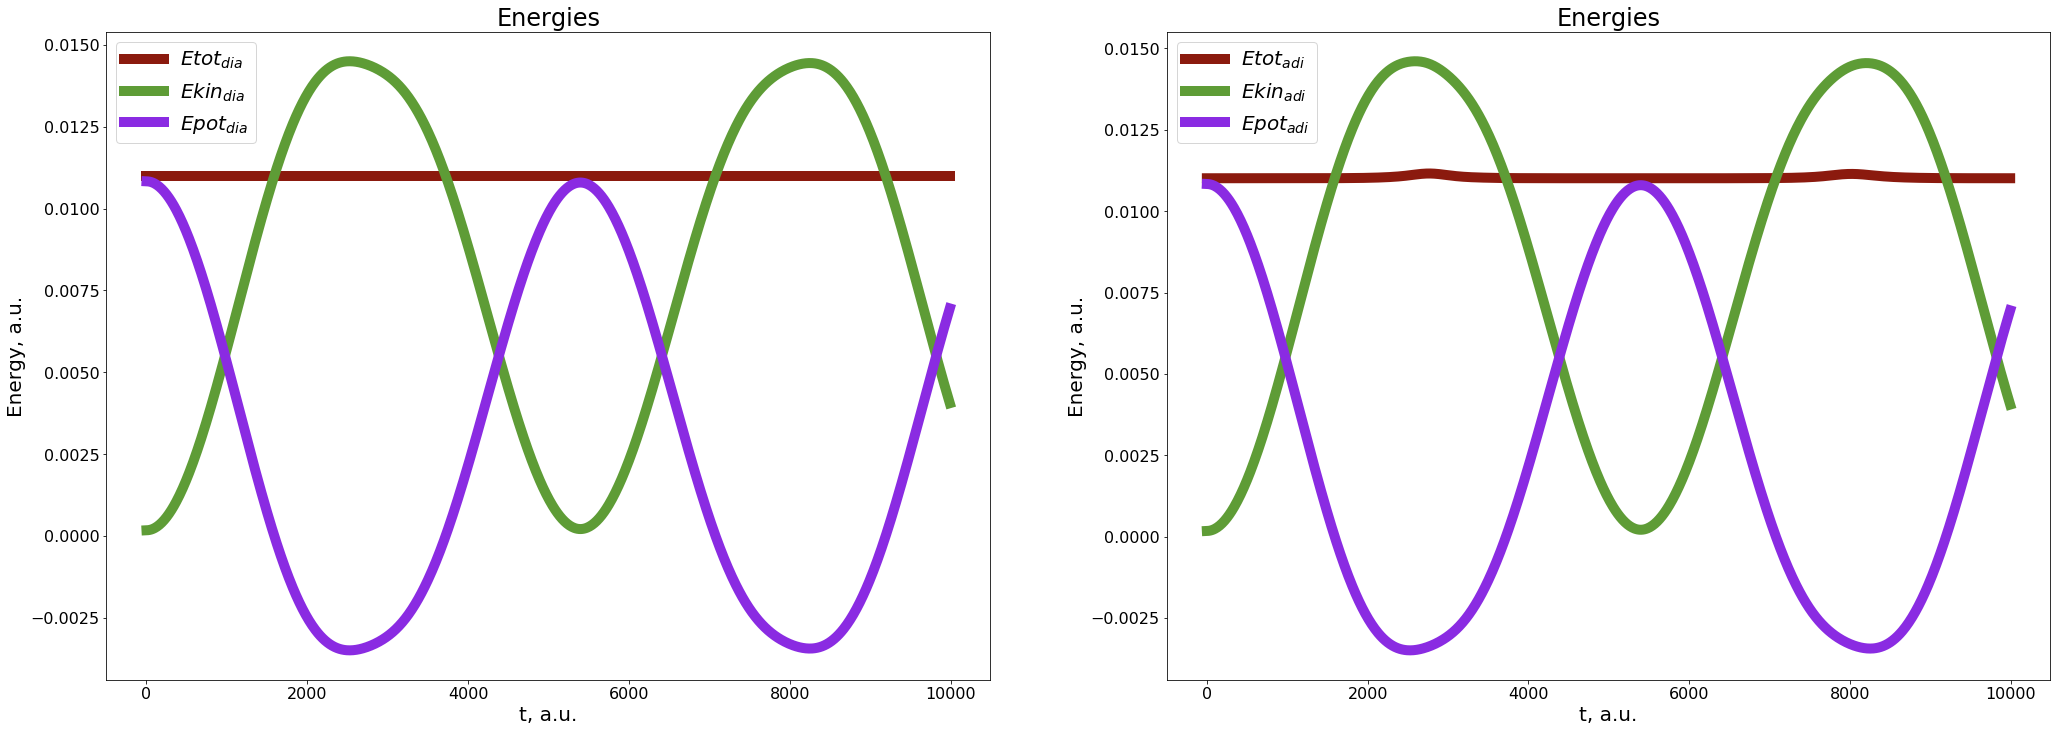

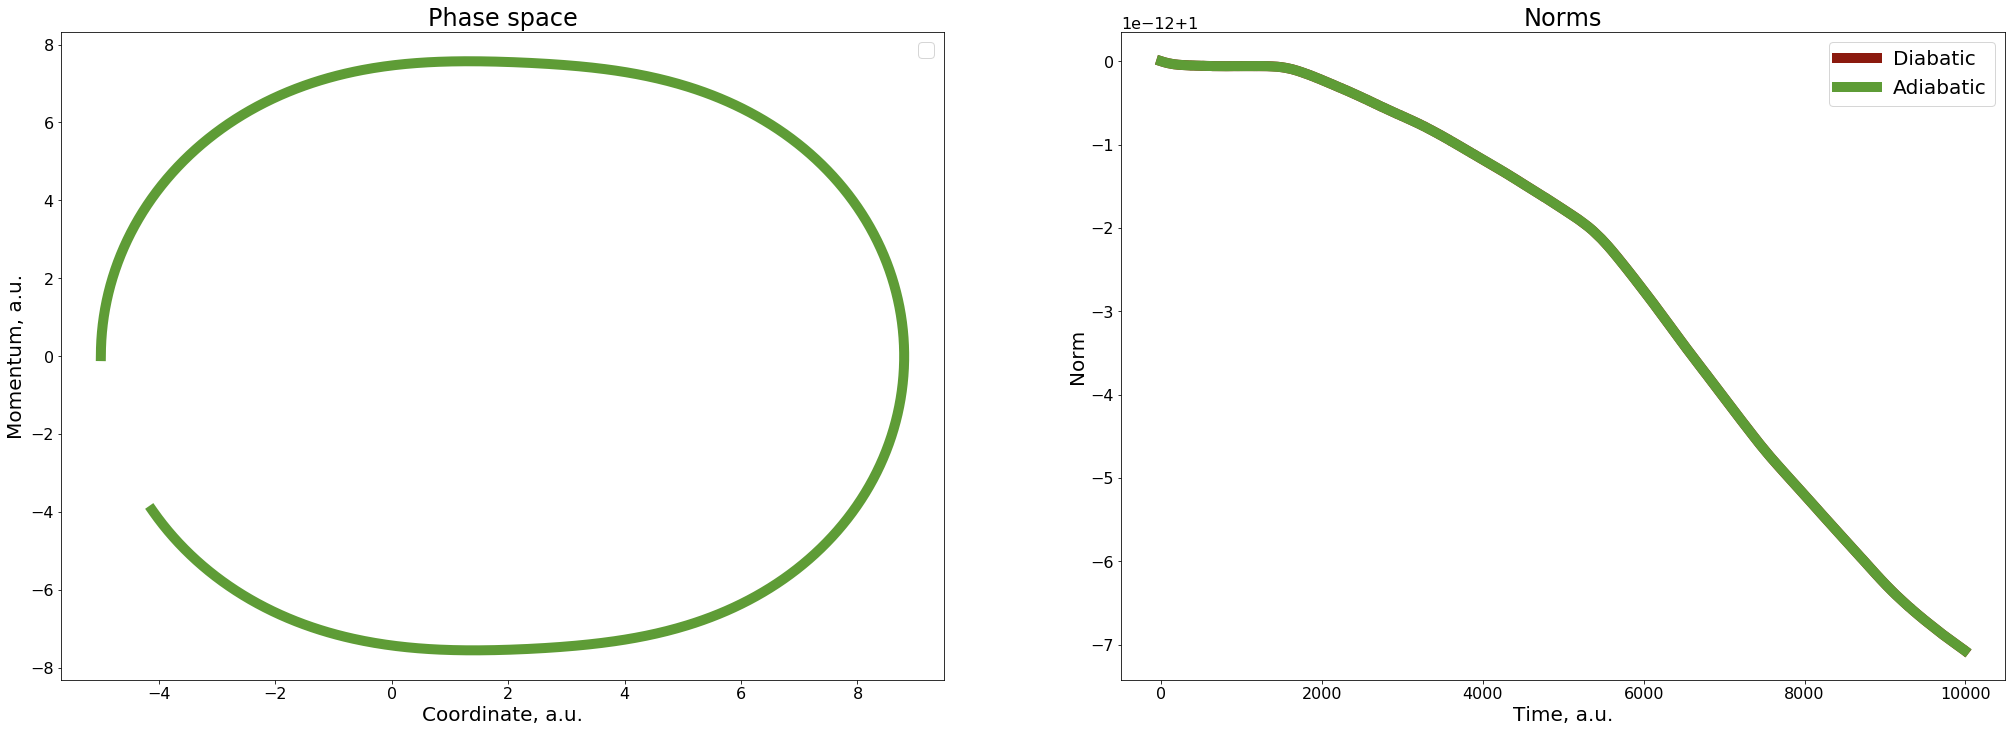

In [14]:
prefix = "Tut3-case-3"

model_params = dict(param_sets[0])
x0 = [-5.0]
istate = [1, 0]  # diabatic state 0


run_case(prefix, model_params, x0, istate)

### Case 4

Run calculations with the dynamical parameters  {'nsteps': 1000, 'dt': 10.0, 'progress_frequency': 0.1, 'rmin': [-15.0], 'rmax': [15.0], 'dx': [0.1], 'nstates': 2, 'x0': [-5.0], 'p0': [0.0], 'istate': [0, 0], 'masses': [2000.0], 'k': [0.001], 'integrator': 'SOFT', 'prefix': 'Tut3-case-4', 'hdf5_output_level': 2, 'compression_level': [0, 0, 0], 'use_compression': 1, 'mem_output_level': 0, 'txt_output_level': 0, 'properties_to_save': ['timestep', 'time', 'Ekin_dia', 'Ekin_adi', 'Epot_dia', 'Epot_adi', 'Etot_dia', 'Etot_adi', 'norm_dia', 'norm_adi', 'pop_dia', 'pop_adi', 'q_dia', 'q_adi', 'p_dia', 'p_adi']}
Run calculations with the model parameters  {'model': 1, 'E_n': [0.0, -0.001], 'x_n': [4.0, 0.0], 'k_n': [0.001, 0.001], 'V': 0.005}
Norm (dia) =  0.9999999999999997
Norm (adi) =  0.9999999999999997
Ekin (dia) =  0.00017677669529663644
Ekin (adi) =  0.00017689586067281838
Epot (dia) =  0.04067677669529666
Epot (adi) =  0.04067677669529666
 step= 0
 step= 100
 step= 200
 step= 300
 step

/home/alexey/miniconda2/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


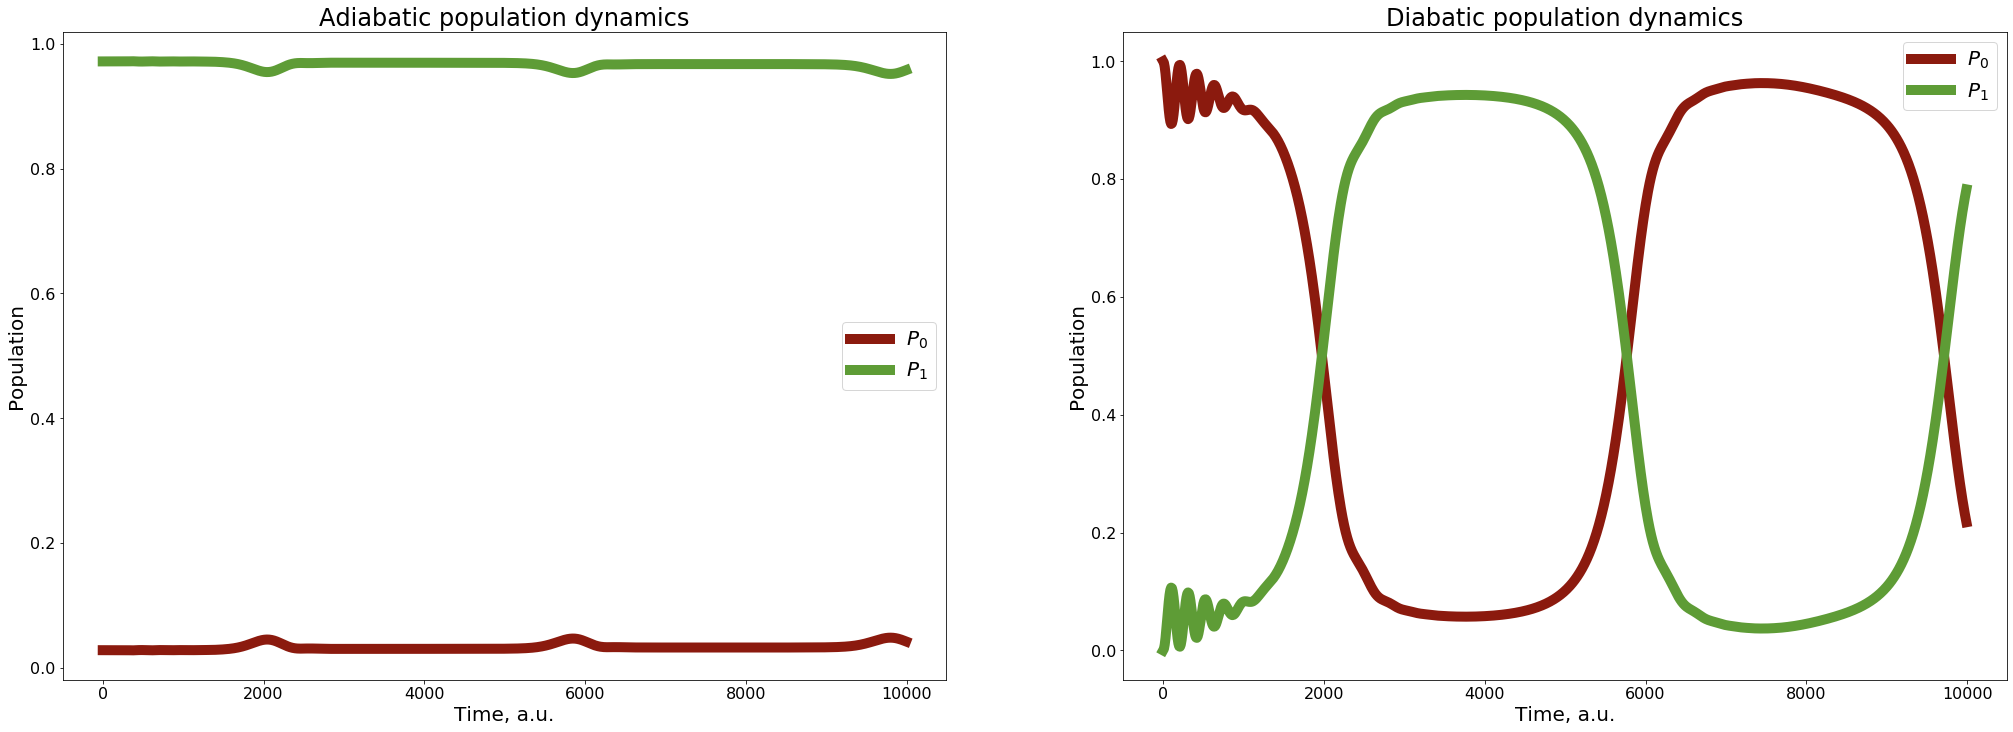

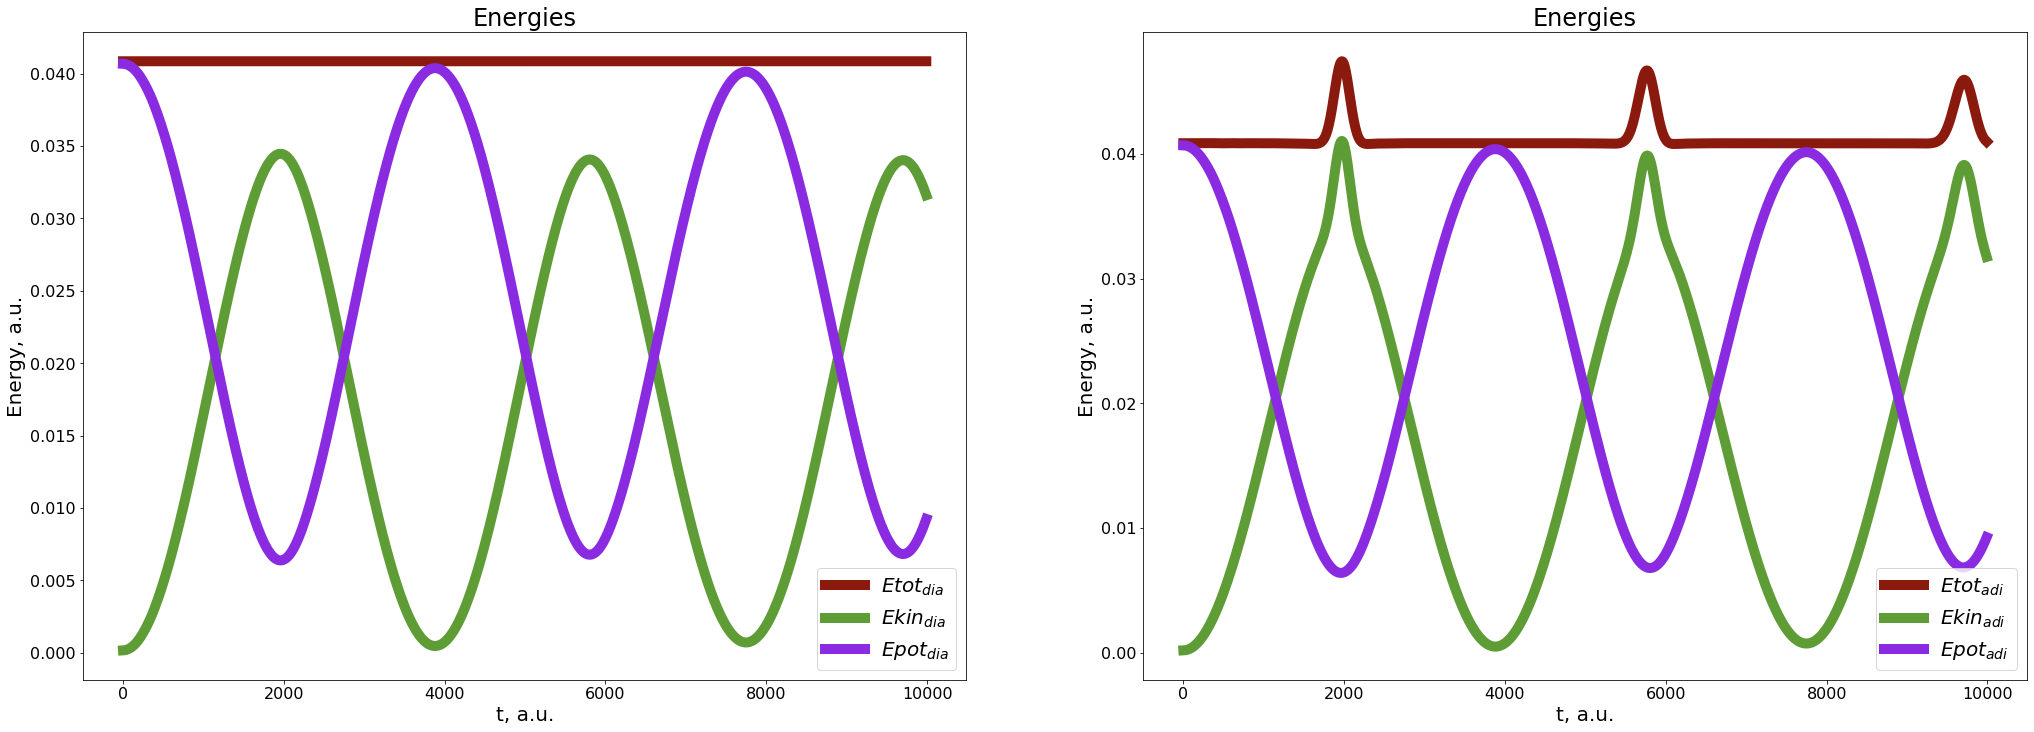

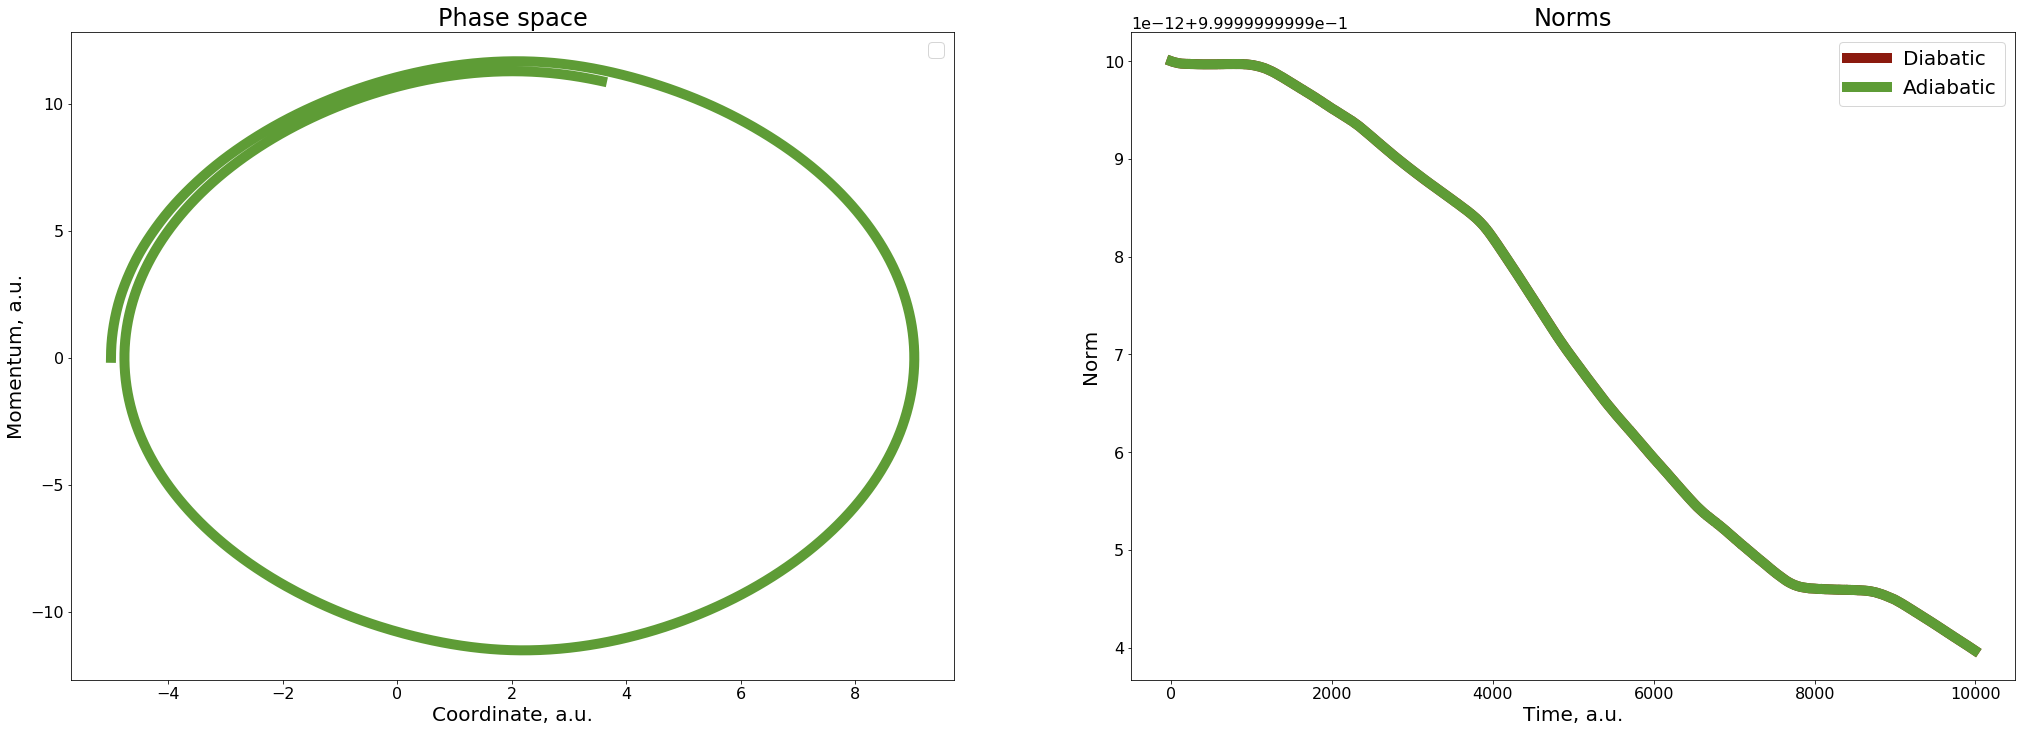

In [15]:
prefix = "Tut3-case-4"

model_params = dict(param_sets[0])
x0 = [-5.0]
istate = [0, 0]  # diabatic state 0


run_case(prefix, model_params, x0, istate)

## Model 2


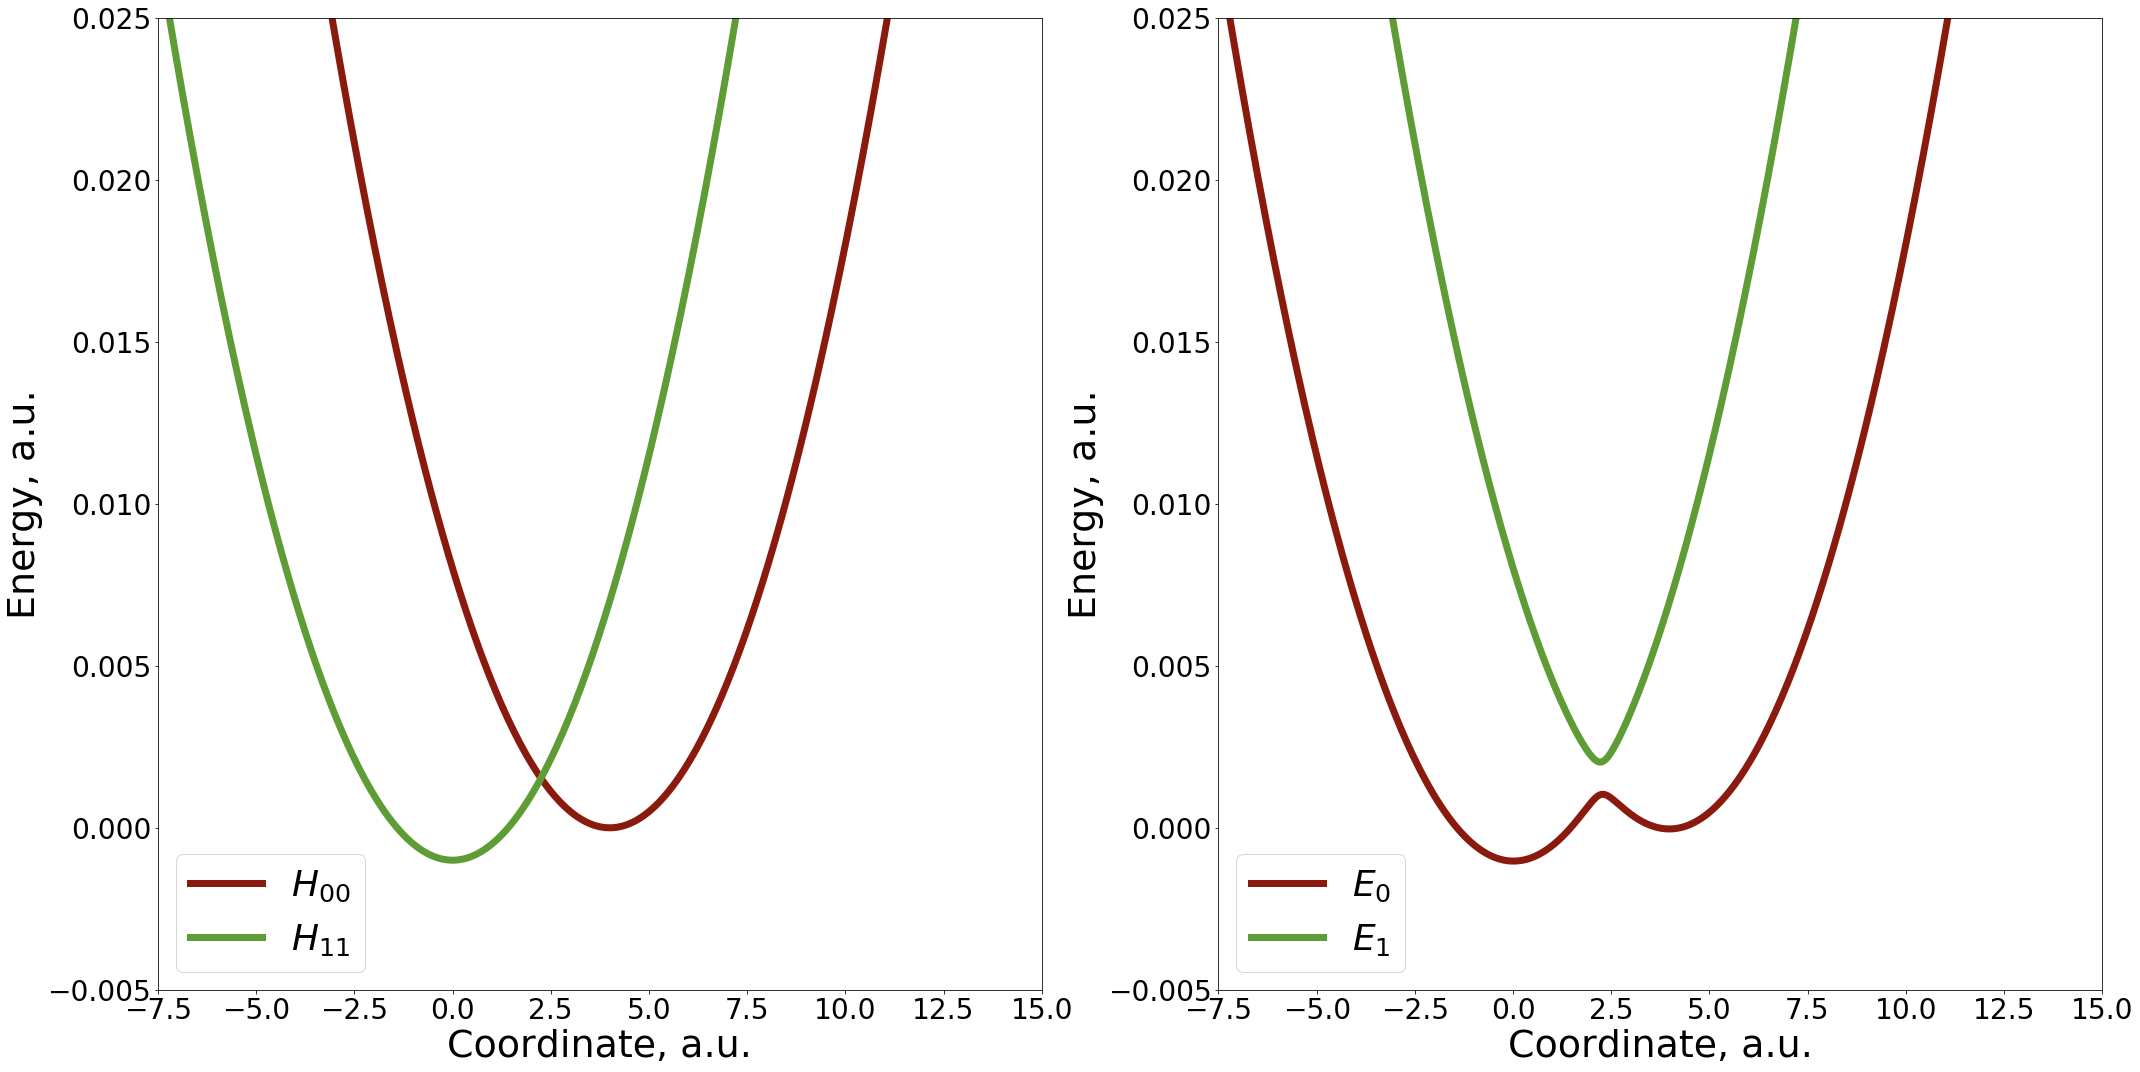

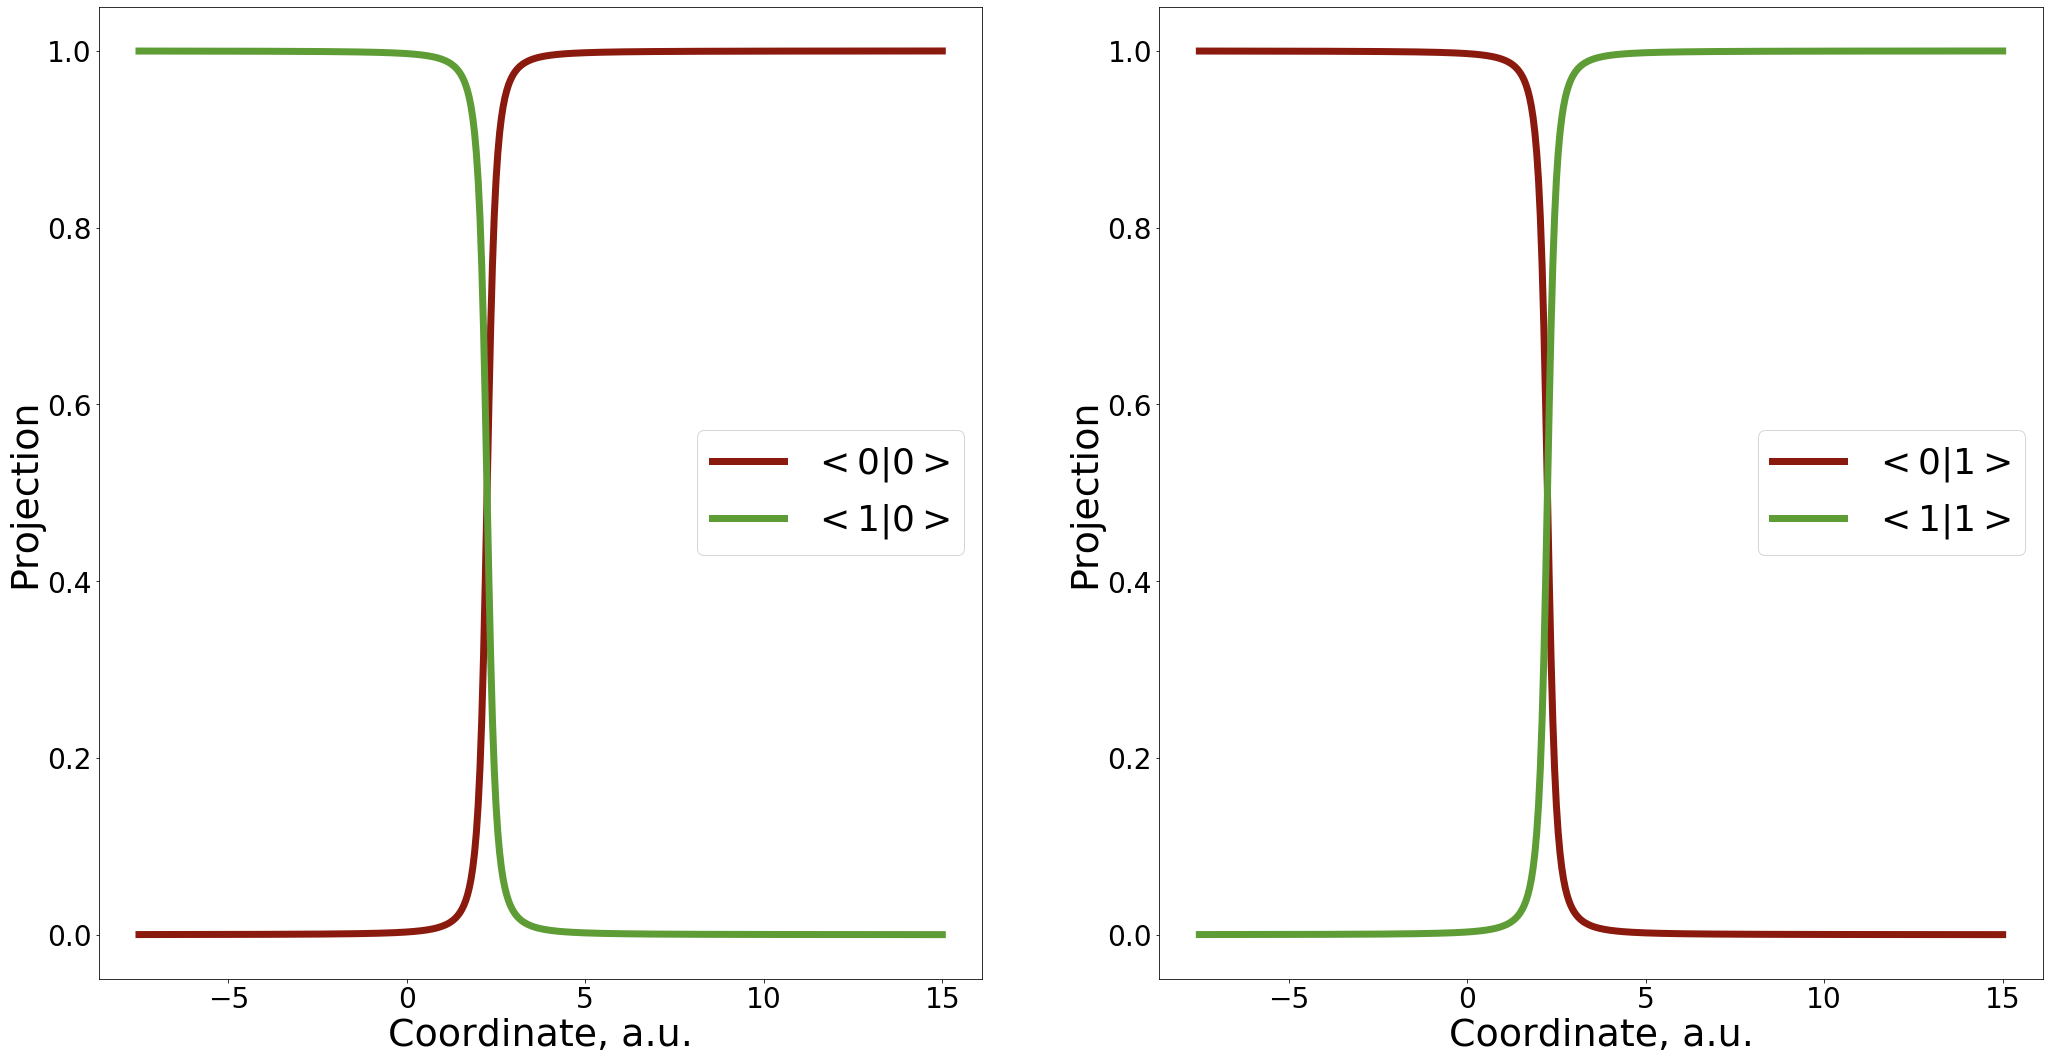

In [16]:
plot_params = {"colors": colors, "clrs_index": clrs_index}
dynamics_plotting.plot_surfaces(compute_model, [ param_sets[1] ], [0,1], -7.5, 15.0, 0.05, plot_params)

### Case 5

Run calculations with the dynamical parameters  {'nsteps': 1000, 'dt': 10.0, 'progress_frequency': 0.1, 'rmin': [-15.0], 'rmax': [15.0], 'dx': [0.1], 'nstates': 2, 'x0': [0.0], 'p0': [0.0], 'istate': [1, 0], 'masses': [2000.0], 'k': [0.001], 'integrator': 'SOFT', 'prefix': 'Tut3-case-5', 'hdf5_output_level': 2, 'compression_level': [0, 0, 0], 'use_compression': 1, 'mem_output_level': 0, 'txt_output_level': 0, 'properties_to_save': ['timestep', 'time', 'Ekin_dia', 'Ekin_adi', 'Epot_dia', 'Epot_adi', 'Etot_dia', 'Etot_adi', 'norm_dia', 'norm_adi', 'pop_dia', 'pop_adi', 'q_dia', 'q_adi', 'p_dia', 'p_adi']}
Run calculations with the model parameters  {'model': 1, 'E_n': [0.0, -0.001], 'x_n': [4.0, 0.0], 'k_n': [0.001, 0.001], 'V': 0.0005}
Norm (dia) =  1.0
Norm (adi) =  1.0
Ekin (dia) =  0.00017753284023040445
Ekin (adi) =  0.00017677669529663636
Epot (dia) =  -0.0008535164367210787
Epot (adi) =  -0.0008535164367210787
 step= 0
 step= 100
 step= 200
 step= 300
 step= 400
 step= 500
 step= 

/home/alexey/miniconda2/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


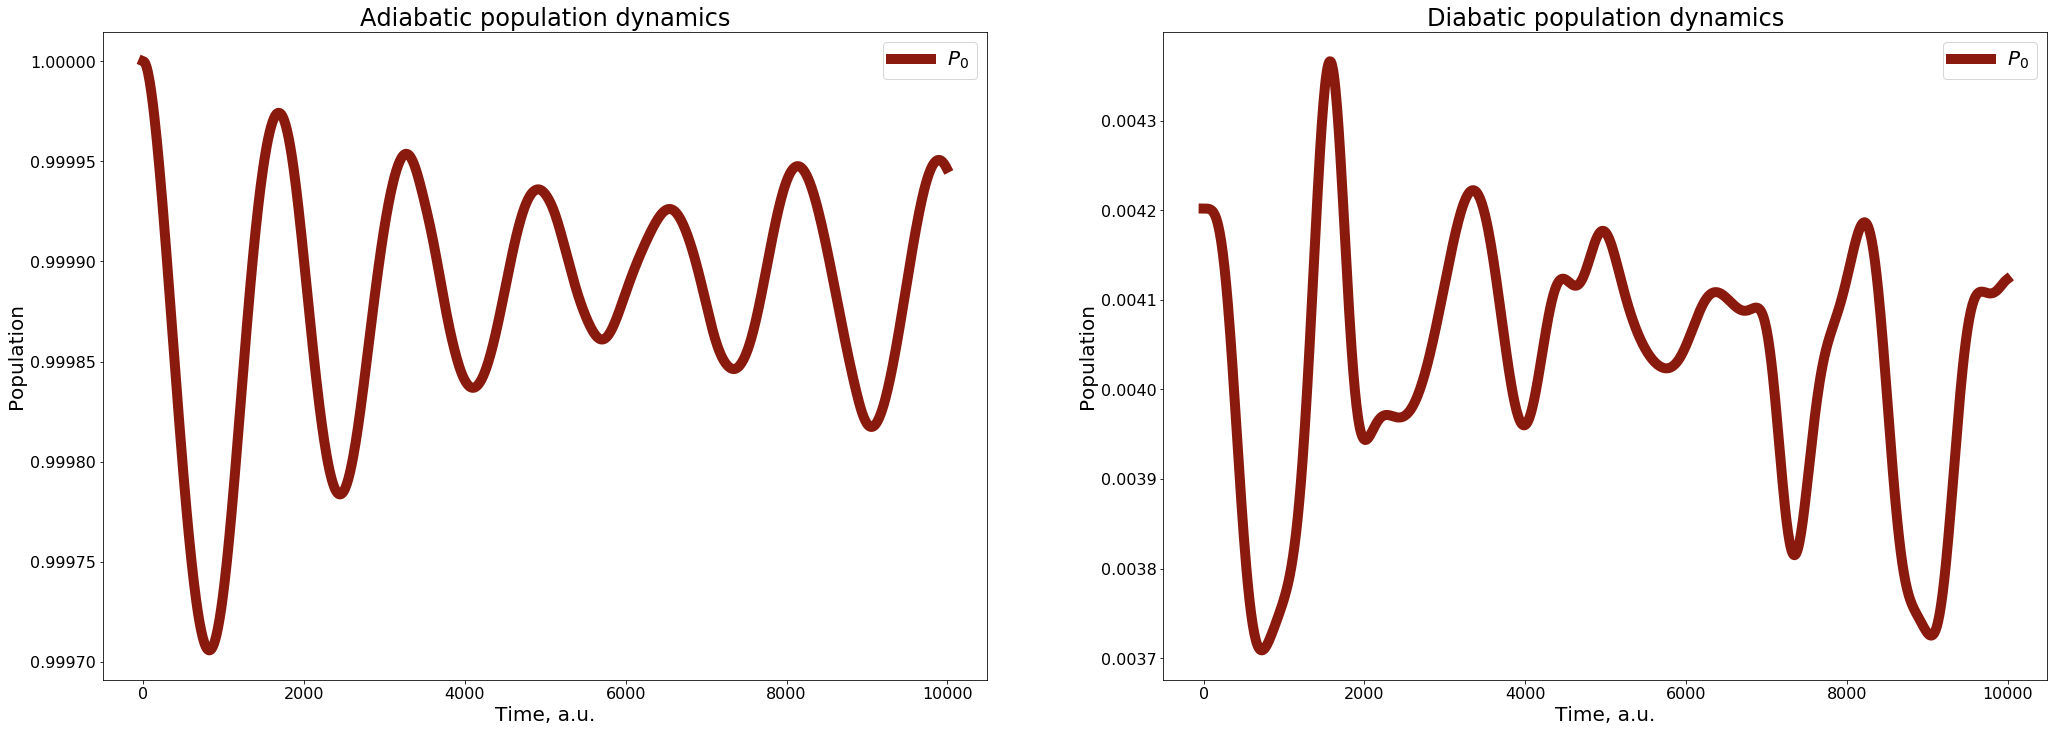

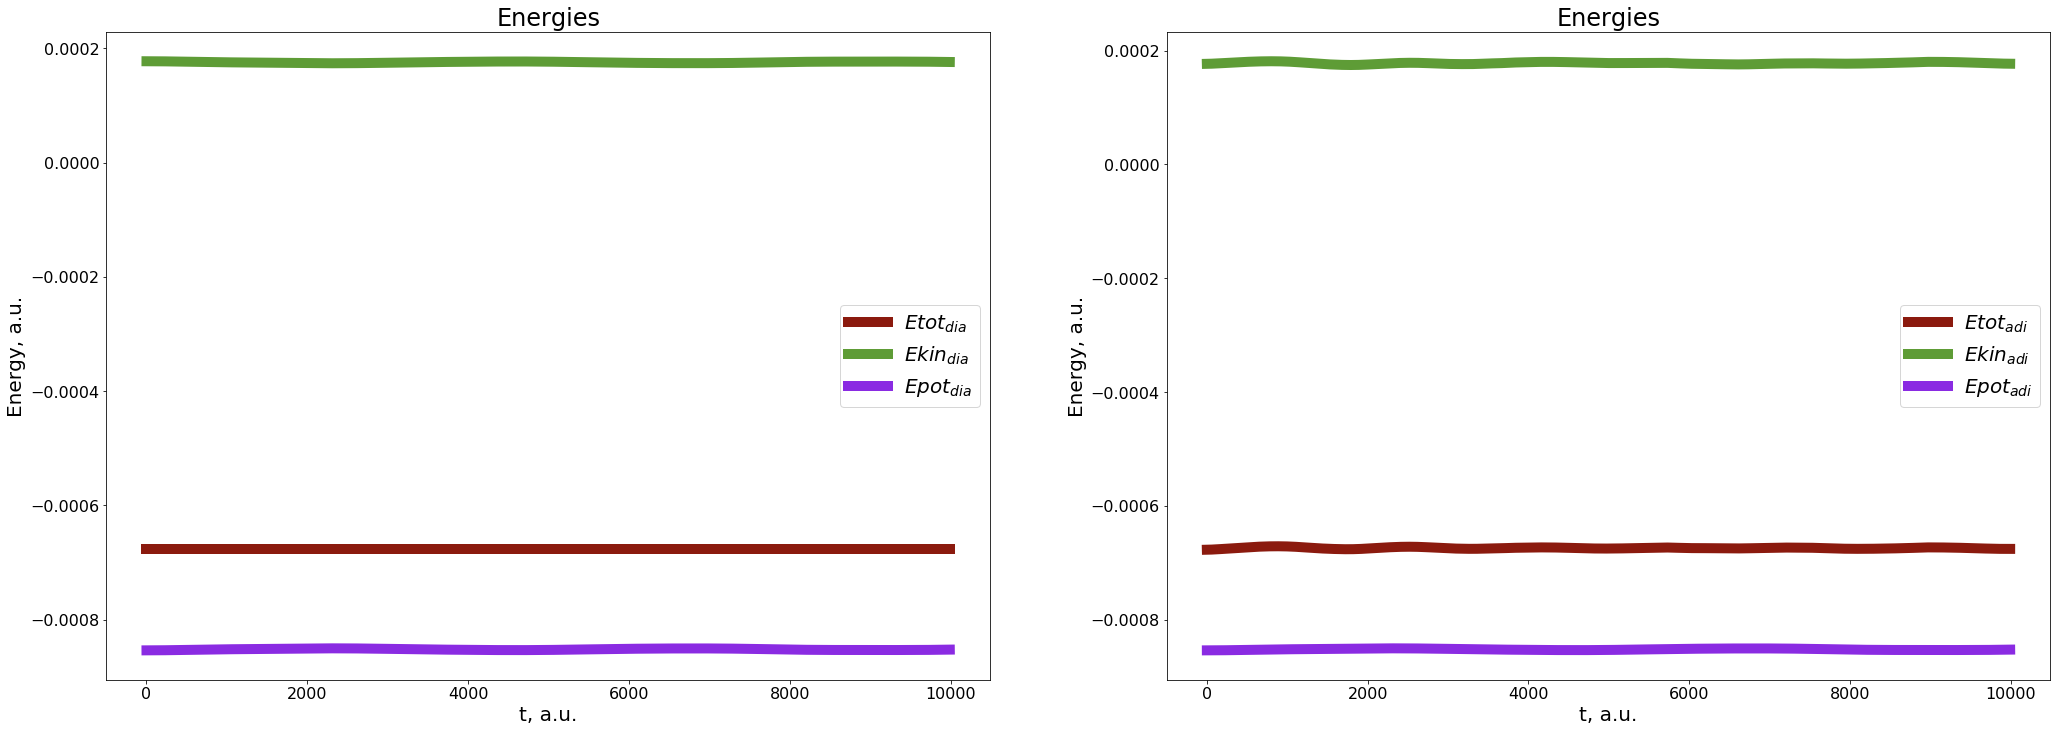

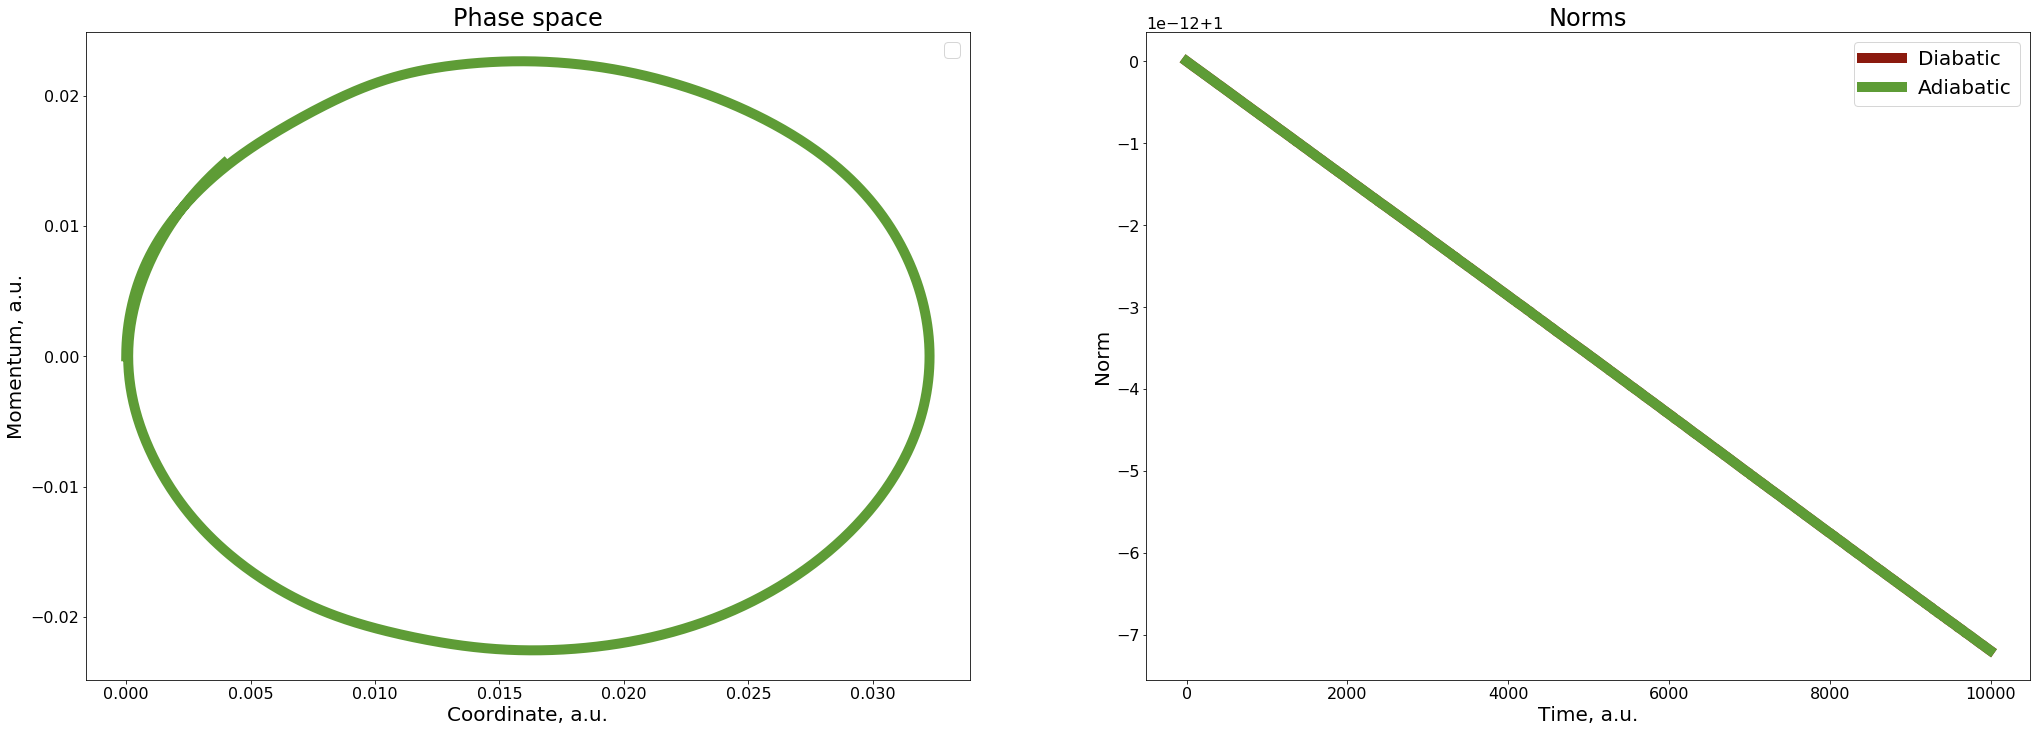

In [17]:
prefix = "Tut3-case-5"

model_params = dict(param_sets[1])
x0 = [0.0]
istate = [1, 0]  # adiabatic state 0


run_case(prefix, model_params, x0, istate)

### Case 6

Run calculations with the dynamical parameters  {'nsteps': 1000, 'dt': 10.0, 'progress_frequency': 0.1, 'rmin': [-15.0], 'rmax': [15.0], 'dx': [0.1], 'nstates': 2, 'x0': [0.0], 'p0': [0.0], 'istate': [0, 0], 'masses': [2000.0], 'k': [0.001], 'integrator': 'SOFT', 'prefix': 'Tut3-case-6', 'hdf5_output_level': 2, 'compression_level': [0, 0, 0], 'use_compression': 1, 'mem_output_level': 0, 'txt_output_level': 0, 'properties_to_save': ['timestep', 'time', 'Ekin_dia', 'Ekin_adi', 'Epot_dia', 'Epot_adi', 'Etot_dia', 'Etot_adi', 'norm_dia', 'norm_adi', 'pop_dia', 'pop_adi', 'q_dia', 'q_adi', 'p_dia', 'p_adi']}
Run calculations with the model parameters  {'model': 1, 'E_n': [0.0, -0.001], 'x_n': [4.0, 0.0], 'k_n': [0.001, 0.001], 'V': 0.0005}
Norm (dia) =  1.0
Norm (adi) =  1.0
Ekin (dia) =  0.00017677669529663636
Ekin (adi) =  0.00018103380655042116
Epot (dia) =  0.008176776695296631
Epot (adi) =  0.008176776695296631
 step= 0
 step= 100
 step= 200
 step= 300
 step= 400
 step= 500
 step= 600


/home/alexey/miniconda2/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


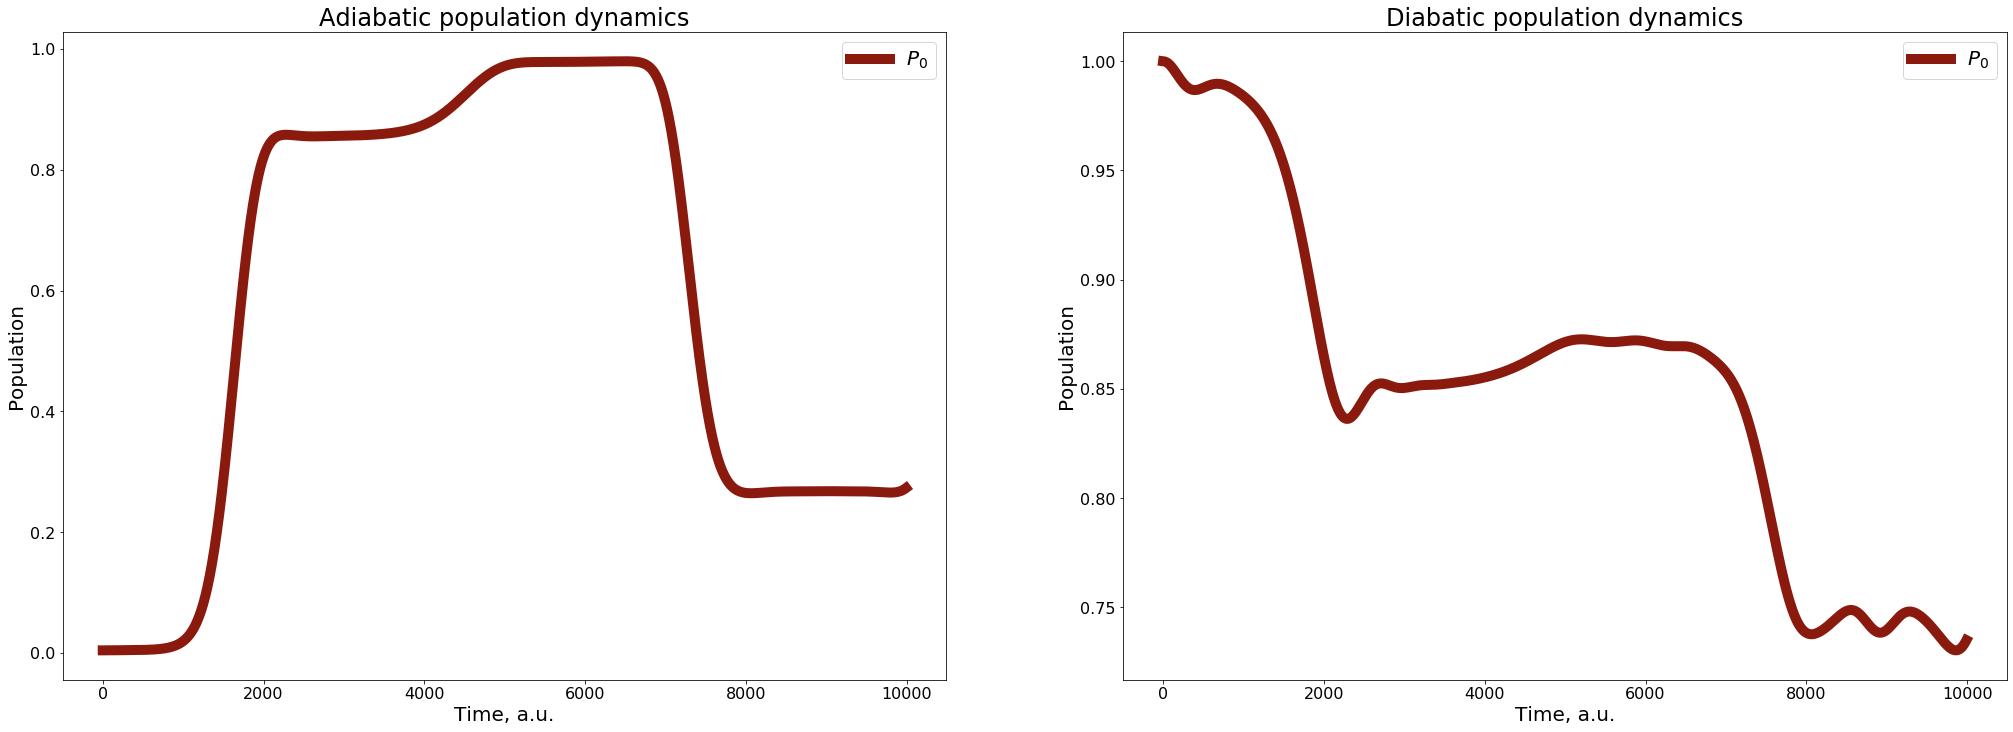

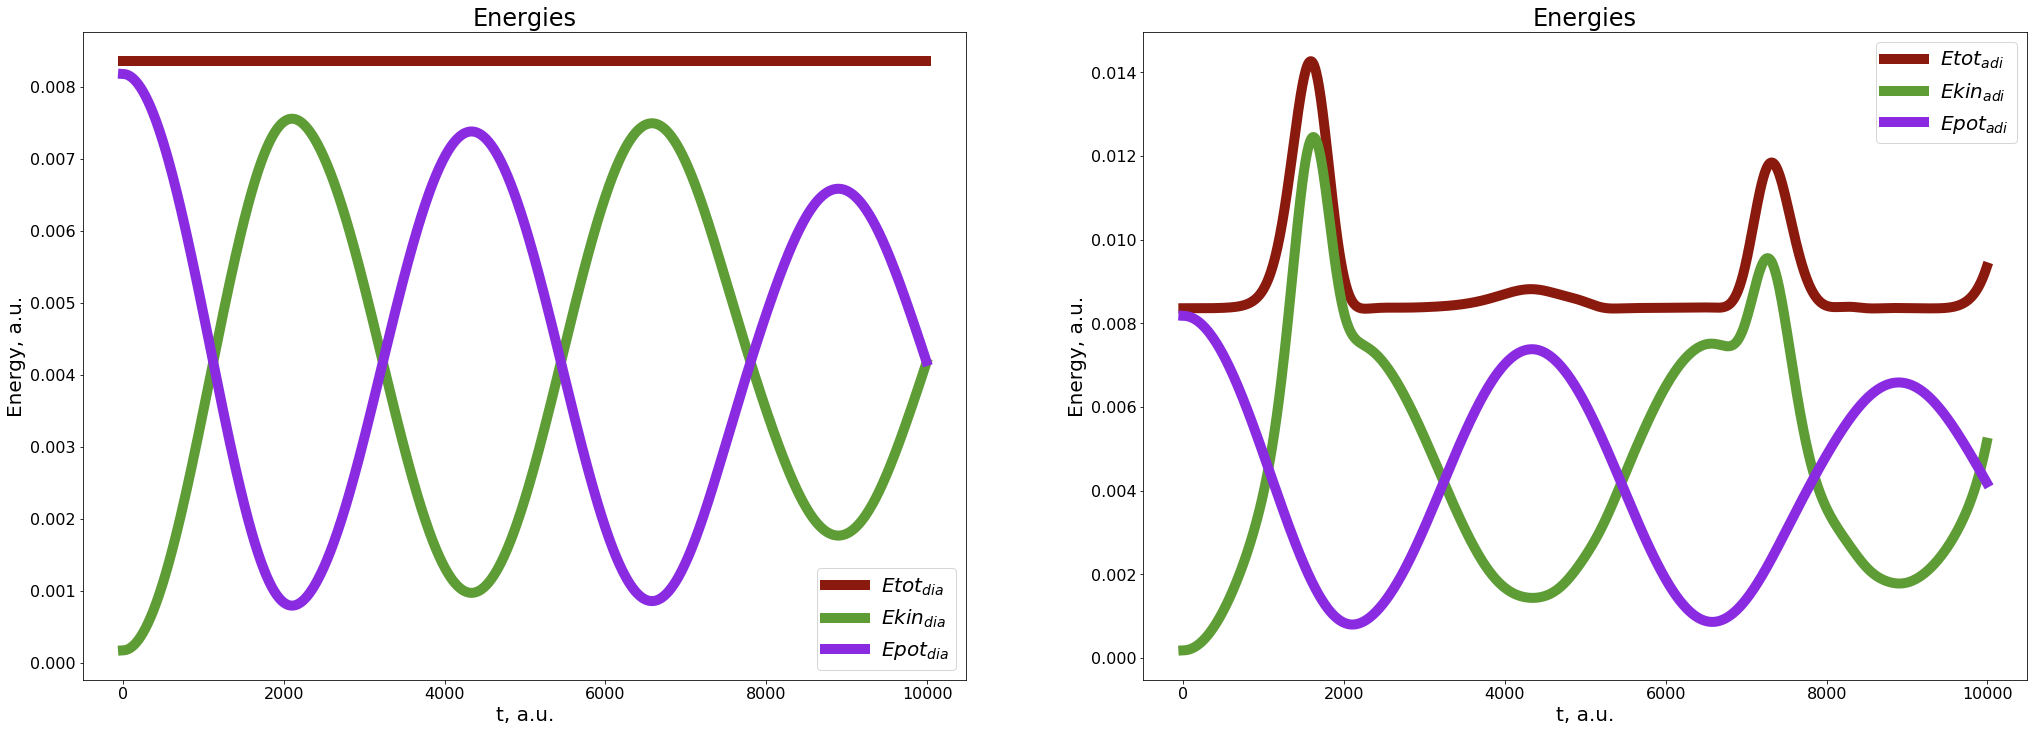

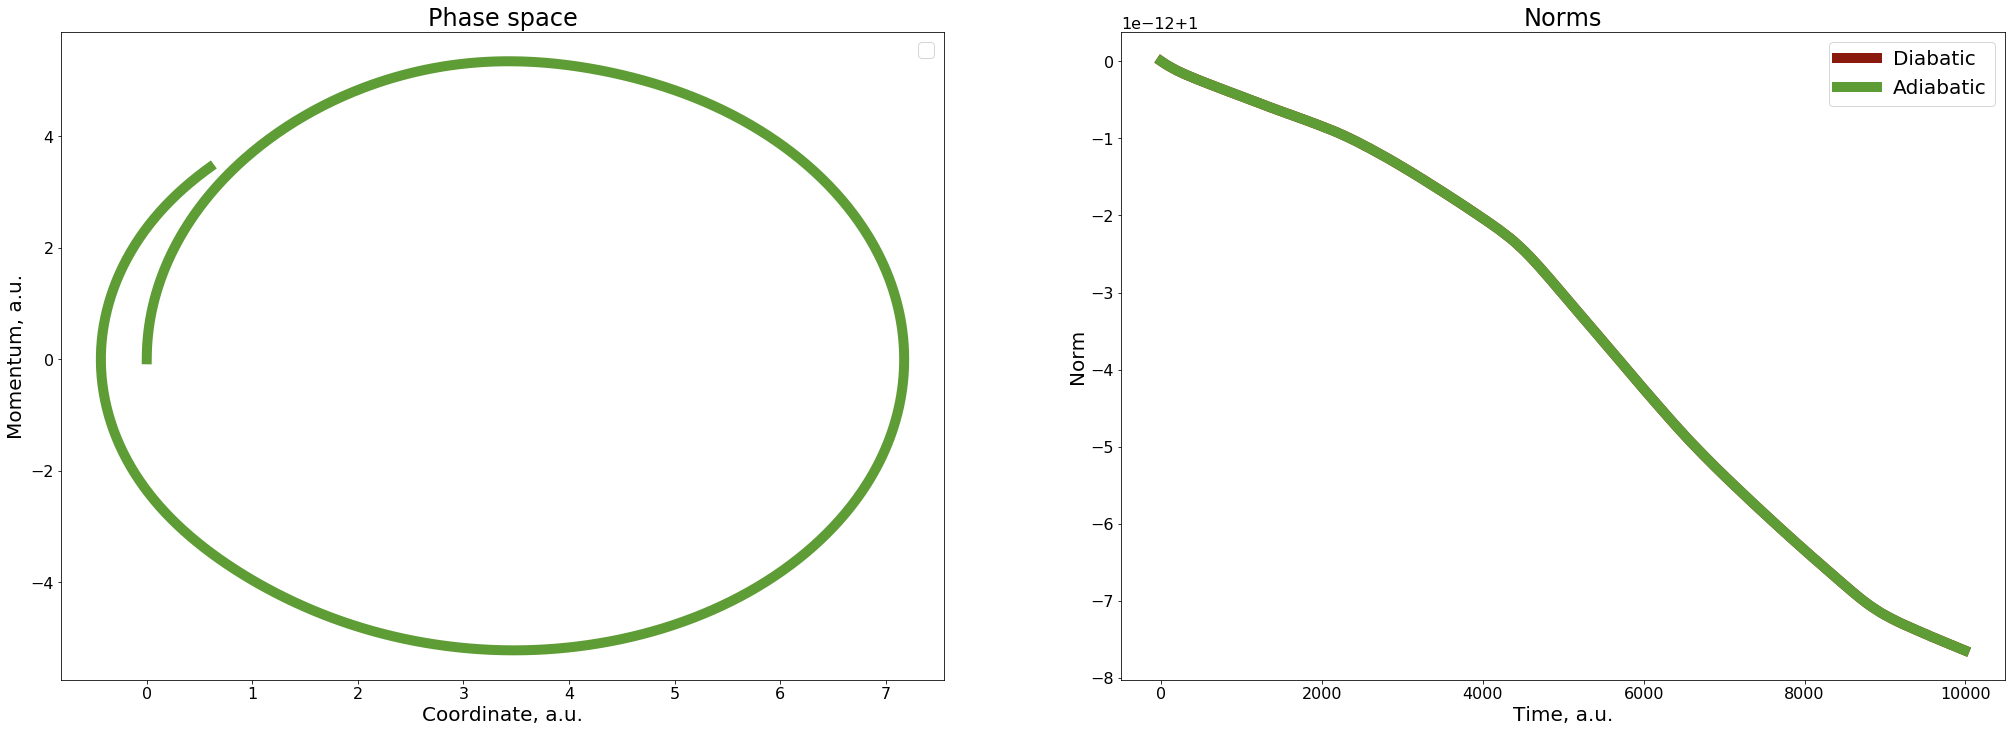

In [18]:
prefix = "Tut3-case-6"

model_params = dict(param_sets[1])
x0 = [0.0]
istate = [0, 0]  # diabatic state 0


run_case(prefix, model_params, x0, istate)

### Case 7

Run calculations with the dynamical parameters  {'nsteps': 1000, 'dt': 10.0, 'progress_frequency': 0.1, 'rmin': [-15.0], 'rmax': [15.0], 'dx': [0.1], 'nstates': 2, 'x0': [-5.0], 'p0': [0.0], 'istate': [1, 0], 'masses': [2000.0], 'k': [0.001], 'integrator': 'SOFT', 'prefix': 'Tut3-case-7', 'hdf5_output_level': 2, 'compression_level': [0, 0, 0], 'use_compression': 1, 'mem_output_level': 0, 'txt_output_level': 0, 'properties_to_save': ['timestep', 'time', 'Ekin_dia', 'Ekin_adi', 'Epot_dia', 'Epot_adi', 'Etot_dia', 'Etot_adi', 'norm_dia', 'norm_adi', 'pop_dia', 'pop_adi', 'q_dia', 'q_adi', 'p_dia', 'p_adi']}
Run calculations with the model parameters  {'model': 1, 'E_n': [0.0, -0.001], 'x_n': [4.0, 0.0], 'k_n': [0.001, 0.001], 'V': 0.0005}
Norm (dia) =  0.9999999999999999
Norm (adi) =  0.9999999999999997
Ekin (dia) =  0.00017677820768301536
Ekin (adi) =  0.00017677669529663644
Epot (dia) =  0.01166809947844
Epot (adi) =  0.011668099478440002
 step= 0
 step= 100
 step= 200
 step= 300
 step=

/home/alexey/miniconda2/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


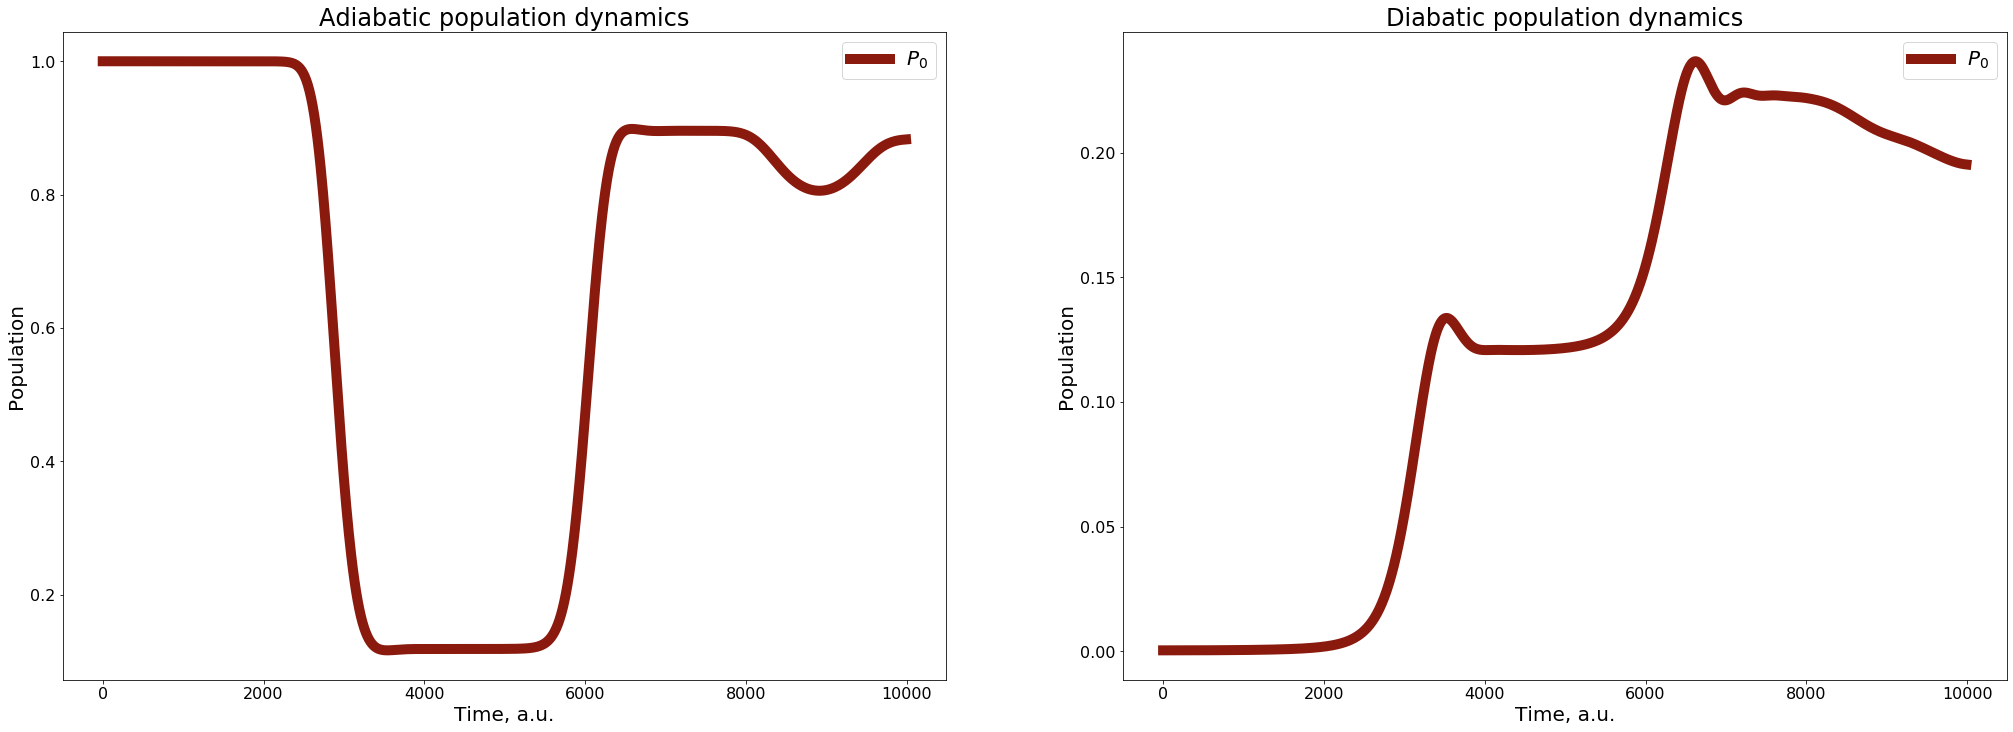

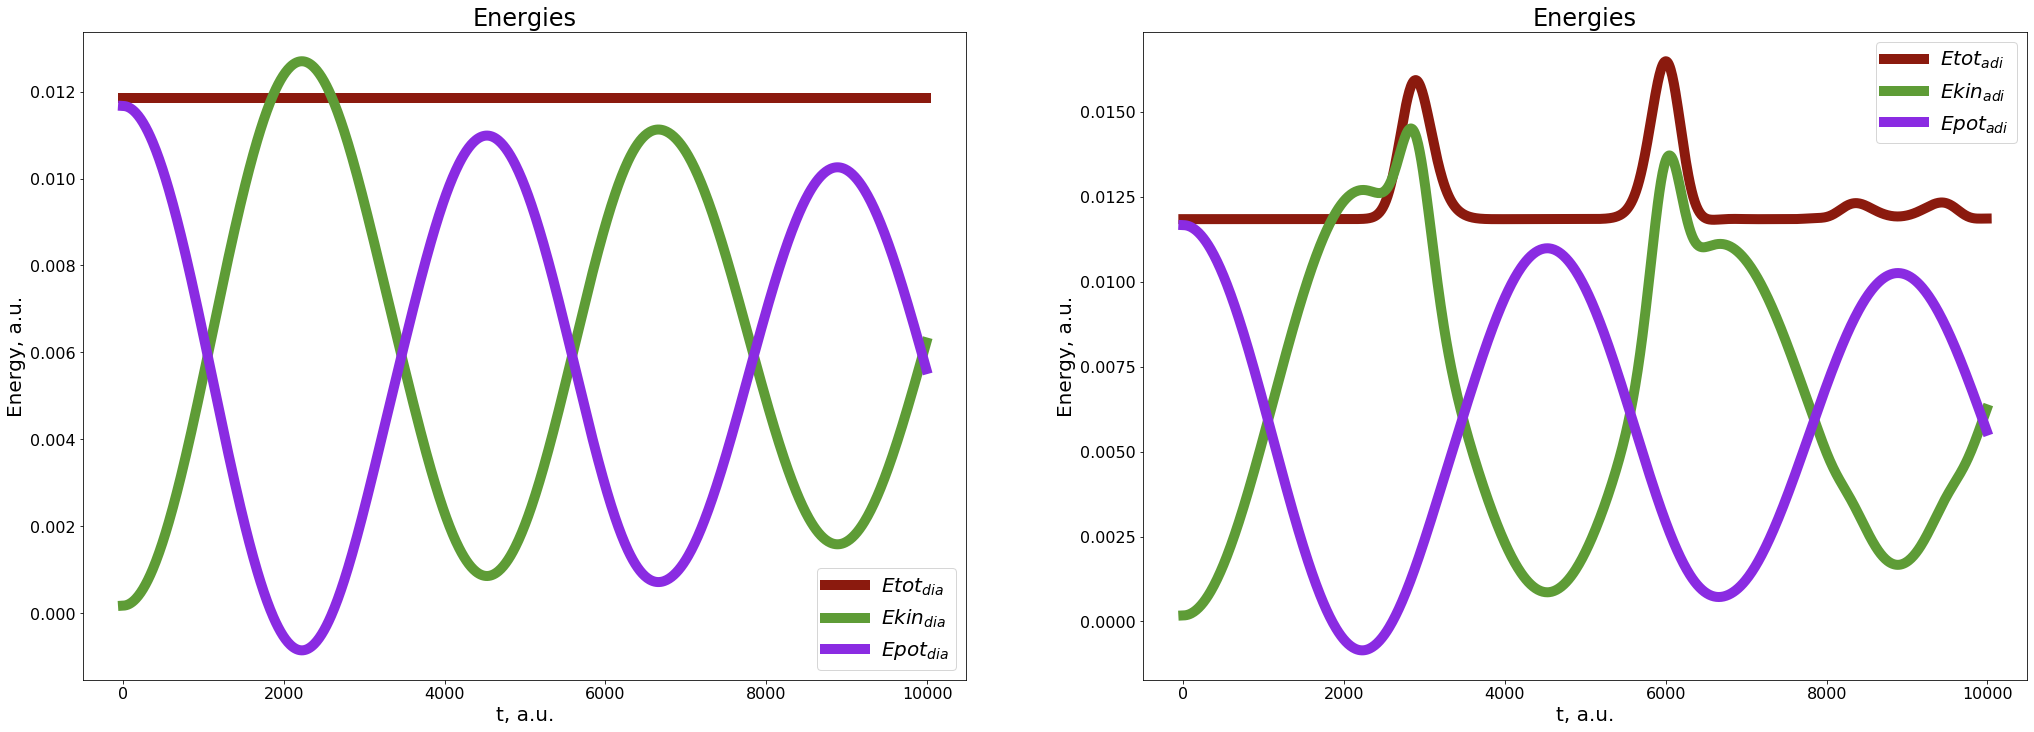

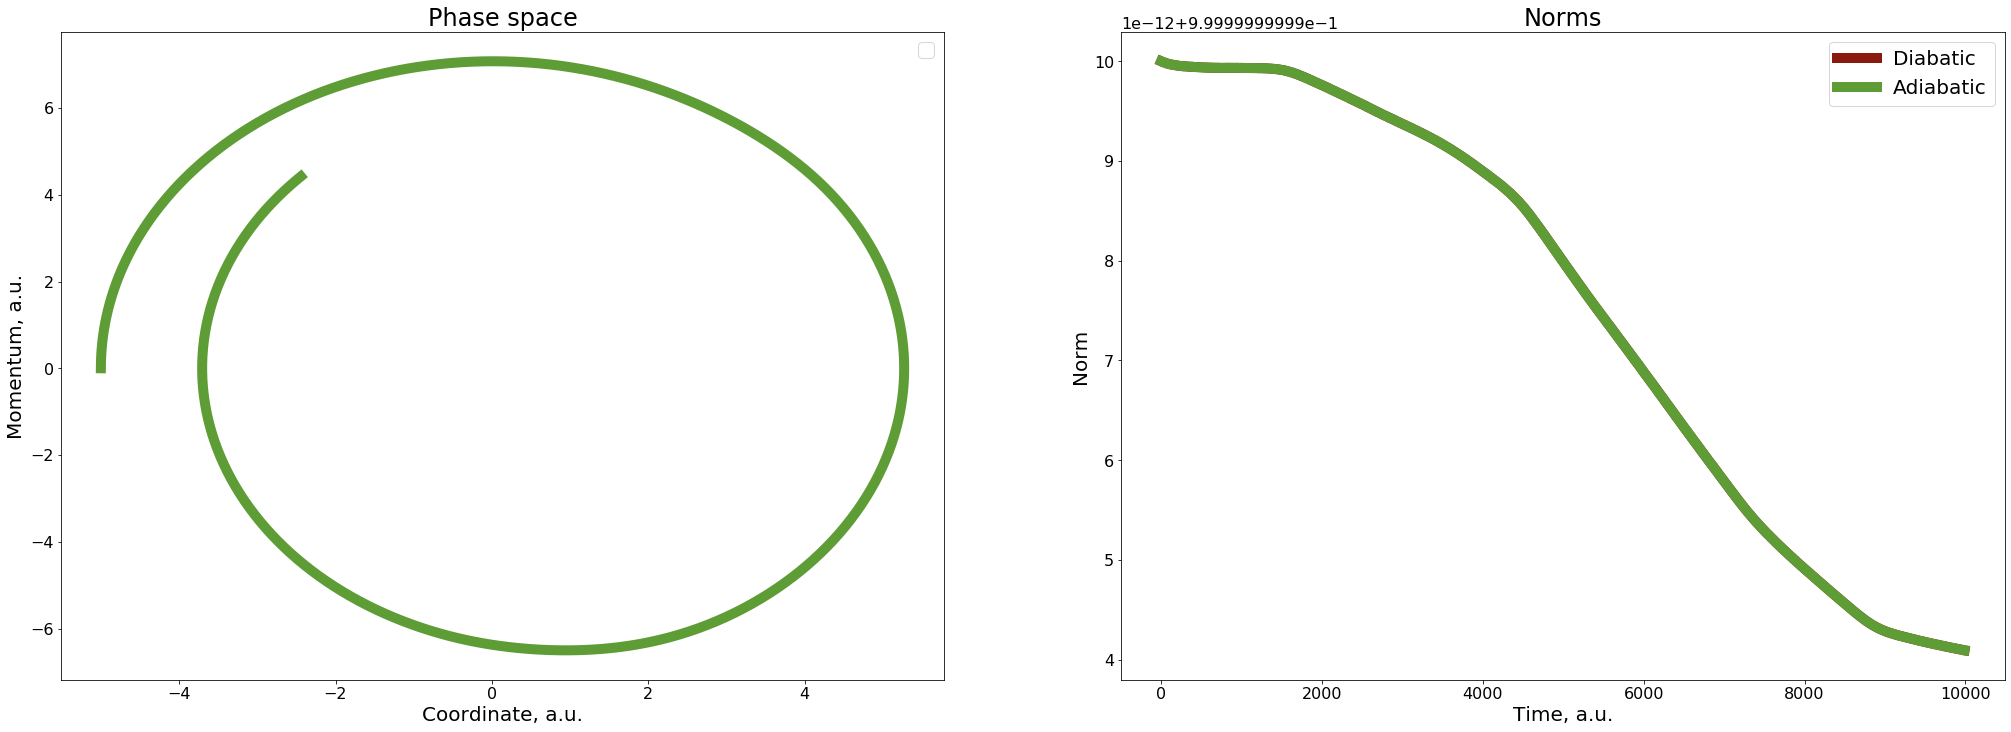

In [19]:
prefix = "Tut3-case-7"

model_params = dict(param_sets[1])
x0 = [-5.0]
istate = [1, 0]  # adiabatic state 0


run_case(prefix, model_params, x0, istate)

### Case 8

Run calculations with the dynamical parameters  {'nsteps': 1000, 'dt': 10.0, 'progress_frequency': 0.1, 'rmin': [-15.0], 'rmax': [15.0], 'dx': [0.1], 'nstates': 2, 'x0': [-5.0], 'p0': [0.0], 'istate': [0, 0], 'masses': [2000.0], 'k': [0.001], 'integrator': 'SOFT', 'prefix': 'Tut3-case-8', 'hdf5_output_level': 2, 'compression_level': [0, 0, 0], 'use_compression': 1, 'mem_output_level': 0, 'txt_output_level': 0, 'properties_to_save': ['timestep', 'time', 'Ekin_dia', 'Ekin_adi', 'Epot_dia', 'Epot_adi', 'Etot_dia', 'Etot_adi', 'norm_dia', 'norm_adi', 'pop_dia', 'pop_adi', 'q_dia', 'q_adi', 'p_dia', 'p_adi']}
Run calculations with the model parameters  {'model': 1, 'E_n': [0.0, -0.001], 'x_n': [4.0, 0.0], 'k_n': [0.001, 0.001], 'V': 0.0005}
Norm (dia) =  0.9999999999999997
Norm (adi) =  0.9999999999999999
Ekin (dia) =  0.00017677669529663644
Ekin (adi) =  0.0001767782076830154
Epot (dia) =  0.04067677669529666
Epot (adi) =  0.040676776695296644
 step= 0
 step= 100
 step= 200
 step= 300
 ste

/home/alexey/miniconda2/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


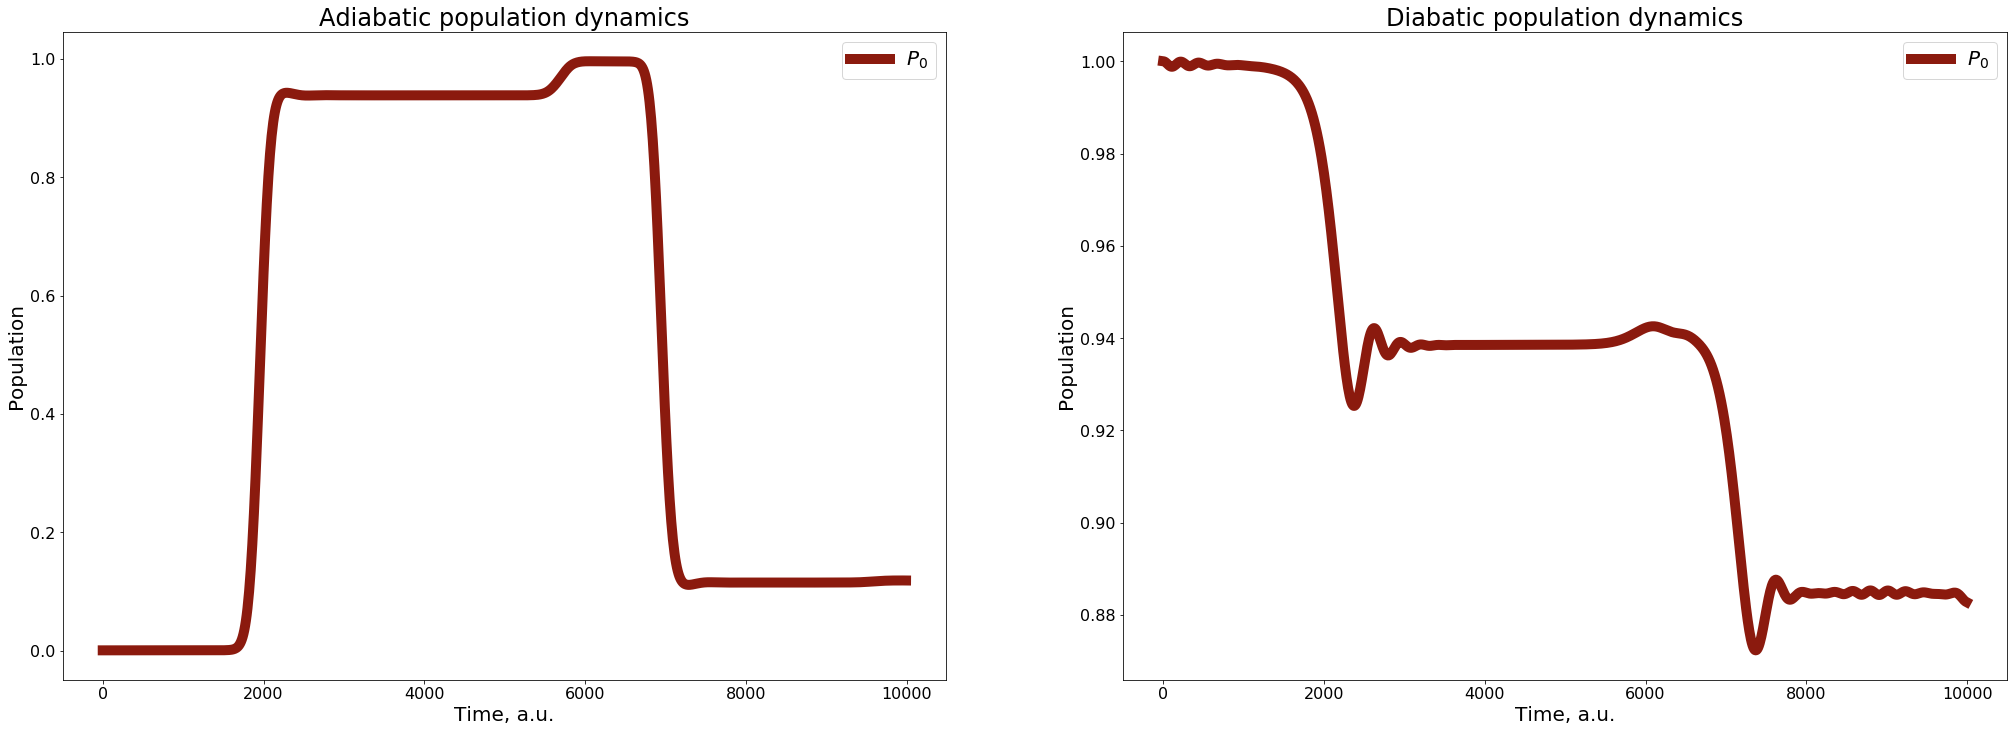

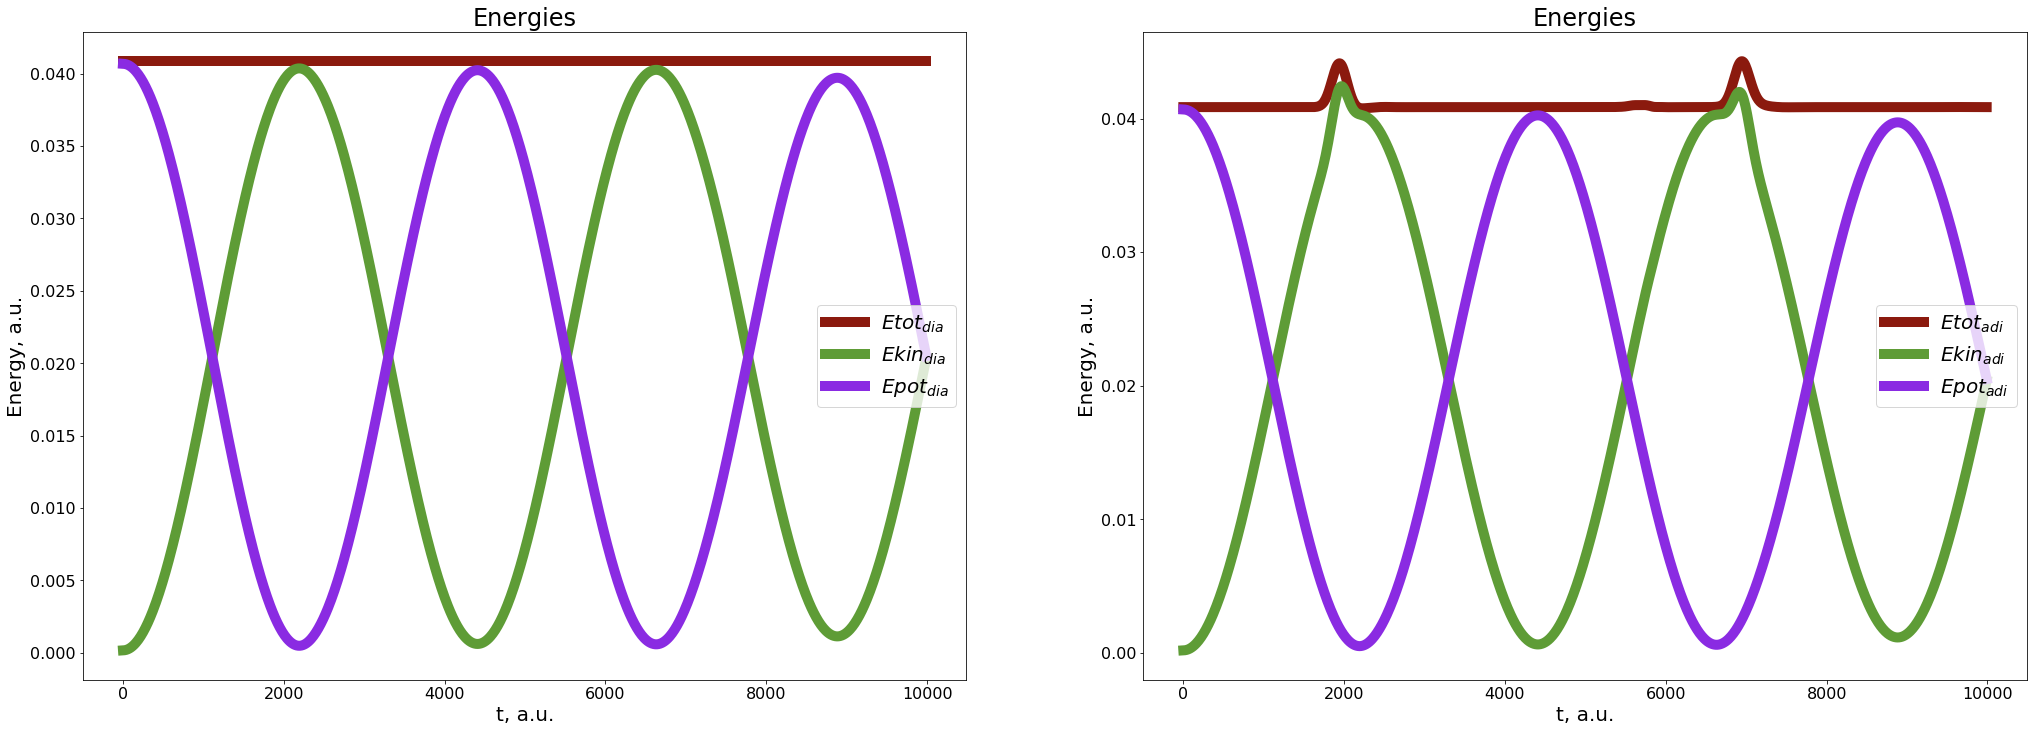

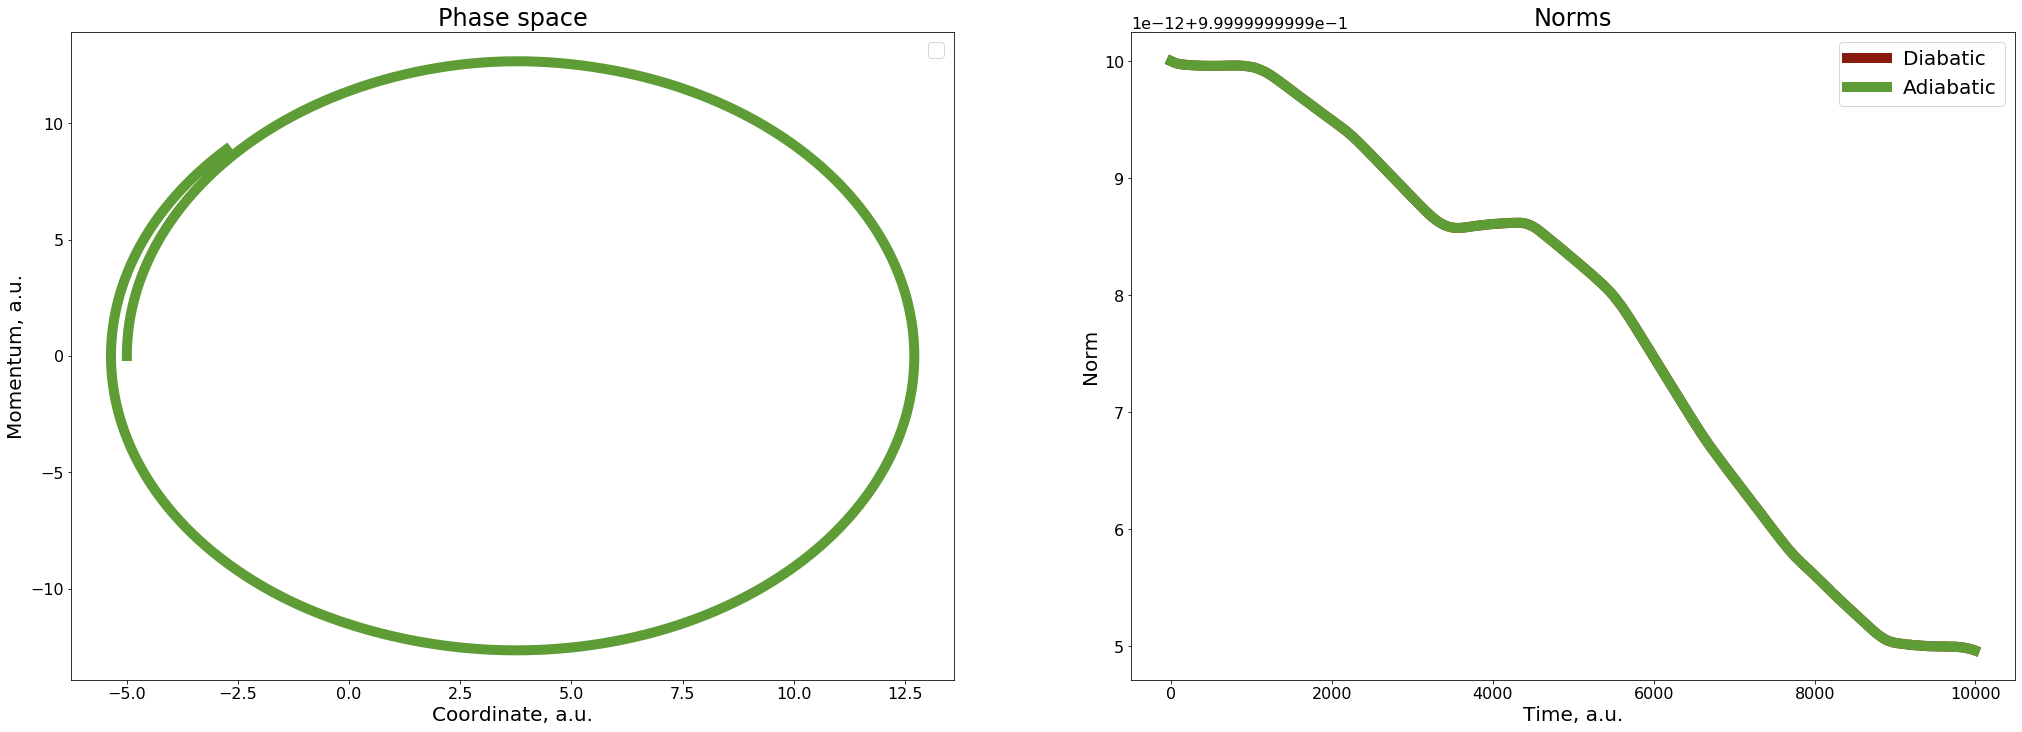

In [20]:
prefix = "Tut3-case-8"

model_params = dict(param_sets[1])
x0 = [-5.0]
istate = [0, 0]  # adiabatic state 0


run_case(prefix, model_params, x0, istate)

## Model 3

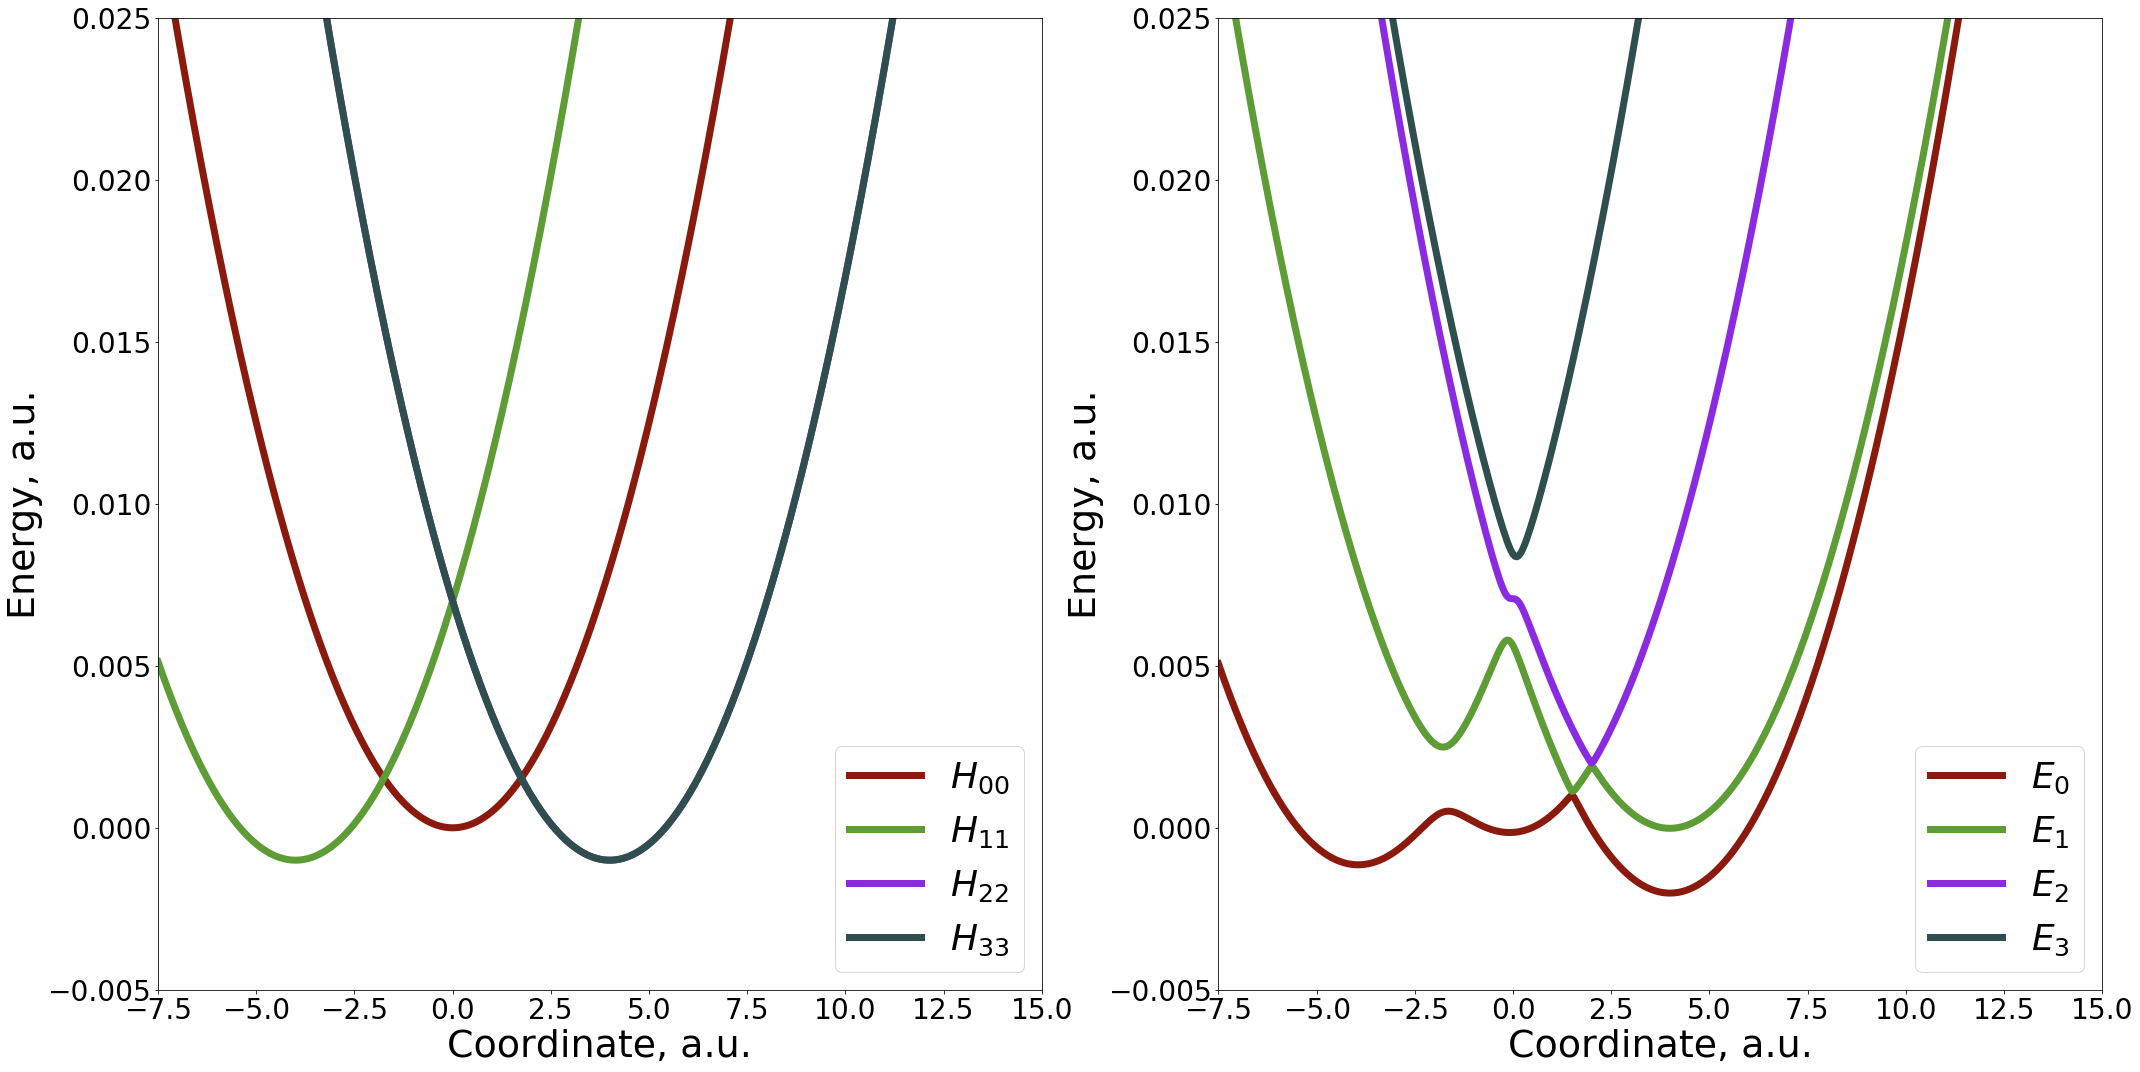

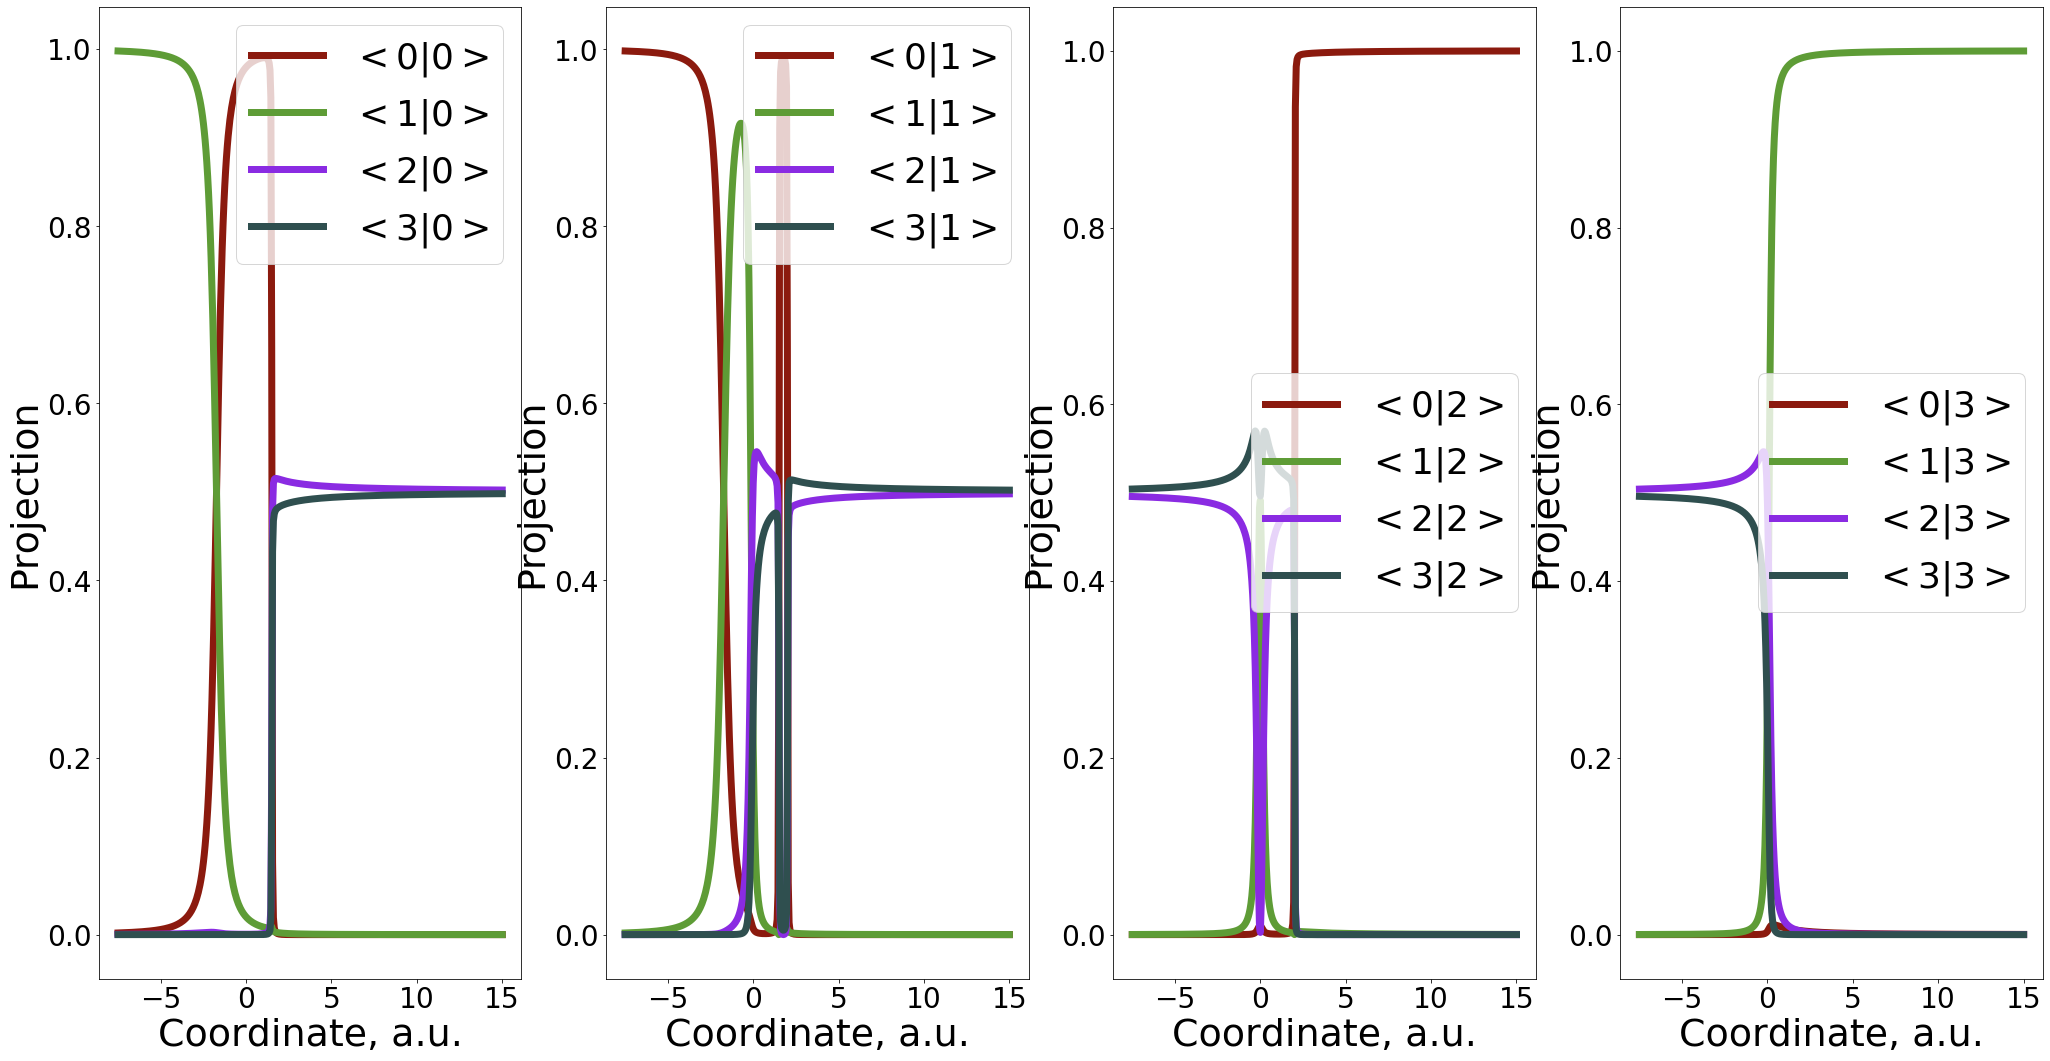

In [21]:
plot_params = {"colors": colors, "clrs_index": clrs_index}
dynamics_plotting.plot_surfaces(compute_model, [ param_sets[2] ], [0,1,2,3], -7.5, 15.0, 0.05, plot_params)

### Case 9

Run calculations with the dynamical parameters  {'nsteps': 1000, 'dt': 10.0, 'progress_frequency': 0.1, 'rmin': [-15.0], 'rmax': [15.0], 'dx': [0.1], 'nstates': 4, 'x0': [0.0], 'p0': [0.0], 'istate': [1, 0], 'masses': [2000.0], 'k': [0.001], 'integrator': 'SOFT', 'prefix': 'Tut3-case-9', 'hdf5_output_level': 2, 'compression_level': [0, 0, 0], 'use_compression': 1, 'mem_output_level': 0, 'txt_output_level': 0, 'properties_to_save': ['timestep', 'time', 'Ekin_dia', 'Ekin_adi', 'Epot_dia', 'Epot_adi', 'Etot_dia', 'Etot_adi', 'norm_dia', 'norm_adi', 'pop_dia', 'pop_adi', 'q_dia', 'q_adi', 'p_dia', 'p_adi']}
Run calculations with the model parameters  {'model': 1, 'E_n': [0.0, -0.001, -0.001, -0.001], 'x_n': [0.0, -4.0, 4.0, 4.0], 'k_n': [0.001, 0.001, 0.001, 0.001], 'V': 0.001}
Norm (dia) =  1.0000000000000002
Norm (adi) =  1.0
Ekin (dia) =  0.0316703949773305
Ekin (adi) =  0.00017677669529663636
Epot (dia) =  6.647285062951907e-06
Epot (adi) =  6.647285062952012e-06
 step= 0
 step= 100
 s

/home/alexey/miniconda2/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


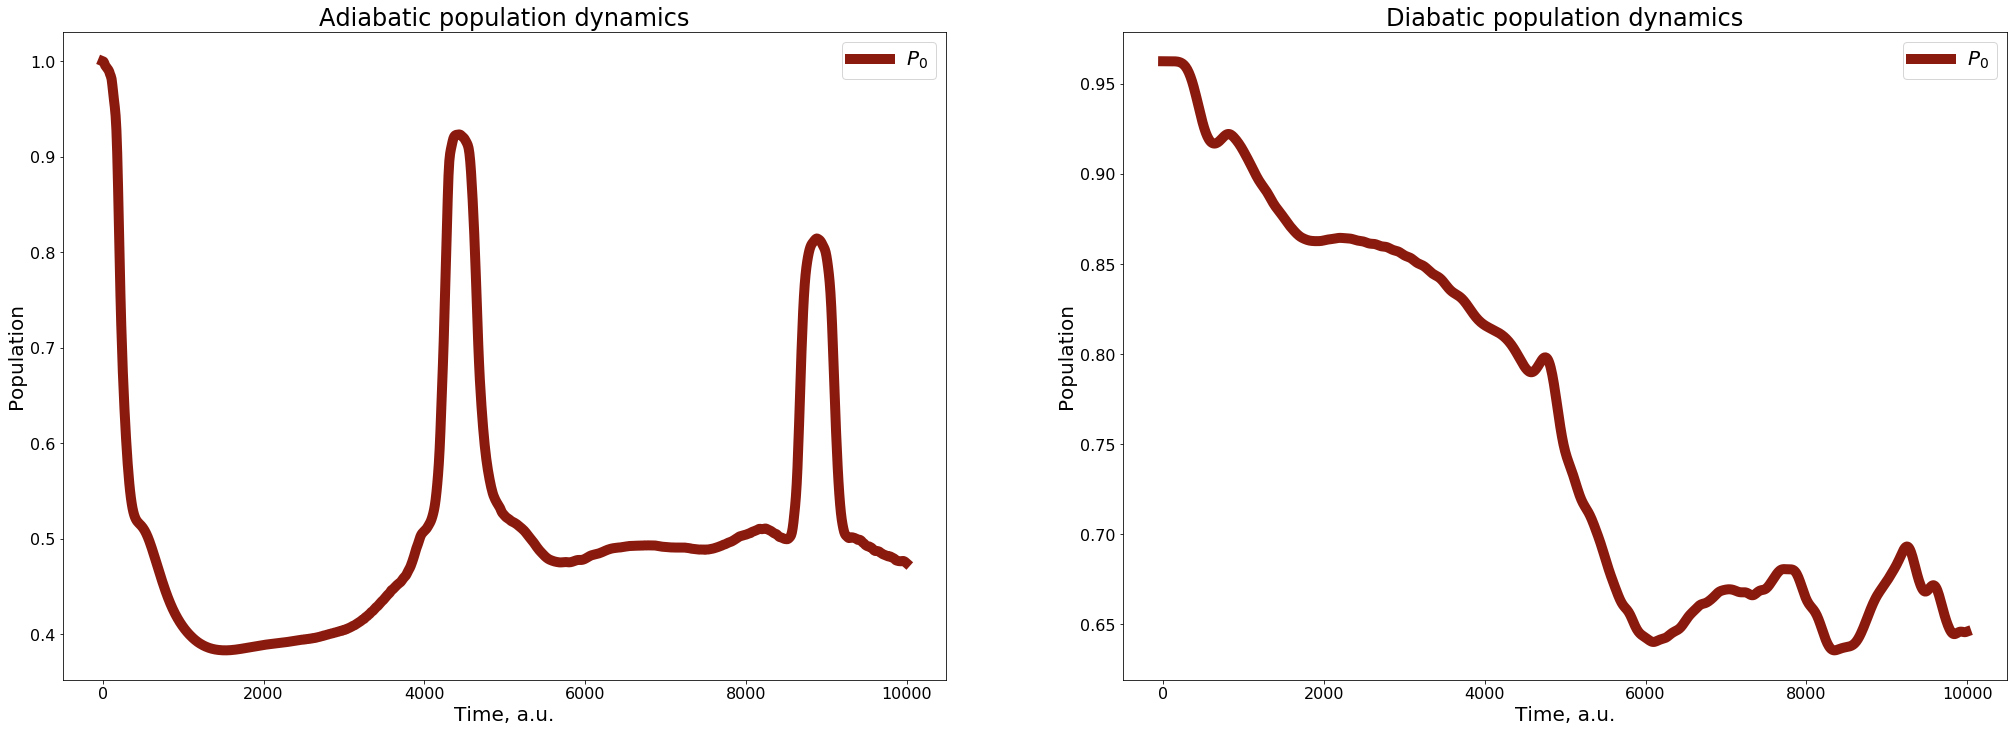

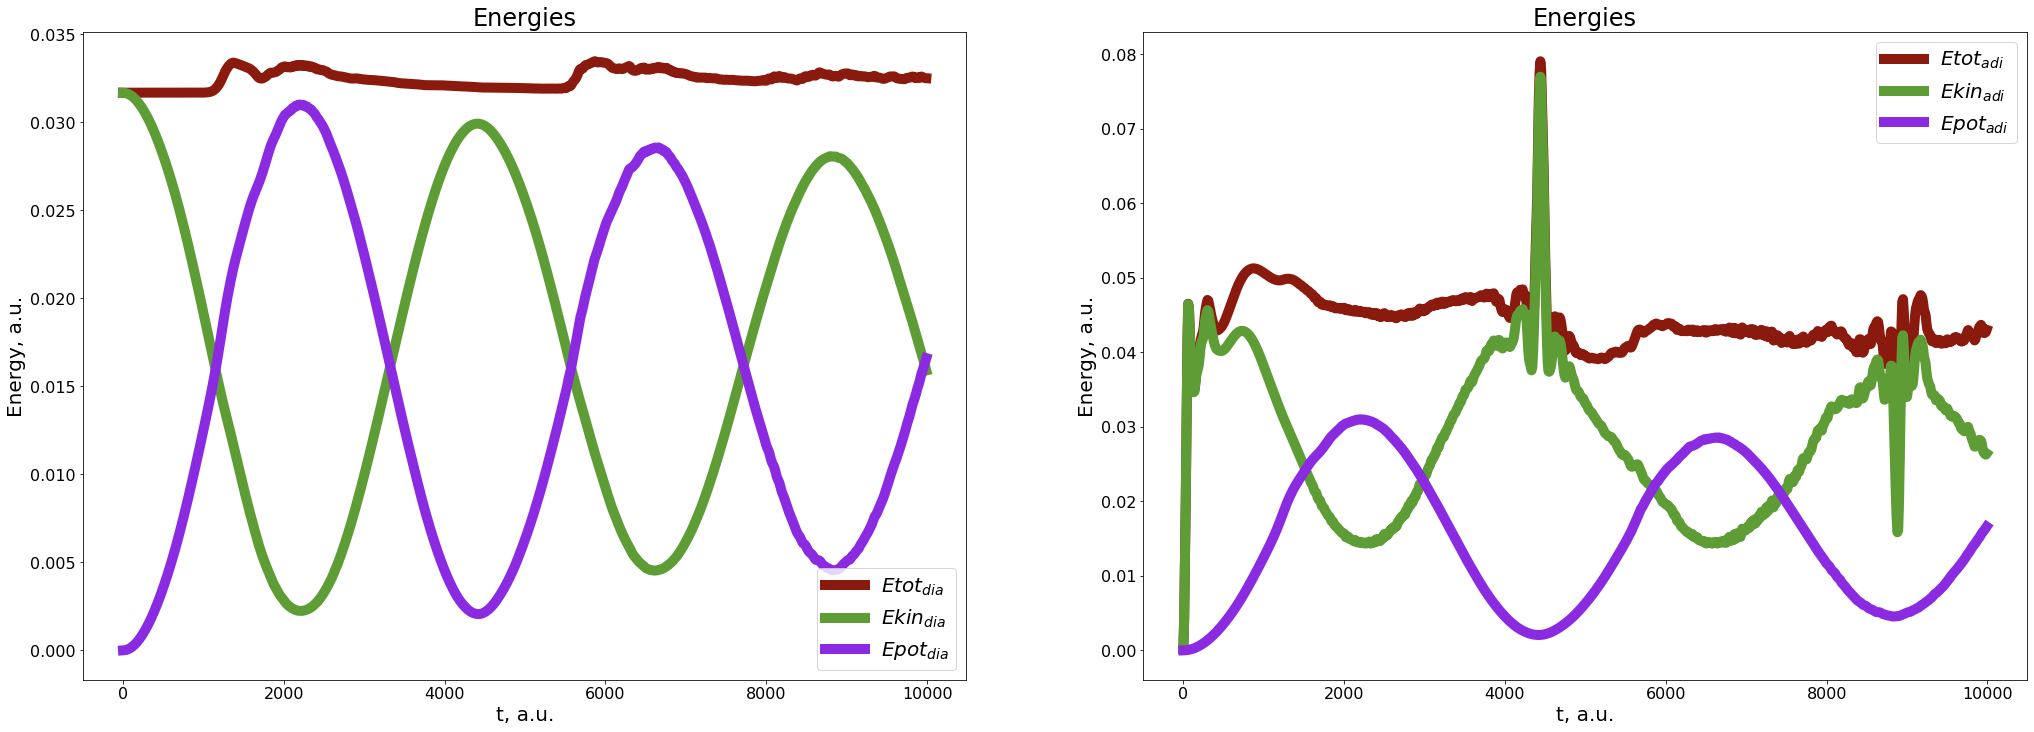

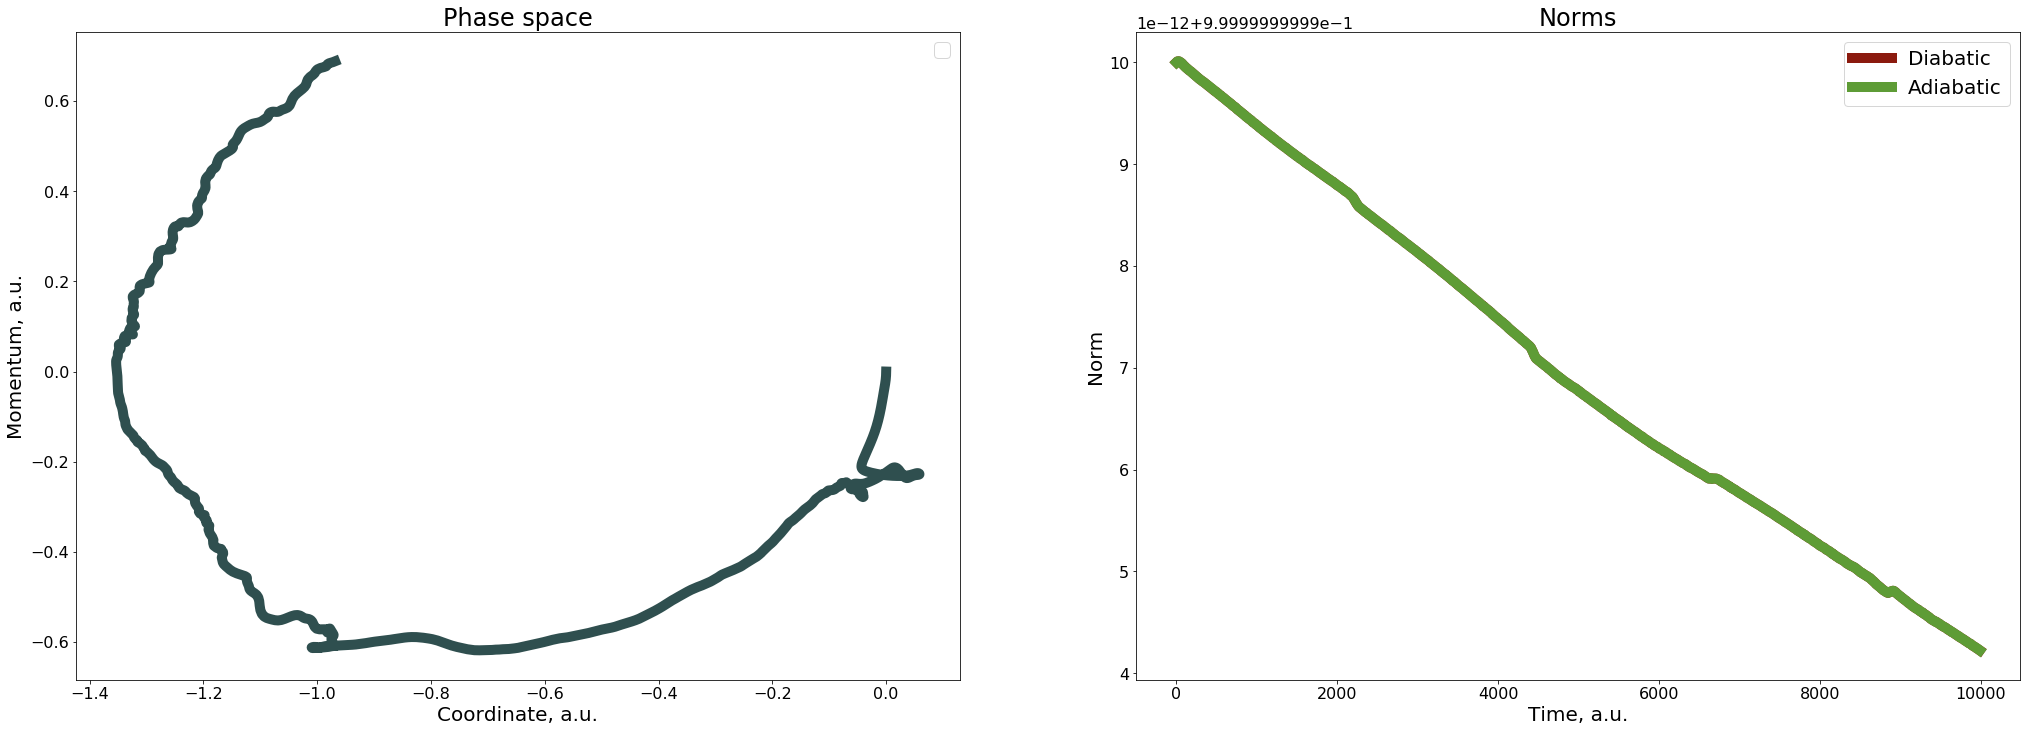

In [22]:
prefix = "Tut3-case-9"

model_params = dict(param_sets[2])
x0 = [0.0]
istate = [1, 0]  # adiabatic state 0

run_case(prefix, model_params, x0, istate)

/home/alexey/miniconda2/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


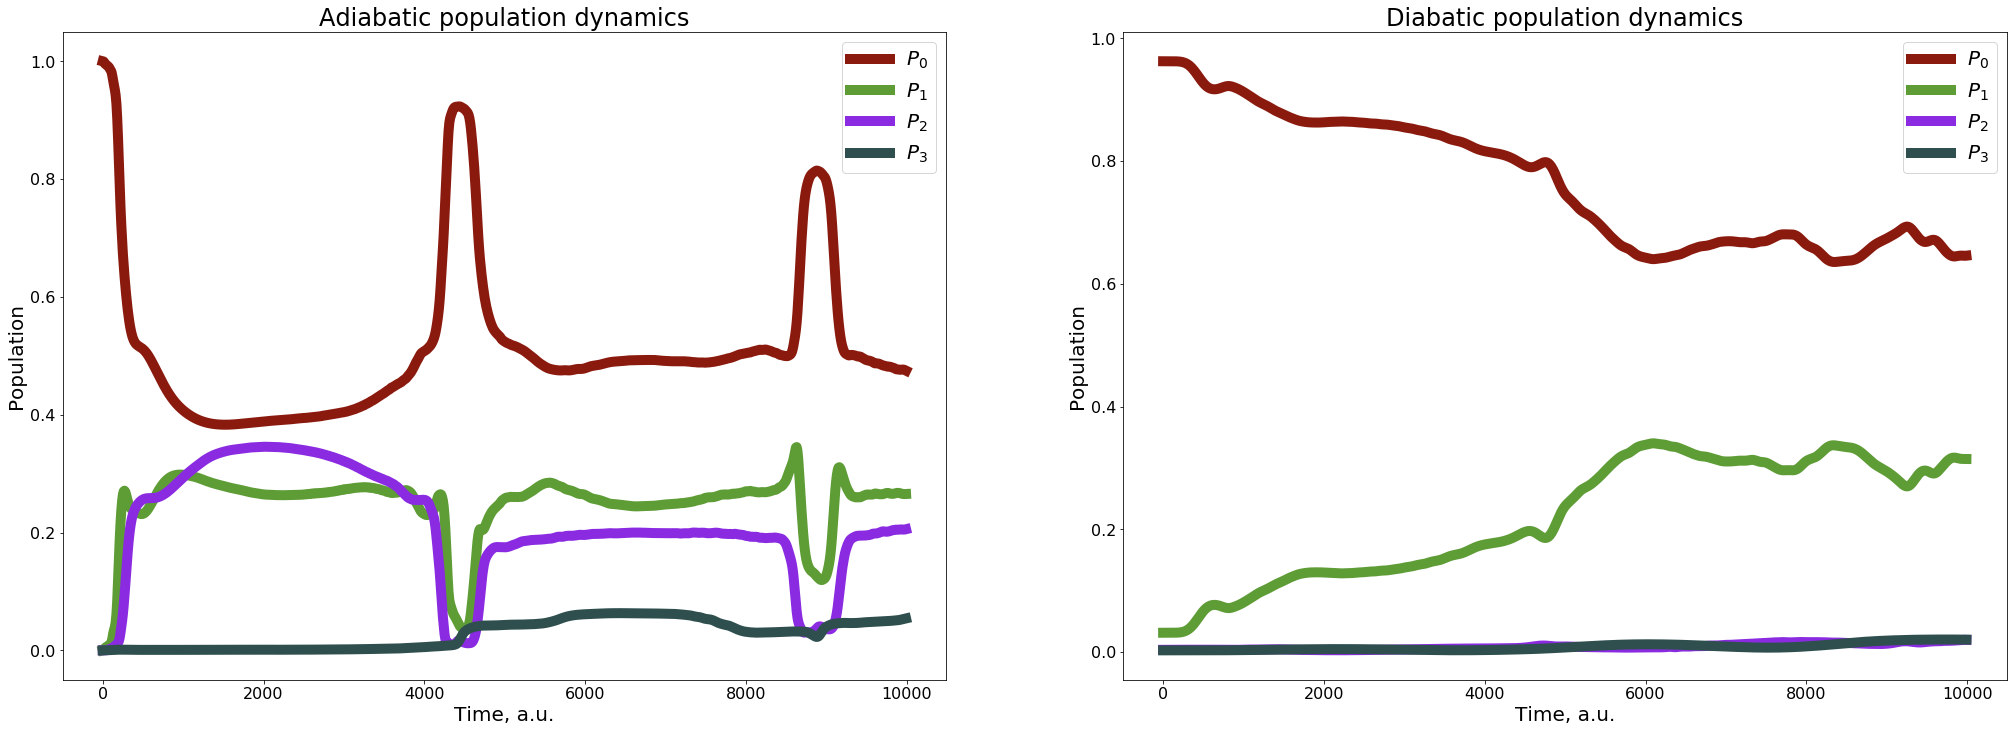

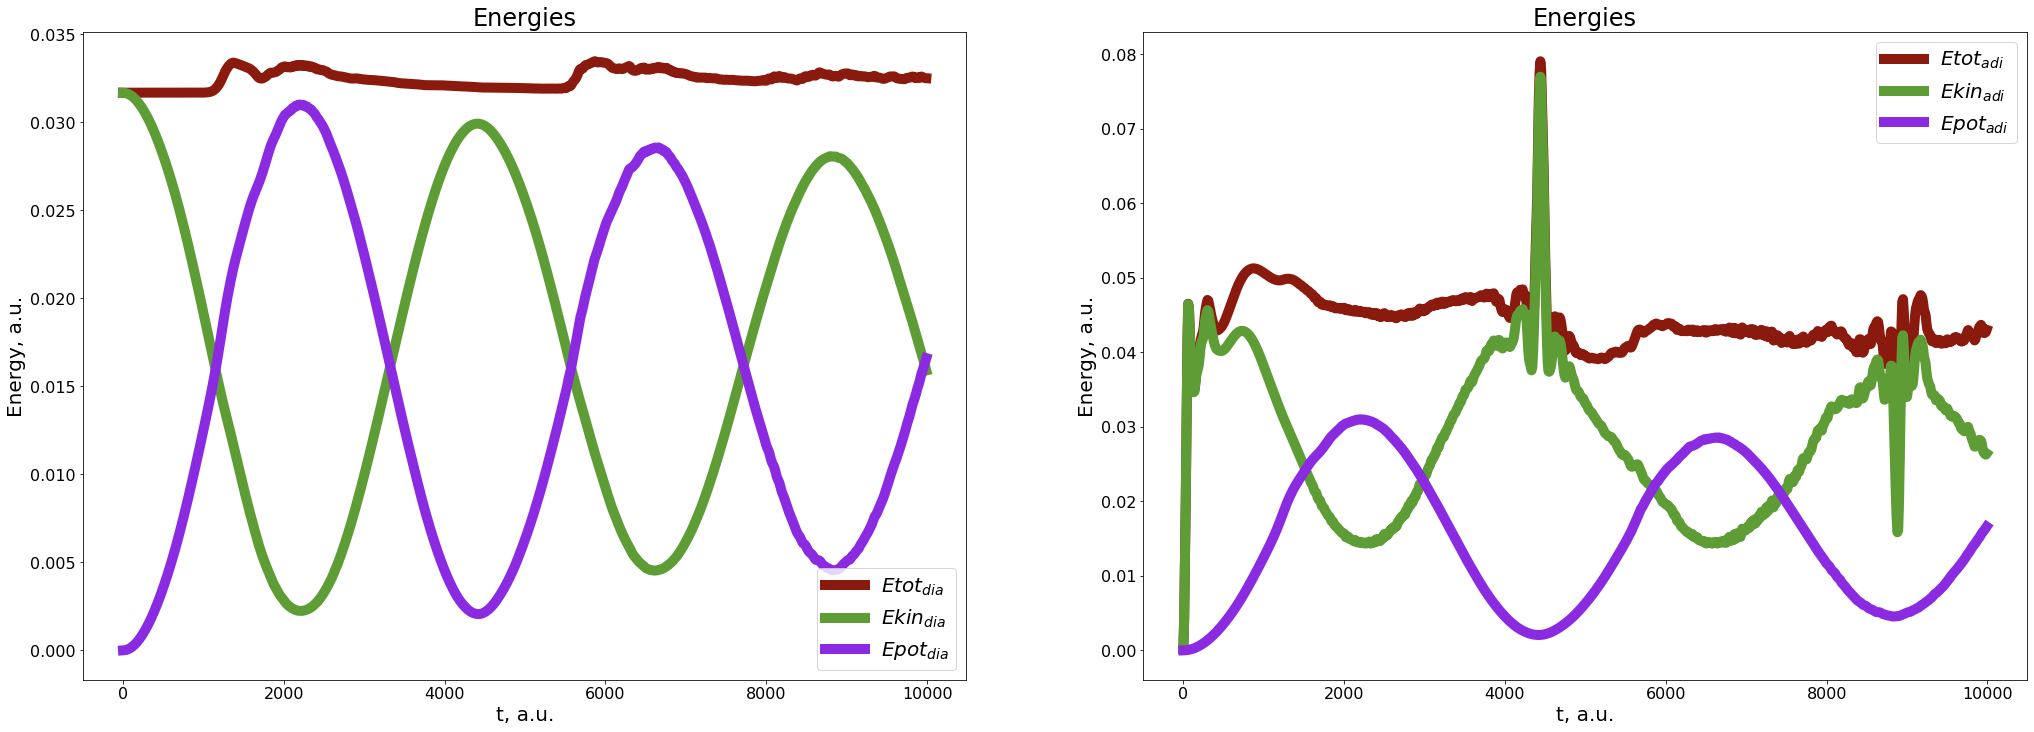

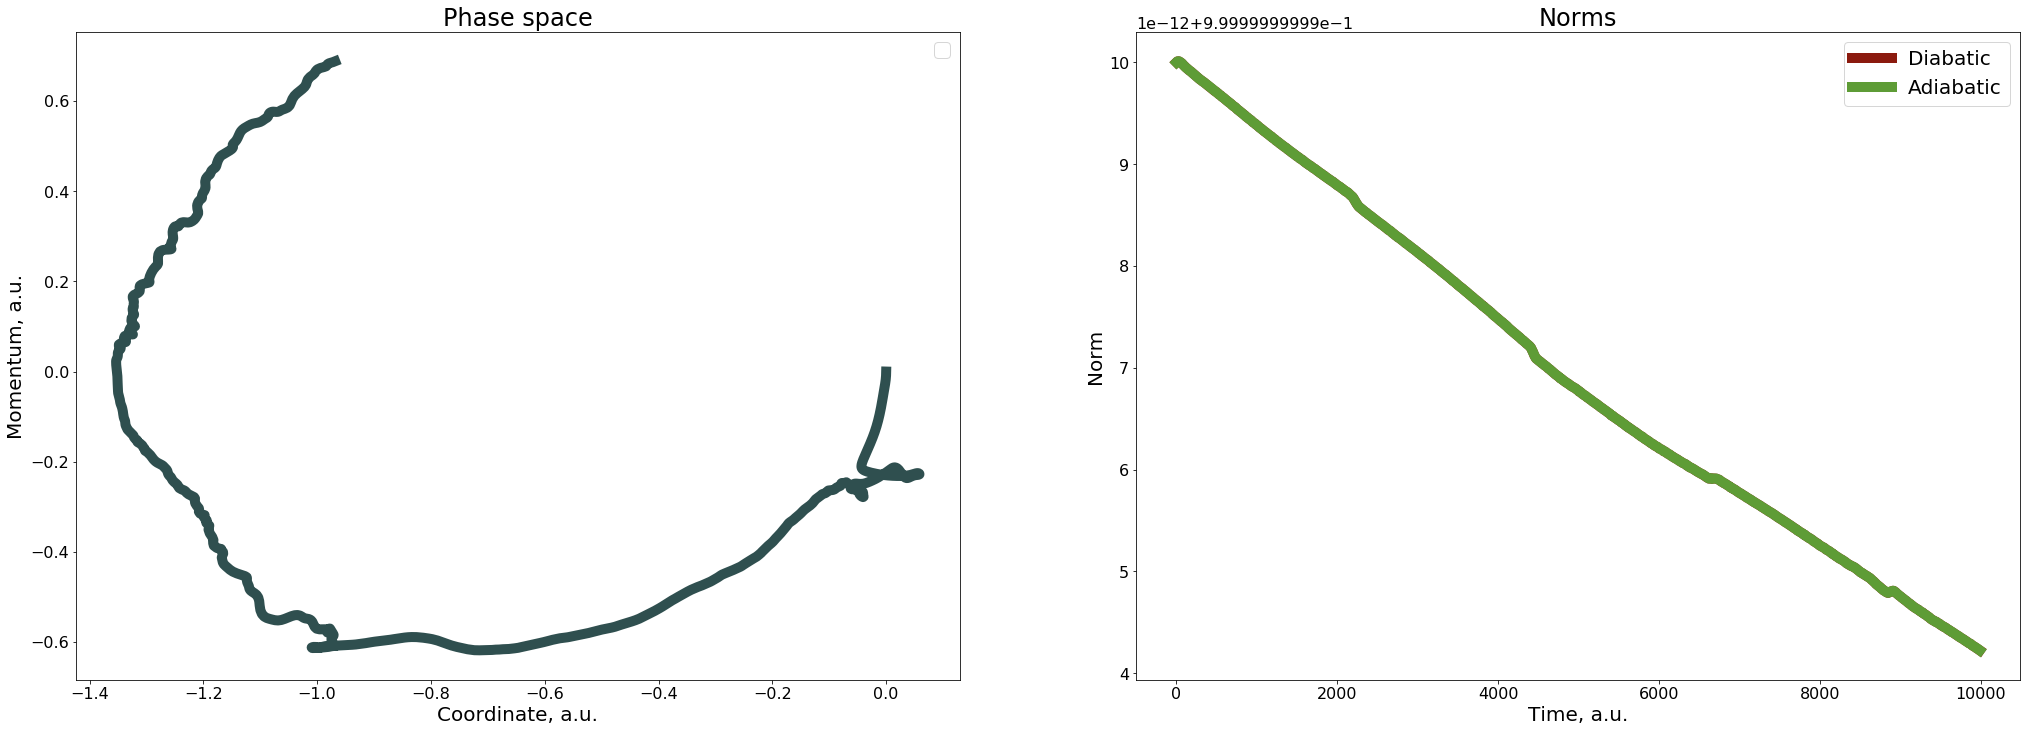

In [27]:
prefix = "Tut3-case-9"
plot_params1 = dict(plot_params)
plot_params1.update({"prefix":prefix, "which_adi_states":[0, 1, 2, 3], "which_dia_states":[0, 1, 2, 3]})
dynamics_exact.plot_hdf5(plot_params1)

### Case 10

Run calculations with the dynamical parameters  {'nsteps': 1000, 'dt': 10.0, 'progress_frequency': 0.1, 'rmin': [-15.0], 'rmax': [15.0], 'dx': [0.1], 'nstates': 4, 'x0': [0.0], 'p0': [0.0], 'istate': [0, 0], 'masses': [2000.0], 'k': [0.001], 'integrator': 'SOFT', 'prefix': 'Tut3-case-10', 'hdf5_output_level': 2, 'compression_level': [0, 0, 0], 'use_compression': 1, 'mem_output_level': 0, 'txt_output_level': 0, 'properties_to_save': ['timestep', 'time', 'Ekin_dia', 'Ekin_adi', 'Epot_dia', 'Epot_adi', 'Etot_dia', 'Etot_adi', 'norm_dia', 'norm_adi', 'pop_dia', 'pop_adi', 'q_dia', 'q_adi', 'p_dia', 'p_adi']}
Run calculations with the model parameters  {'model': 1, 'E_n': [0.0, -0.001, -0.001, -0.001], 'x_n': [0.0, -4.0, 4.0, 4.0], 'k_n': [0.001, 0.001, 0.001, 0.001], 'V': 0.001}
Norm (dia) =  1.0
Norm (adi) =  1.0
Ekin (dia) =  0.00017677669529663636
Ekin (adi) =  0.031950999717384125
Epot (dia) =  0.00017677669529663685
Epot (adi) =  0.000176776695296637
 step= 0
 step= 100
 step= 200
 st

/home/alexey/miniconda2/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


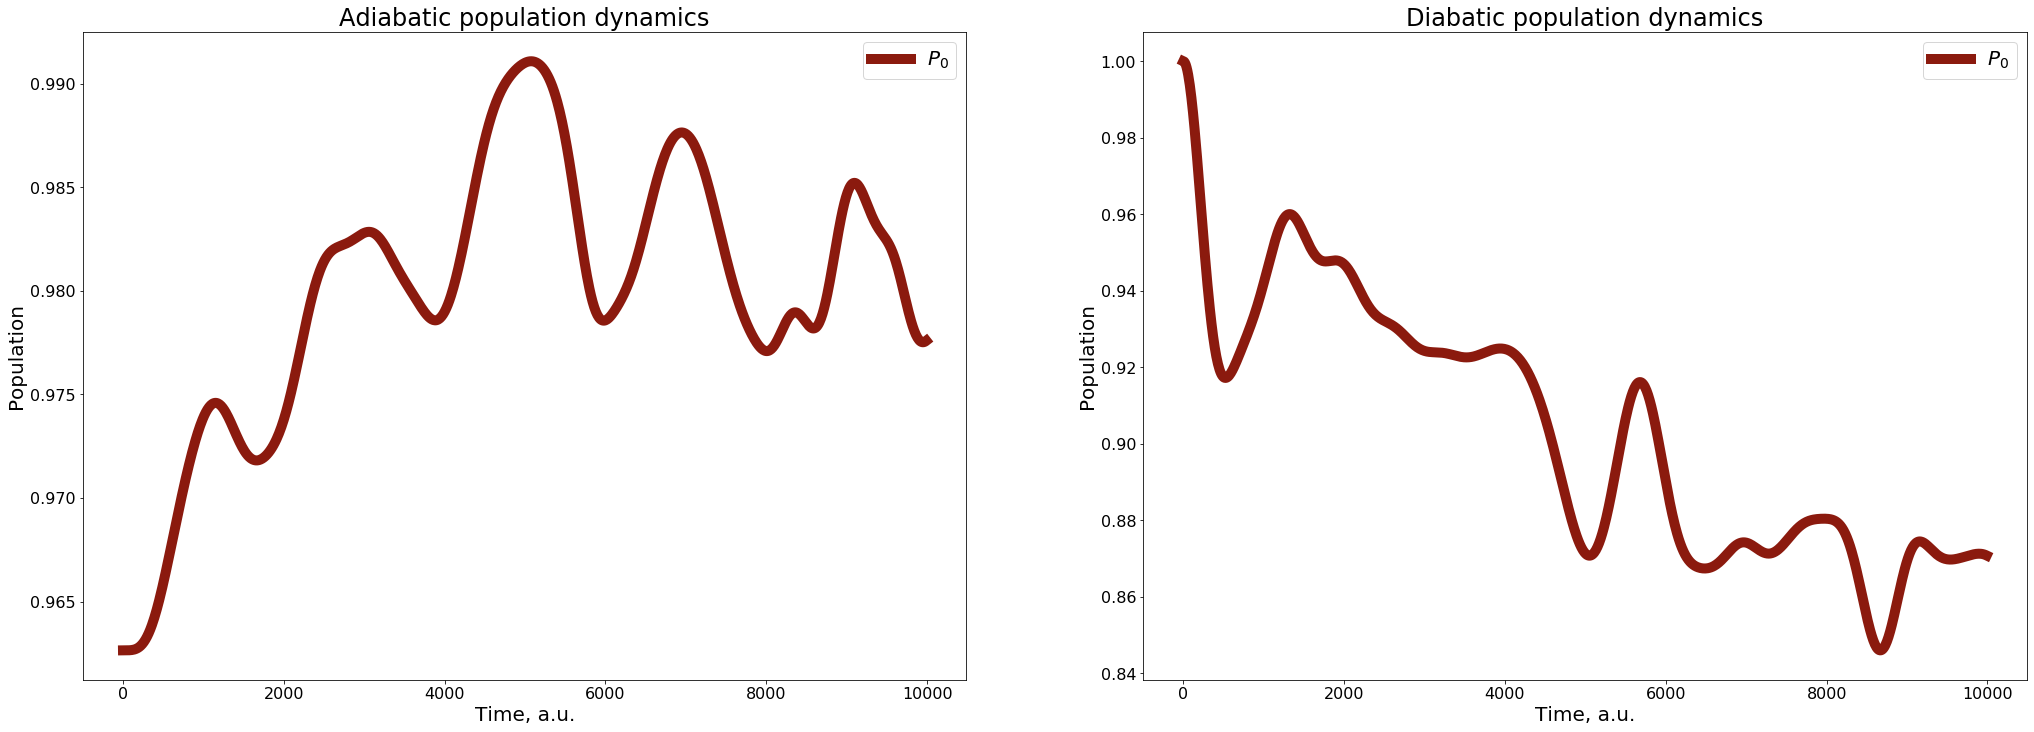

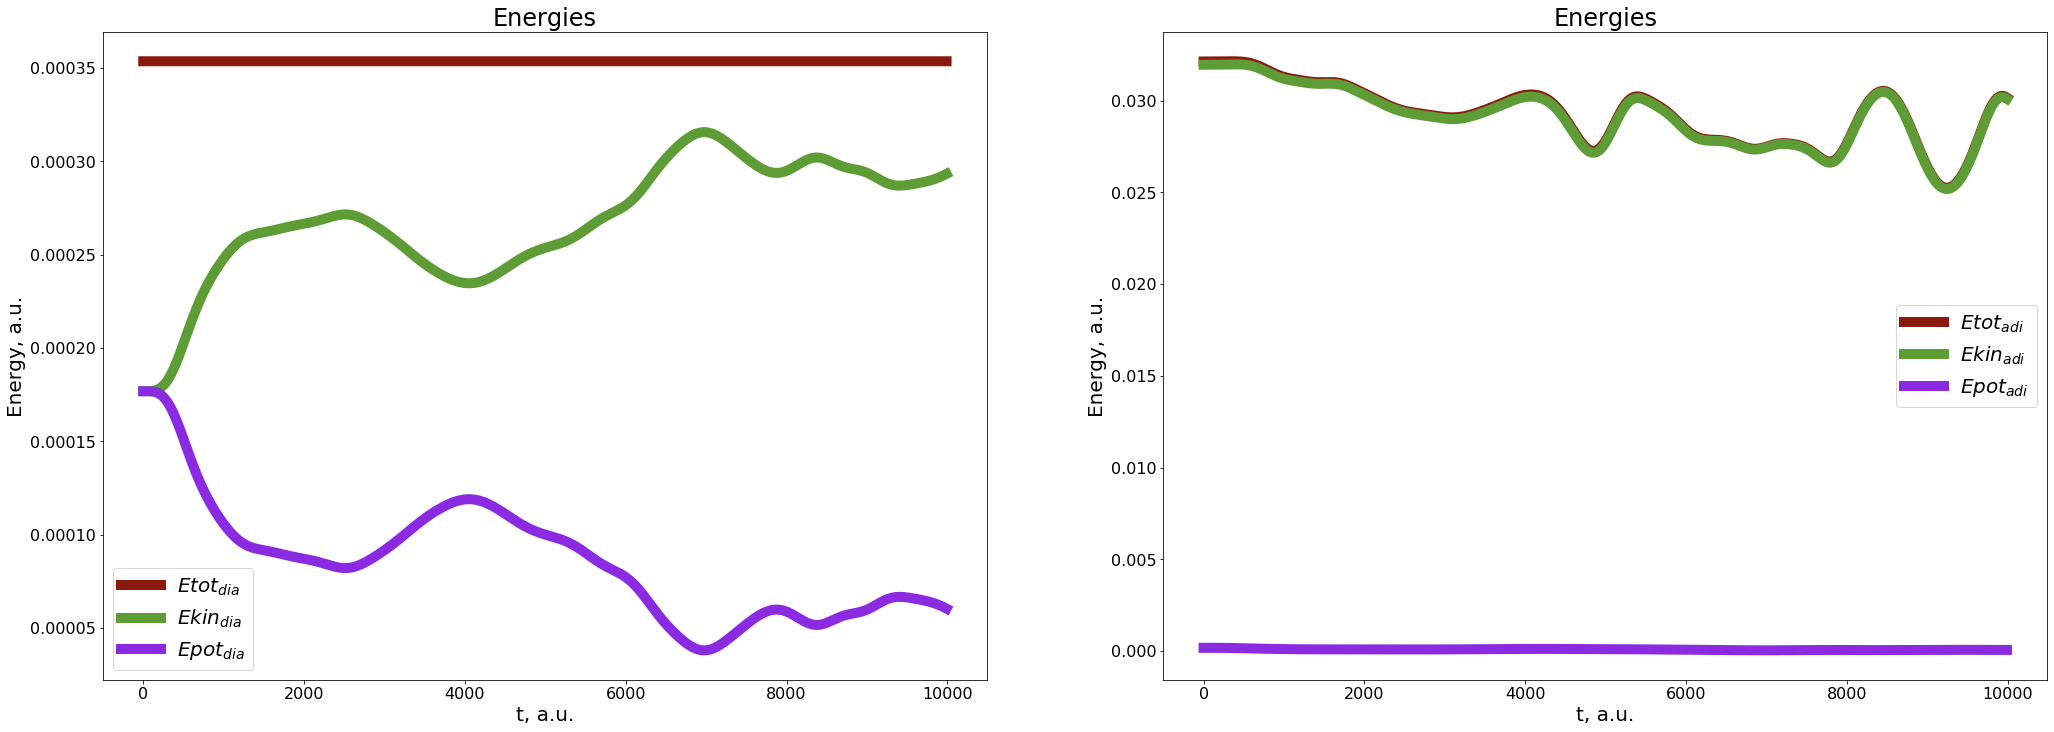

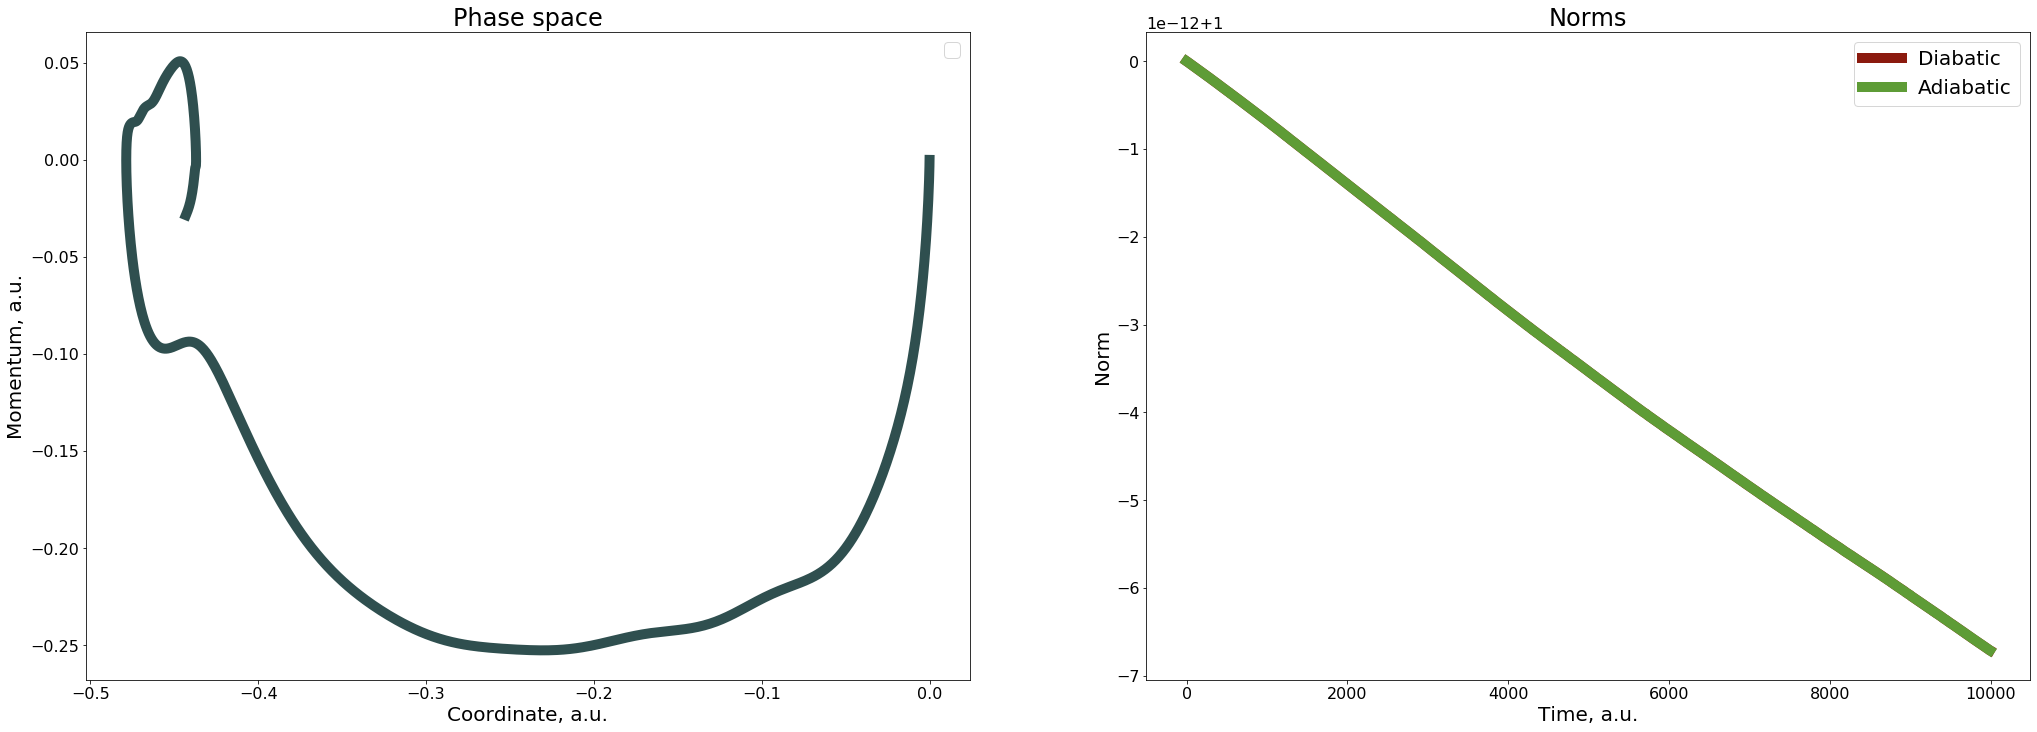

In [23]:
prefix = "Tut3-case-10"

model_params = dict(param_sets[2])
x0 = [0.0]
istate = [0, 0]  # diabatic state 0

run_case(prefix, model_params, x0, istate)

/home/alexey/miniconda2/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


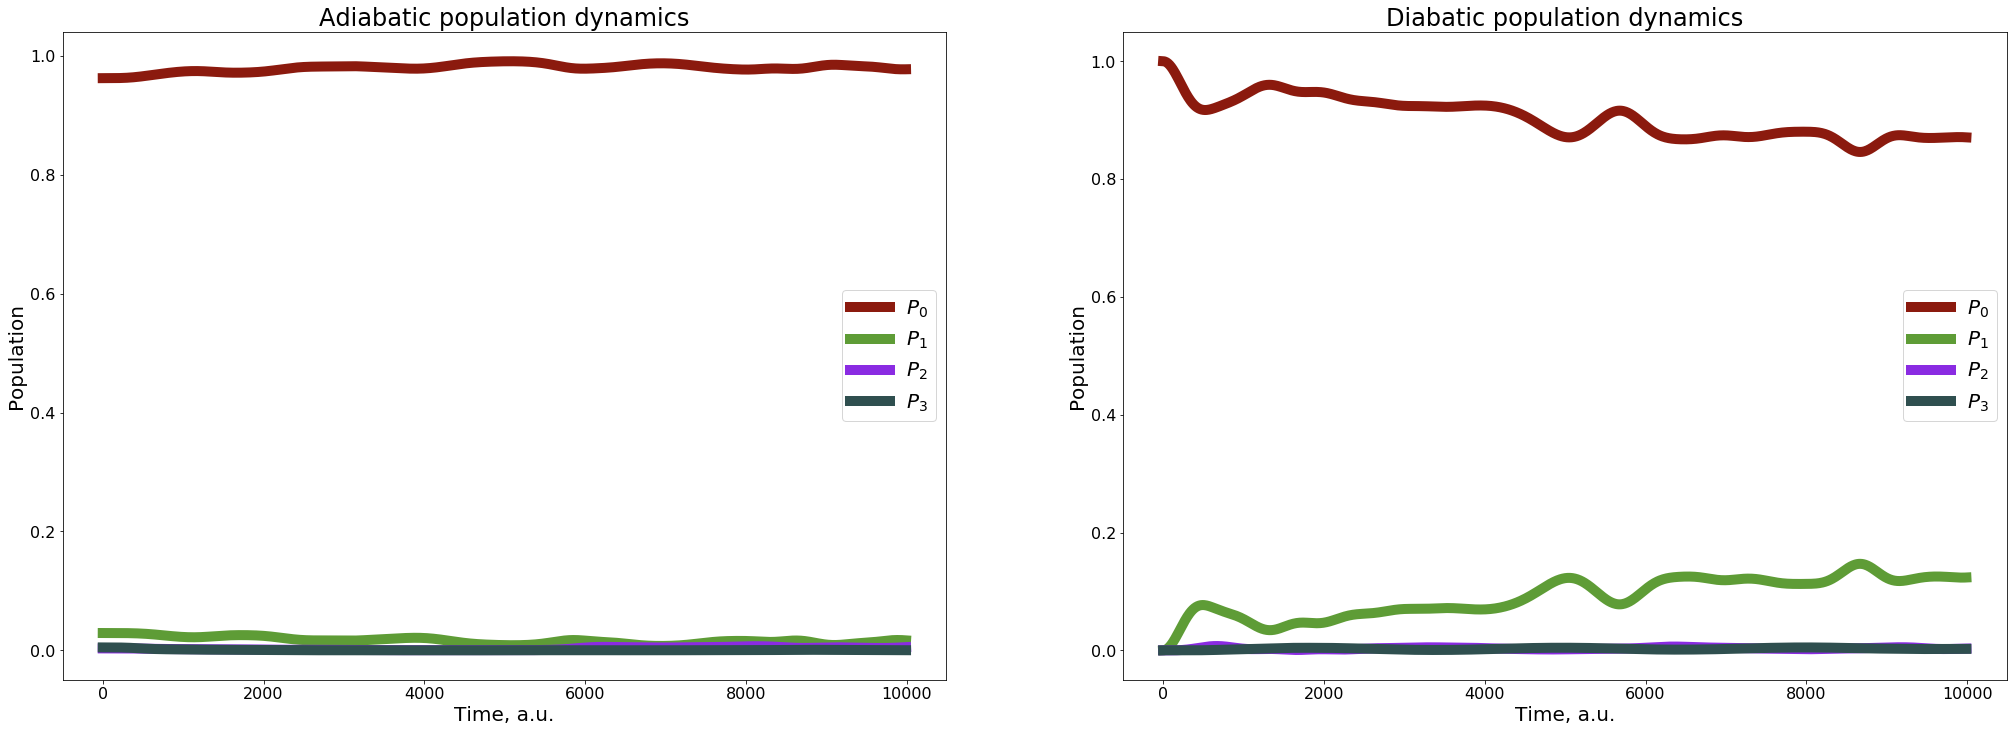

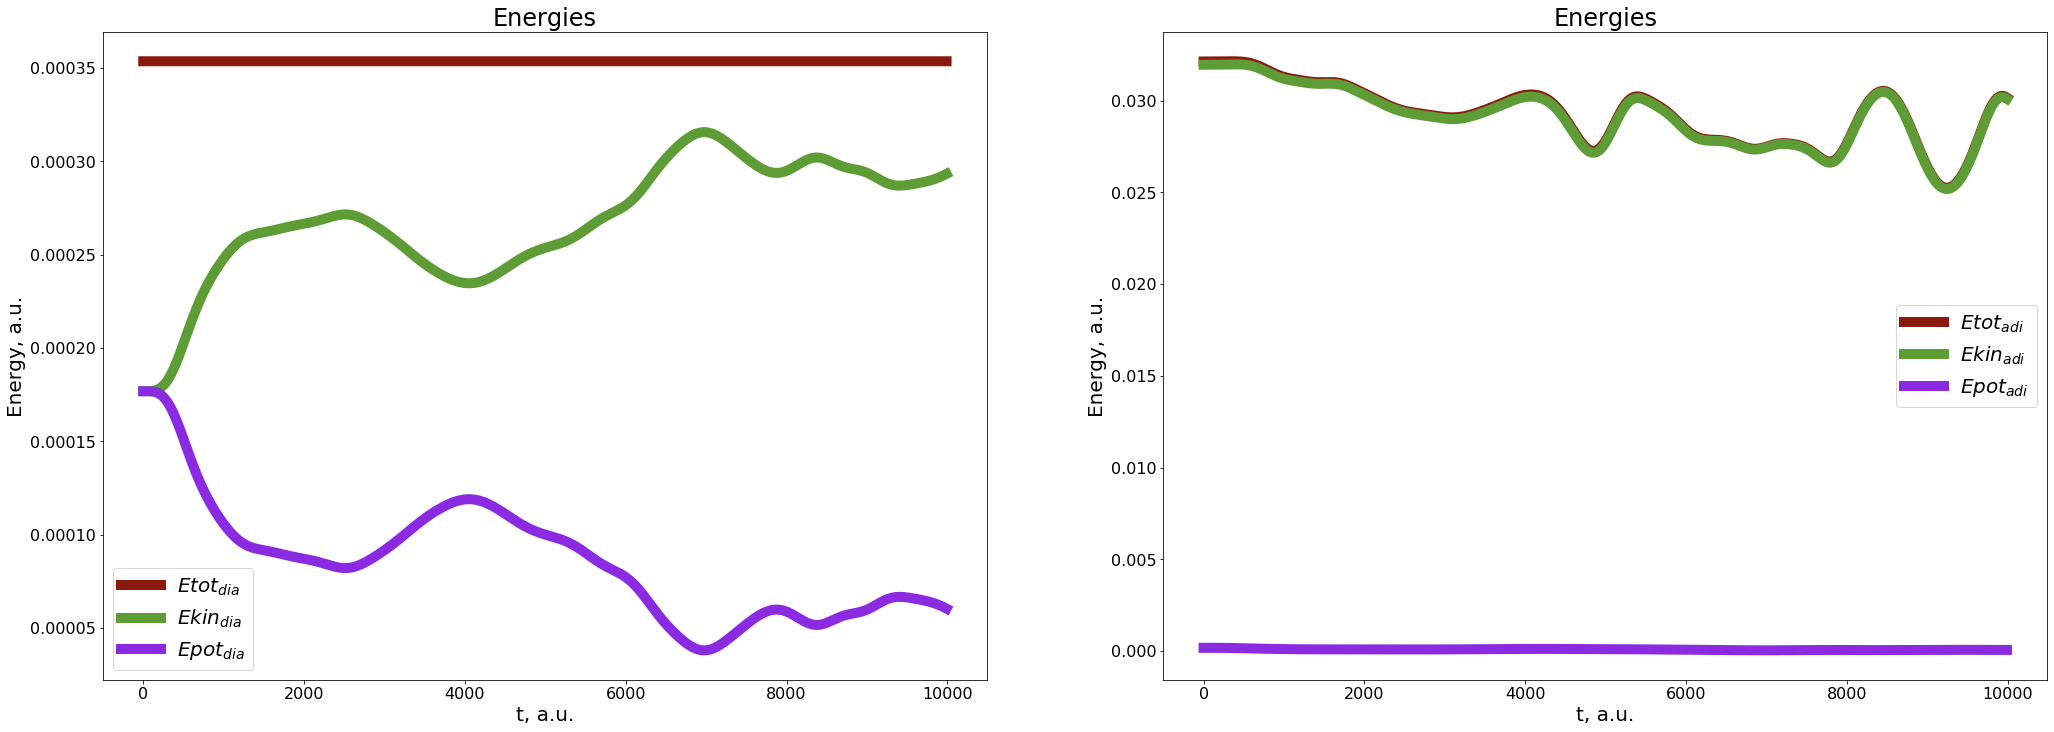

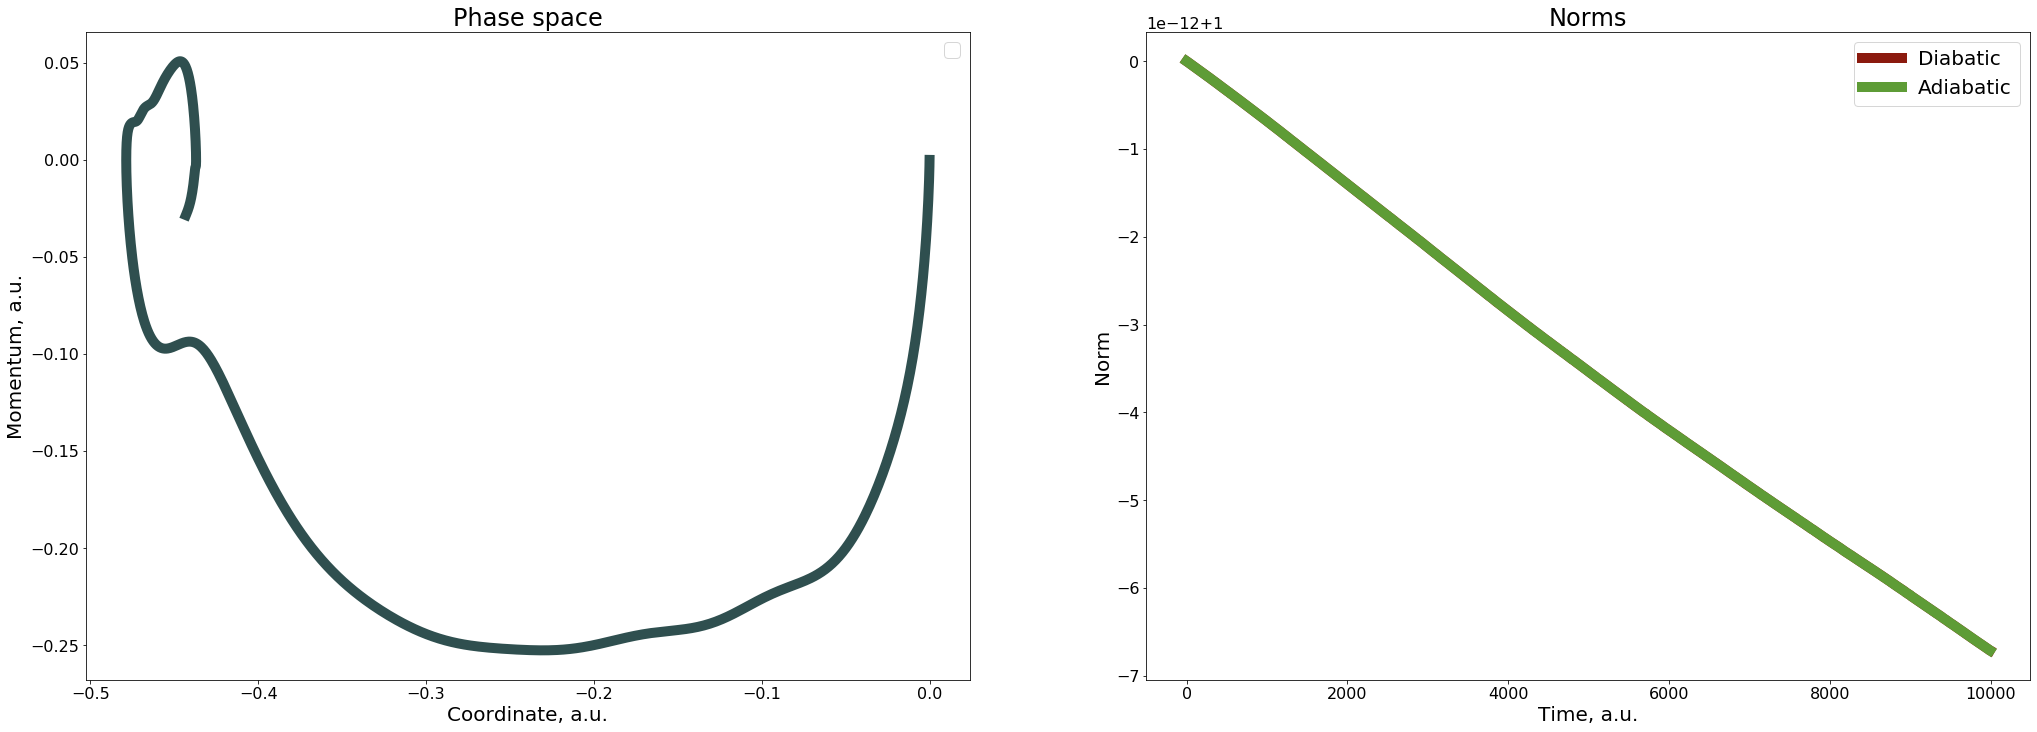

In [28]:
prefix = "Tut3-case-10"
plot_params1 = dict(plot_params)
plot_params1.update({"prefix":prefix, "which_adi_states":[0, 1, 2, 3], "which_dia_states":[0, 1, 2, 3]})
dynamics_exact.plot_hdf5(plot_params1)

### Case 11

Run calculations with the dynamical parameters  {'nsteps': 1000, 'dt': 10.0, 'progress_frequency': 0.1, 'rmin': [-15.0], 'rmax': [15.0], 'dx': [0.1], 'nstates': 4, 'x0': [-5.0], 'p0': [0.0], 'istate': [1, 0], 'masses': [2000.0], 'k': [0.001], 'integrator': 'SOFT', 'prefix': 'Tut3-case-11', 'hdf5_output_level': 2, 'compression_level': [0, 0, 0], 'use_compression': 1, 'mem_output_level': 0, 'txt_output_level': 0, 'properties_to_save': ['timestep', 'time', 'Ekin_dia', 'Ekin_adi', 'Epot_dia', 'Epot_adi', 'Etot_dia', 'Etot_adi', 'norm_dia', 'norm_adi', 'pop_dia', 'pop_adi', 'q_dia', 'q_adi', 'p_dia', 'p_adi']}
Run calculations with the model parameters  {'model': 1, 'E_n': [0.0, -0.001, -0.001, -0.001], 'x_n': [0.0, -4.0, 4.0, 4.0], 'k_n': [0.001, 0.001, 0.001, 0.001], 'V': 0.001}
Norm (dia) =  1.0000000000000002
Norm (adi) =  0.9999999999999997
Ekin (dia) =  0.0001788680585204089
Ekin (adi) =  0.00017677669529663644
Epot (dia) =  -0.0004276097214334196
Epot (adi) =  -0.00042760972143341964

/home/alexey/miniconda2/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


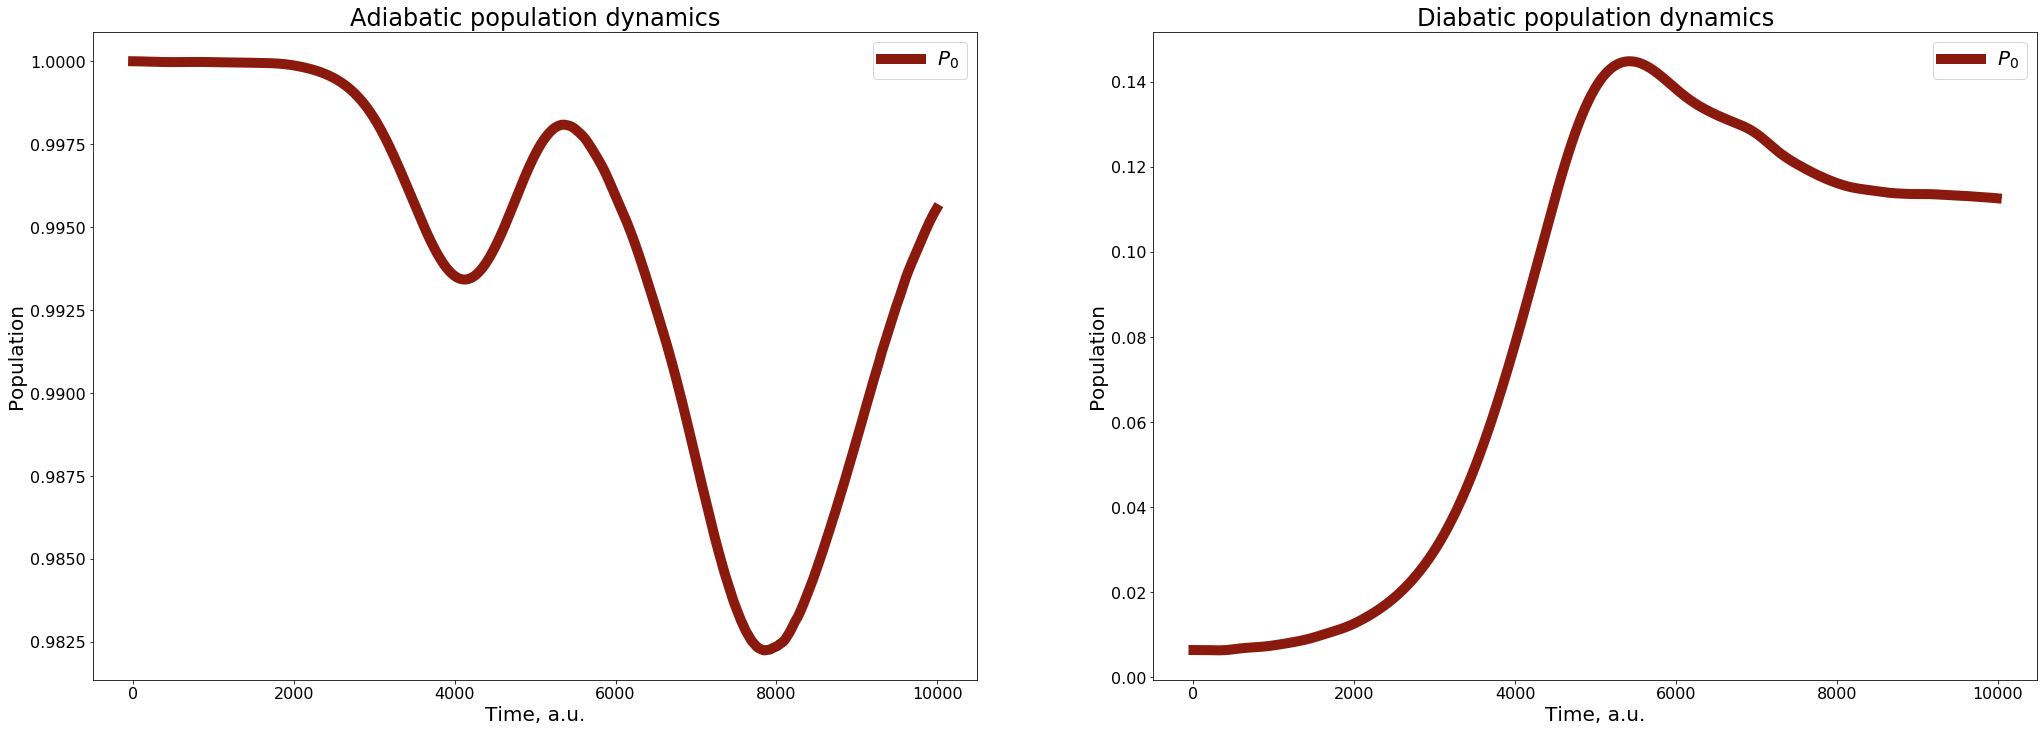

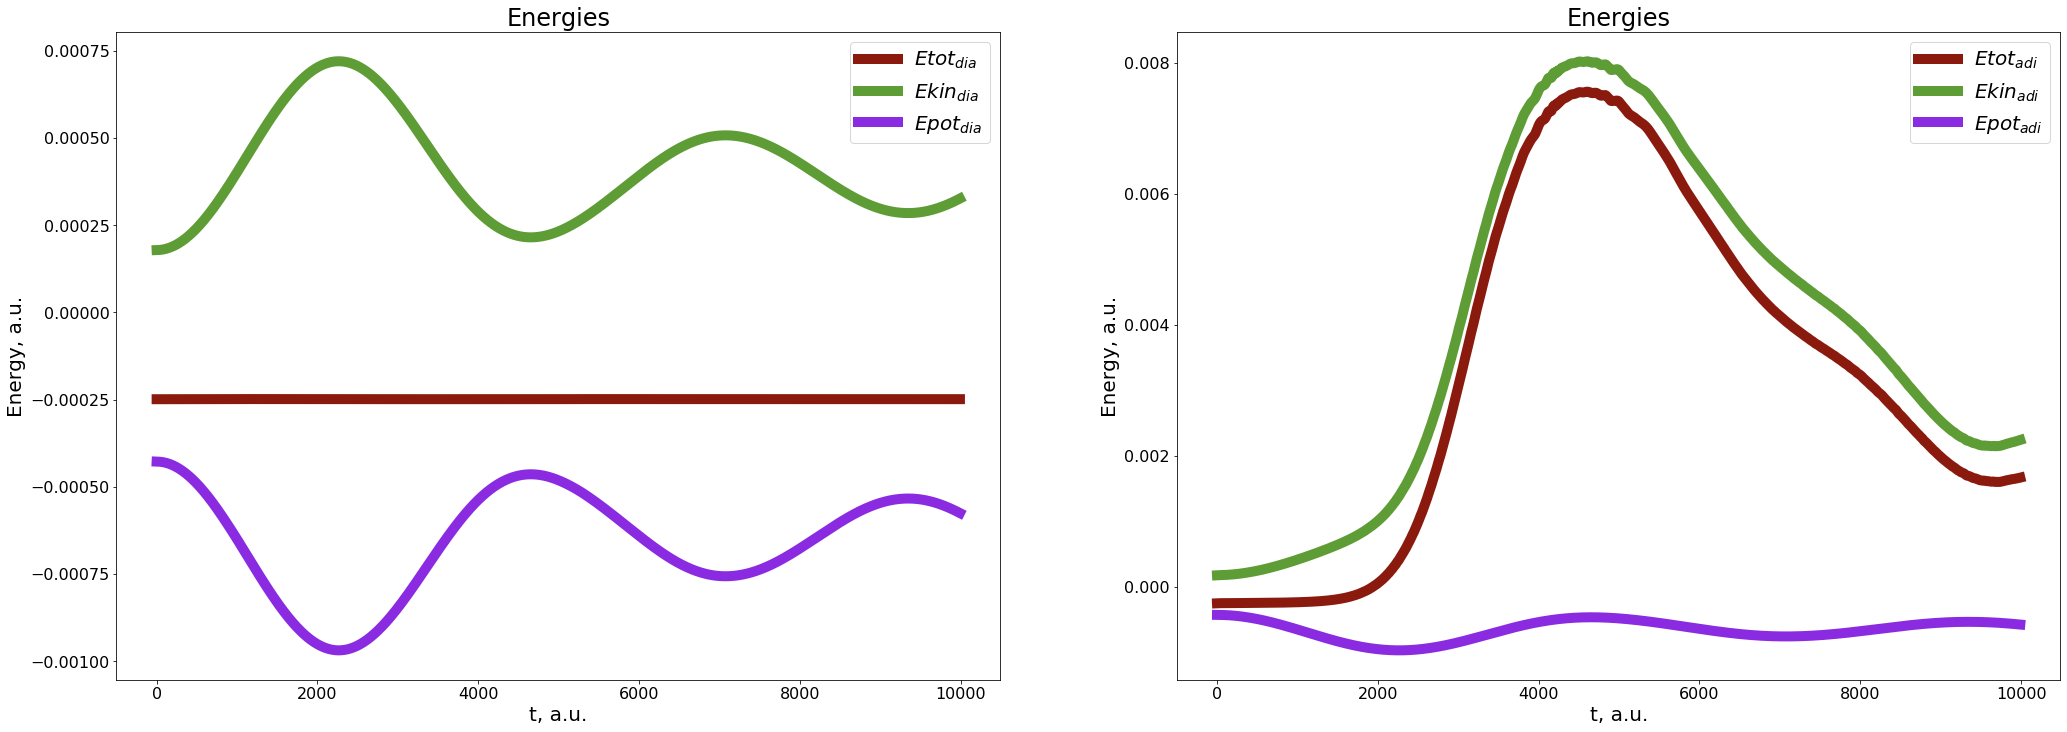

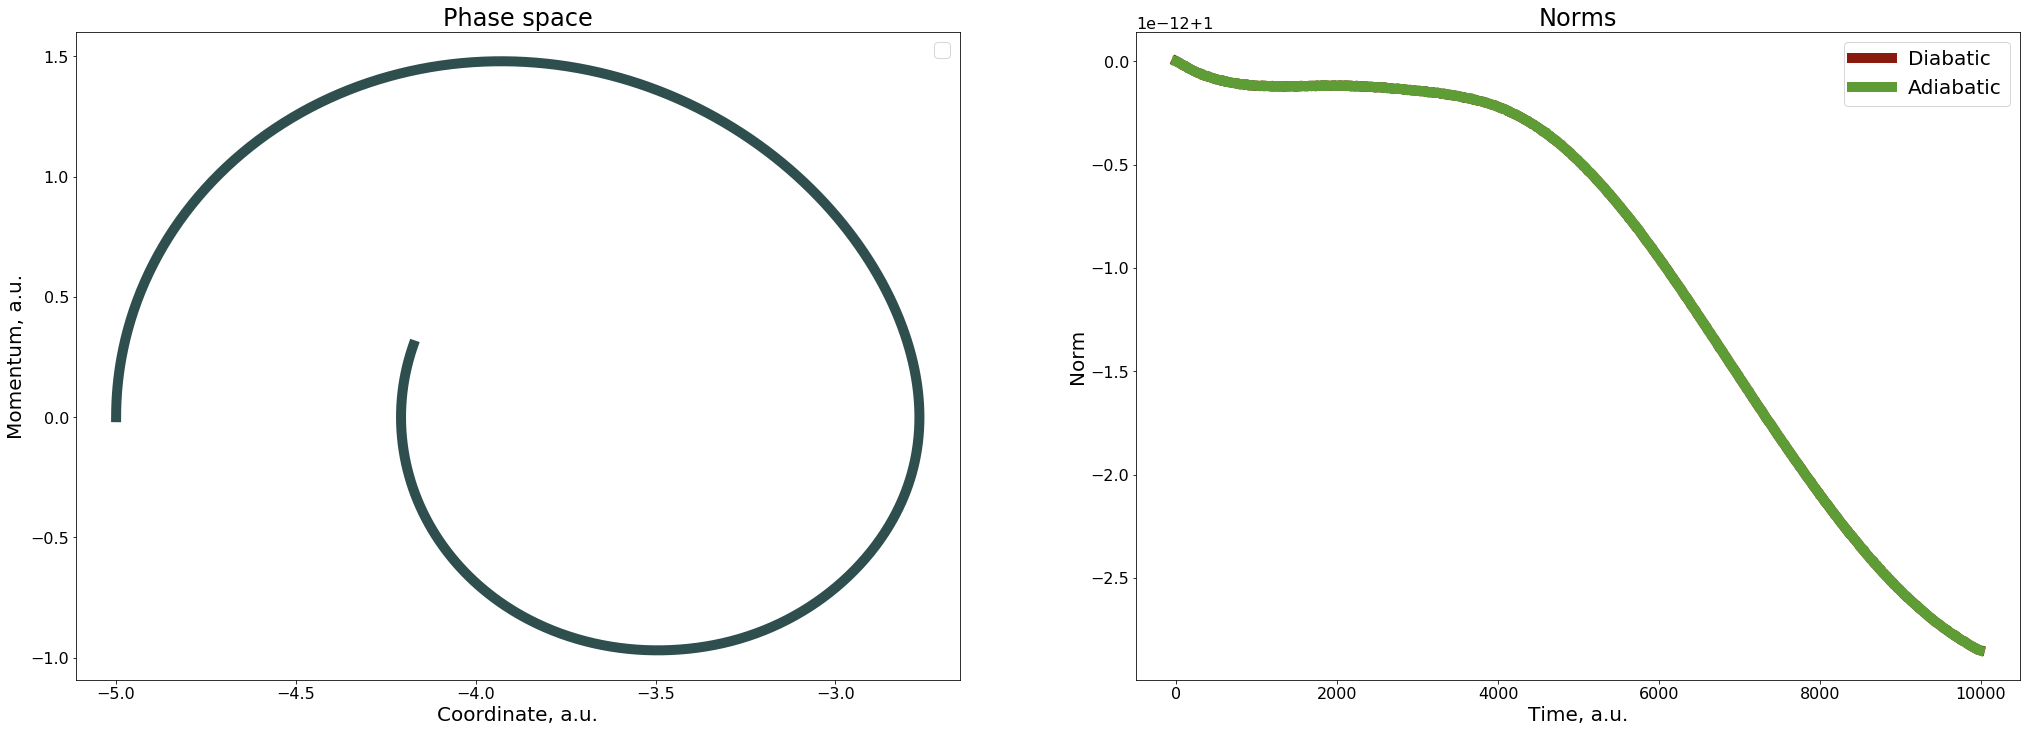

In [24]:
prefix = "Tut3-case-11"

model_params = dict(param_sets[2])
x0 = [-5.0]
istate = [1, 0]  # adiabatic state 0

run_case(prefix, model_params, x0, istate)

/home/alexey/miniconda2/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


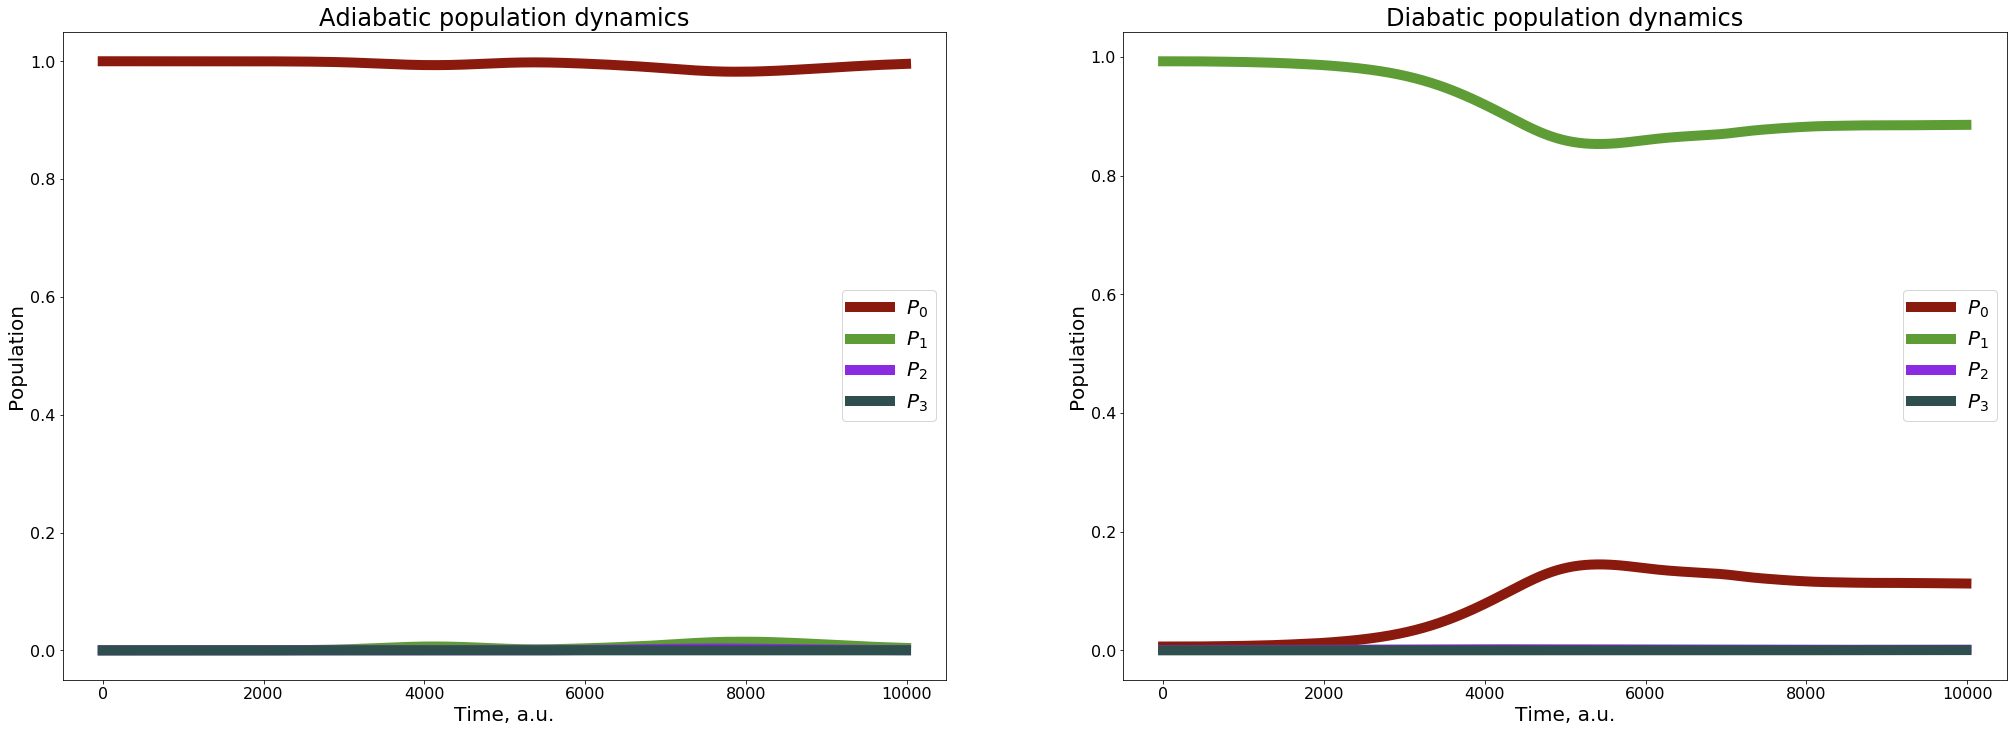

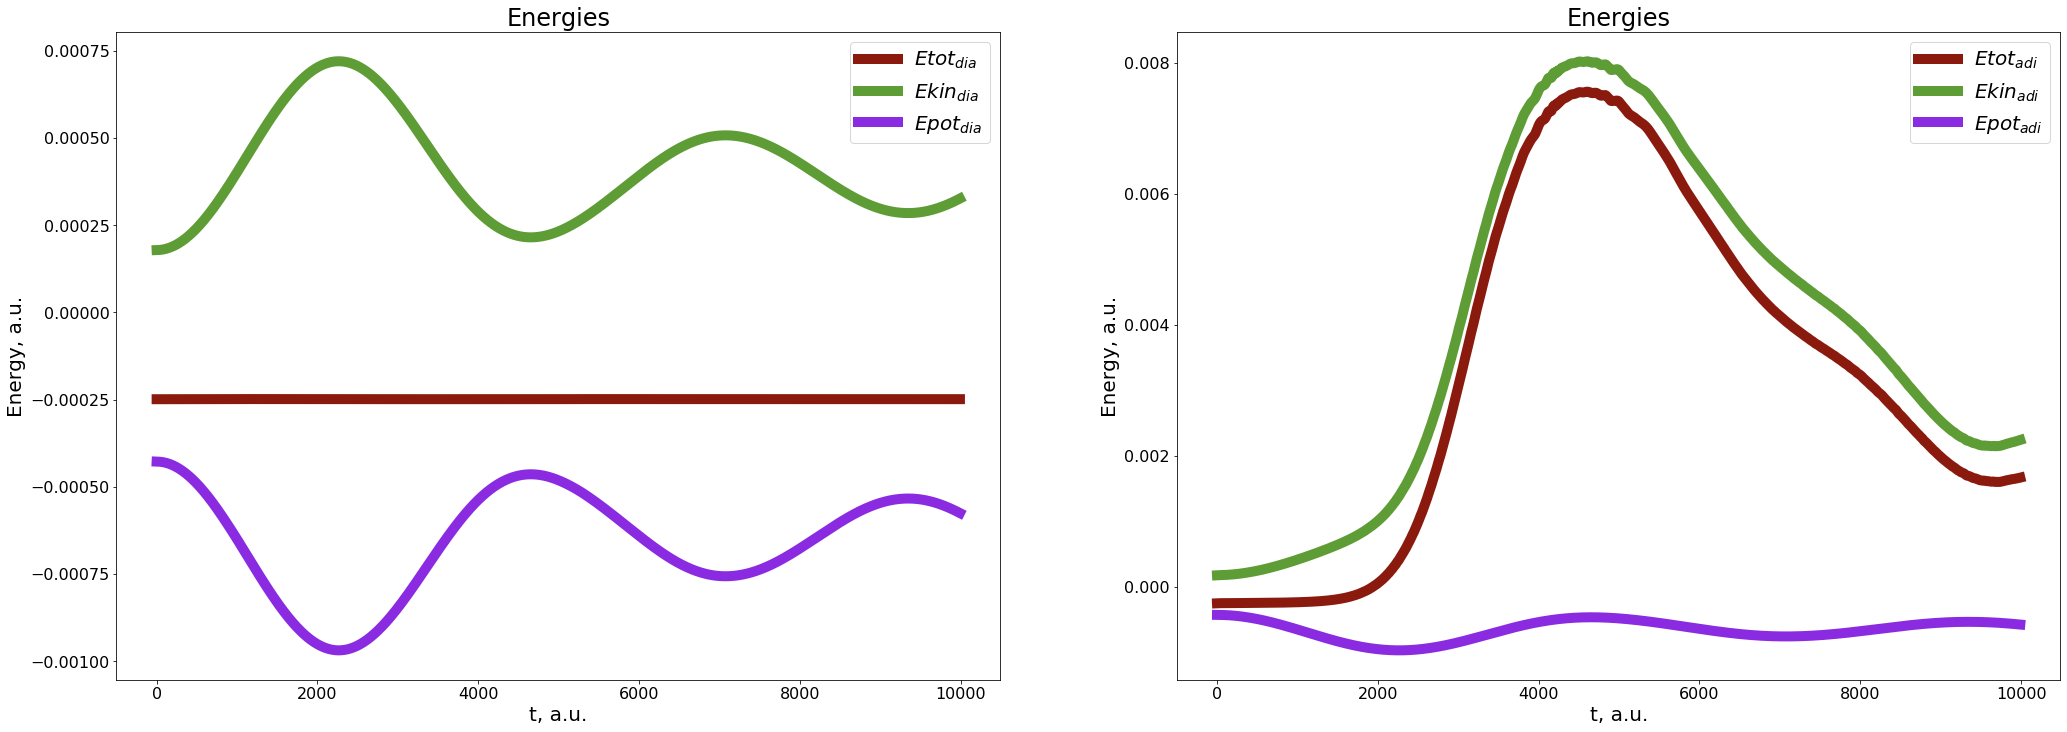

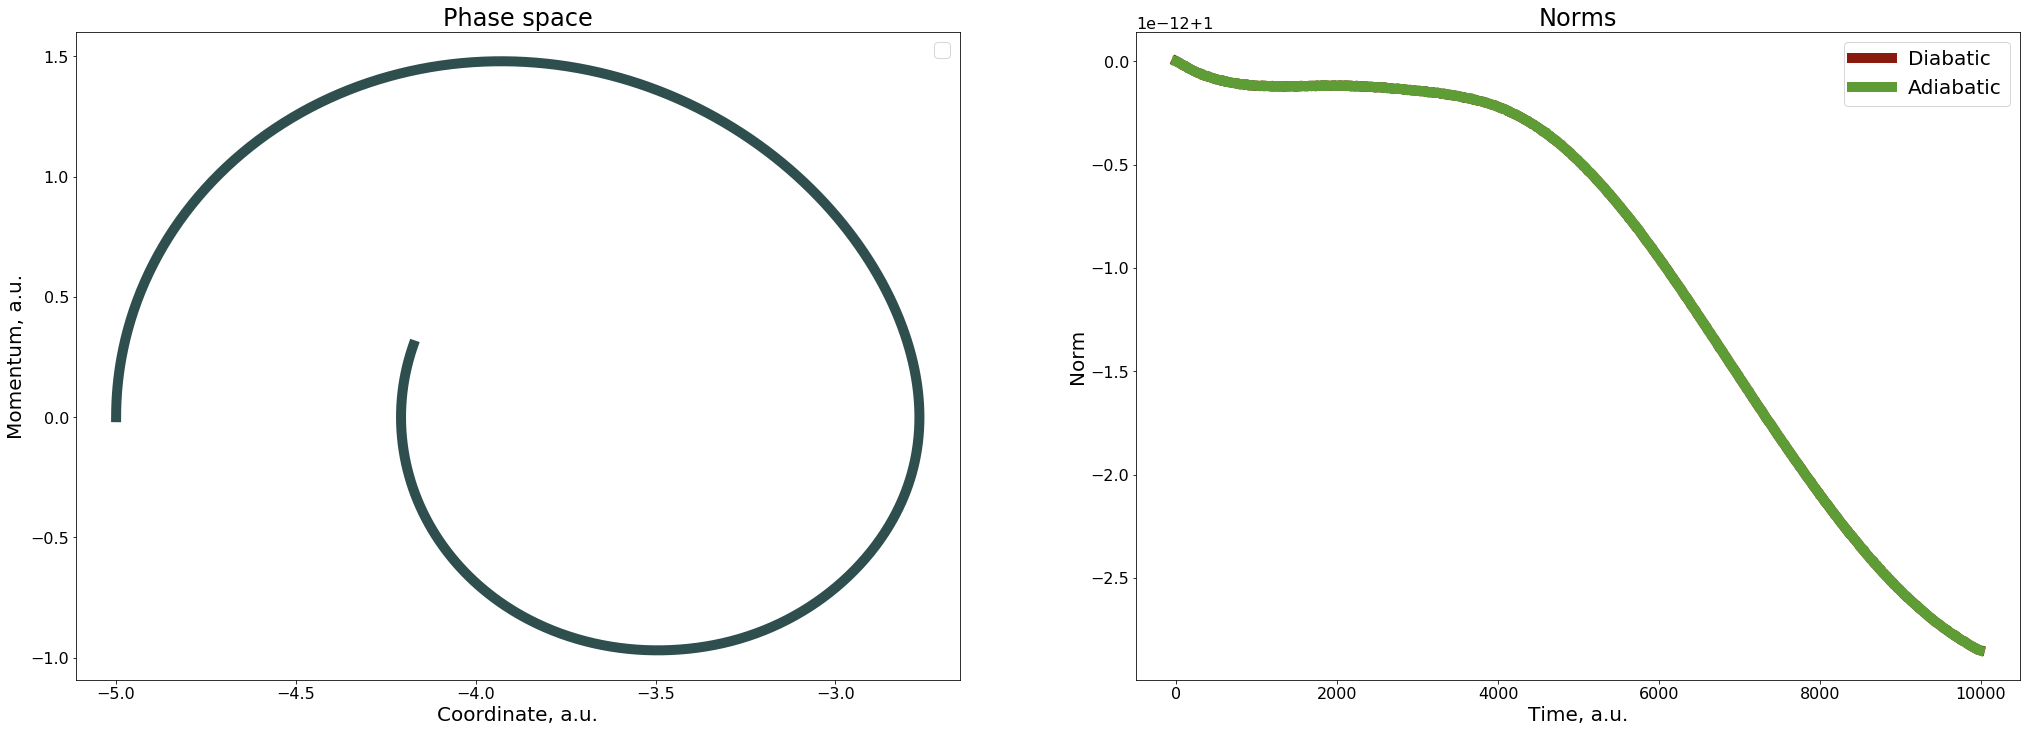

In [29]:
prefix = "Tut3-case-11"
plot_params1 = dict(plot_params)
plot_params1.update({"prefix":prefix, "which_adi_states":[0, 1, 2, 3], "which_dia_states":[0, 1, 2, 3]})
dynamics_exact.plot_hdf5(plot_params1)

### Case 12

Run calculations with the dynamical parameters  {'nsteps': 1000, 'dt': 10.0, 'progress_frequency': 0.1, 'rmin': [-15.0], 'rmax': [15.0], 'dx': [0.1], 'nstates': 4, 'x0': [-5.0], 'p0': [0.0], 'istate': [0, 0], 'masses': [2000.0], 'k': [0.001], 'integrator': 'SOFT', 'prefix': 'Tut3-case-12', 'hdf5_output_level': 2, 'compression_level': [0, 0, 0], 'use_compression': 1, 'mem_output_level': 0, 'txt_output_level': 0, 'properties_to_save': ['timestep', 'time', 'Ekin_dia', 'Ekin_adi', 'Epot_dia', 'Epot_adi', 'Etot_dia', 'Etot_adi', 'norm_dia', 'norm_adi', 'pop_dia', 'pop_adi', 'q_dia', 'q_adi', 'p_dia', 'p_adi']}
Run calculations with the model parameters  {'model': 1, 'E_n': [0.0, -0.001, -0.001, -0.001], 'x_n': [0.0, -4.0, 4.0, 4.0], 'k_n': [0.001, 0.001, 0.001, 0.001], 'V': 0.001}
Norm (dia) =  0.9999999999999997
Norm (adi) =  0.9999999999999999
Ekin (dia) =  0.00017677669529663644
Ekin (adi) =  0.0001789227364571172
Epot (dia) =  0.012676776695296632
Epot (adi) =  0.012676776695296628
 ste

/home/alexey/miniconda2/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


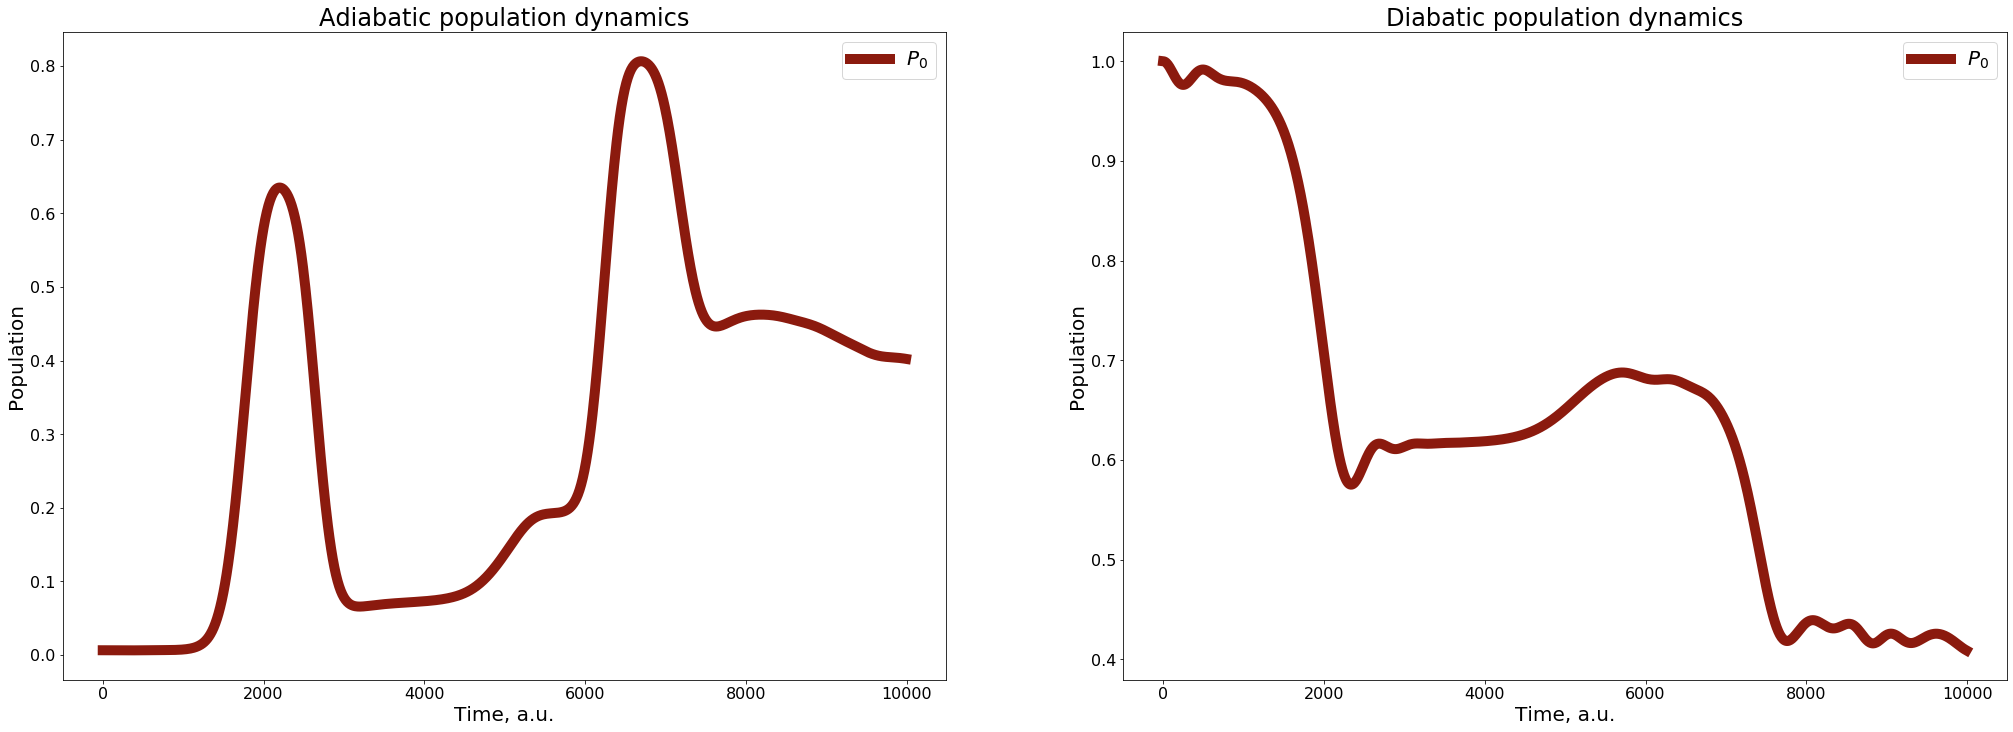

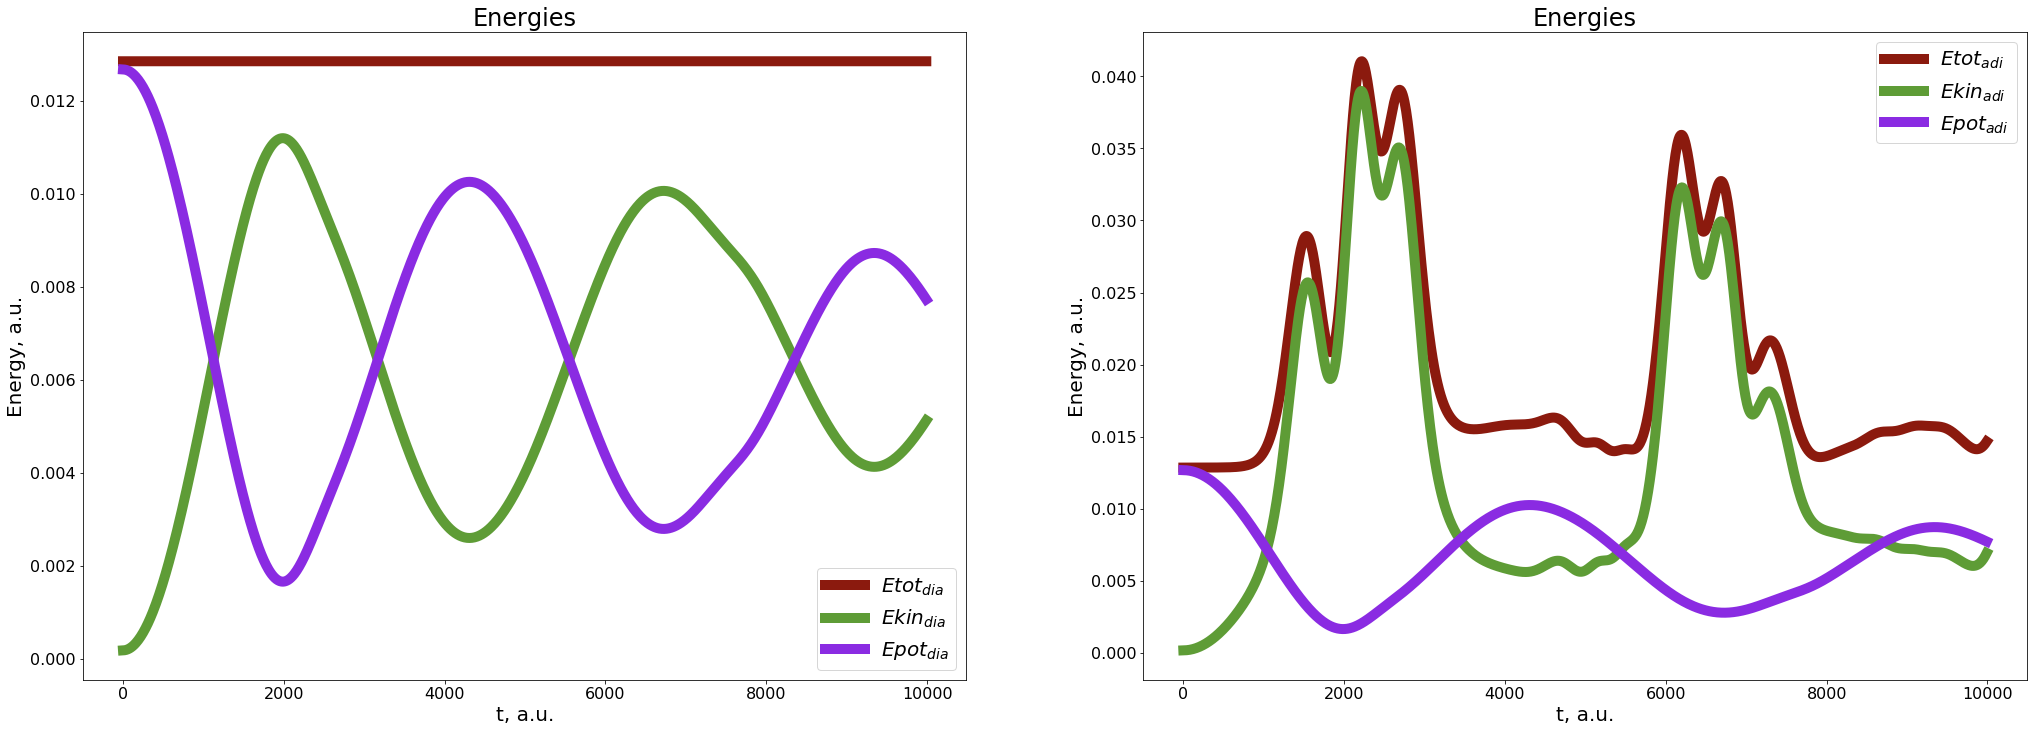

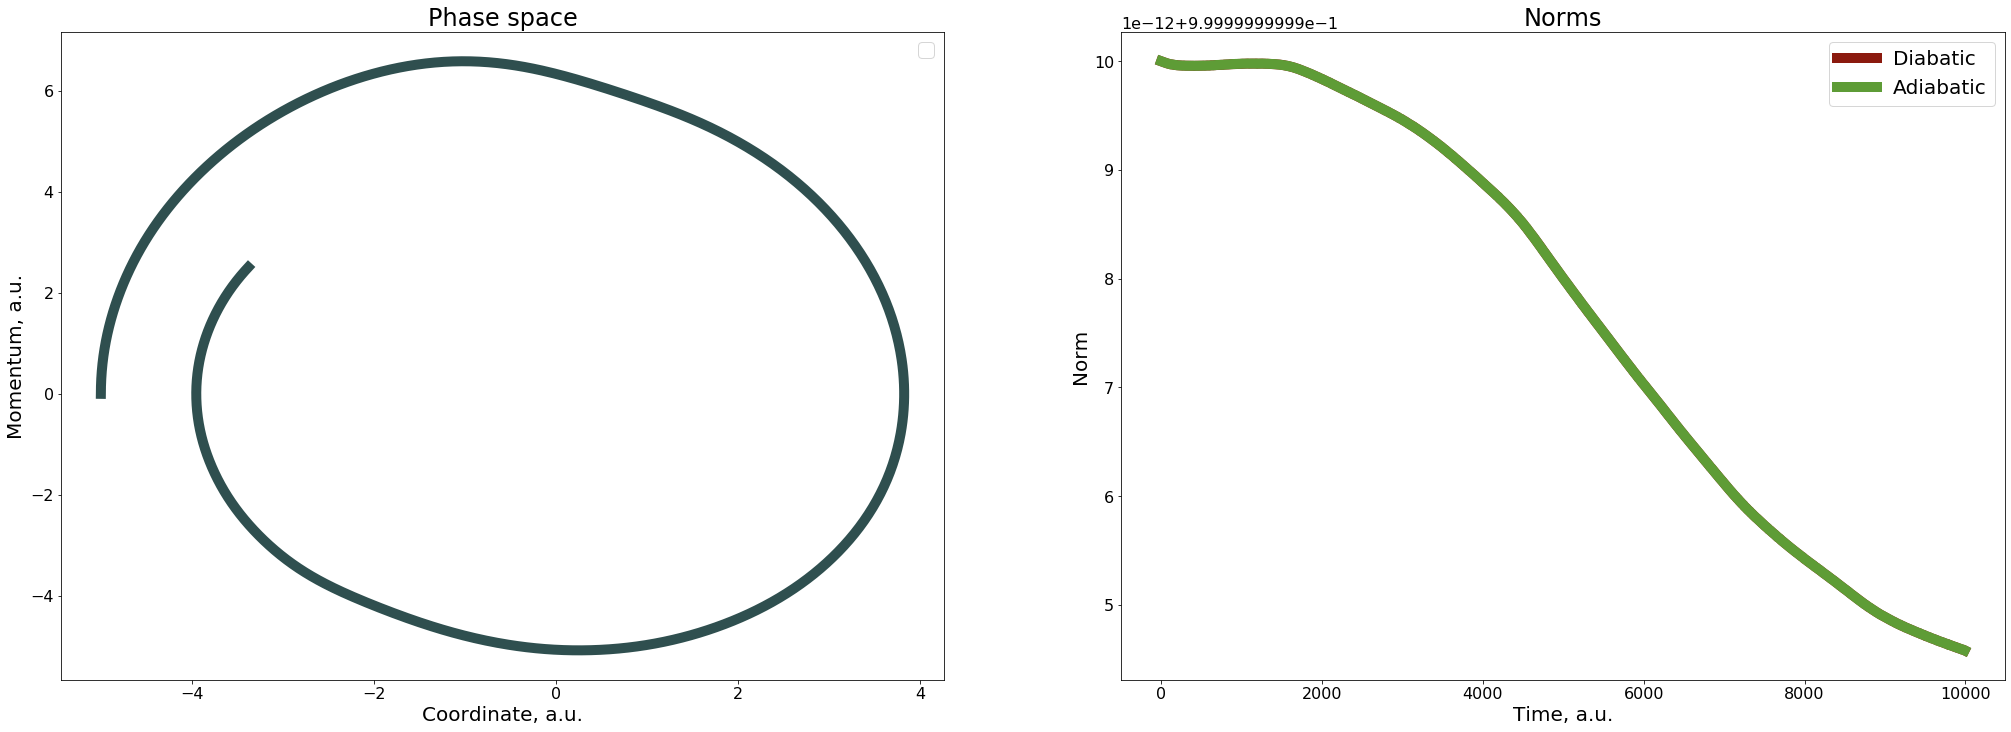

In [25]:
prefix = "Tut3-case-12"

model_params = dict(param_sets[2])
x0 = [-5.0]
istate = [0, 0]  # adiabatic state 0

run_case(prefix, model_params, x0, istate)

/home/alexey/miniconda2/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


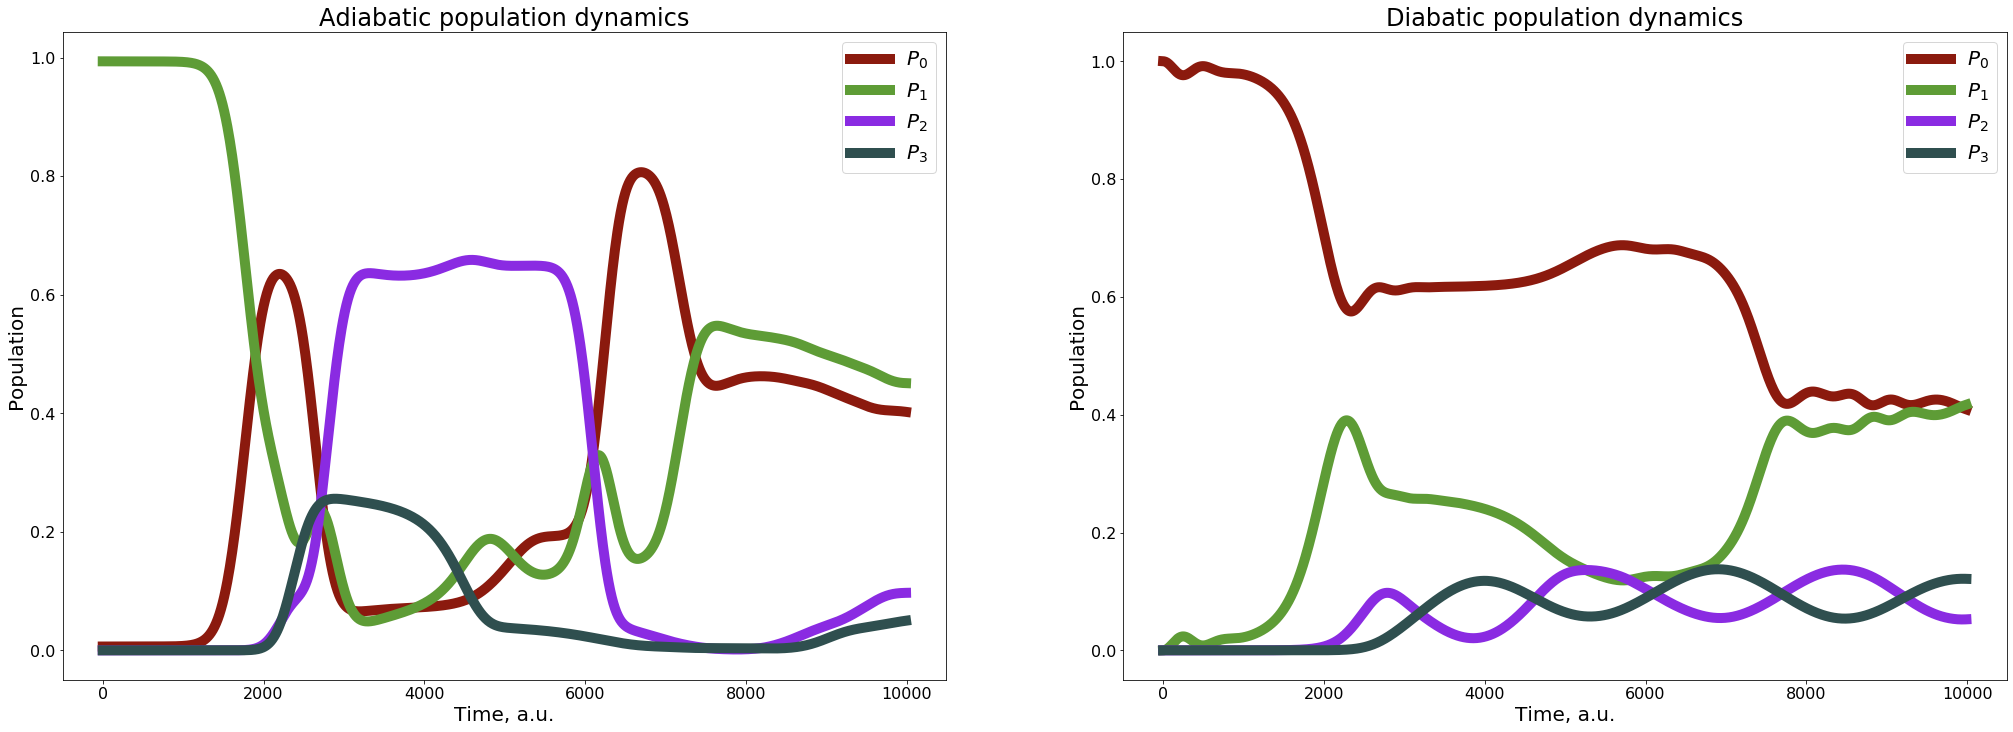

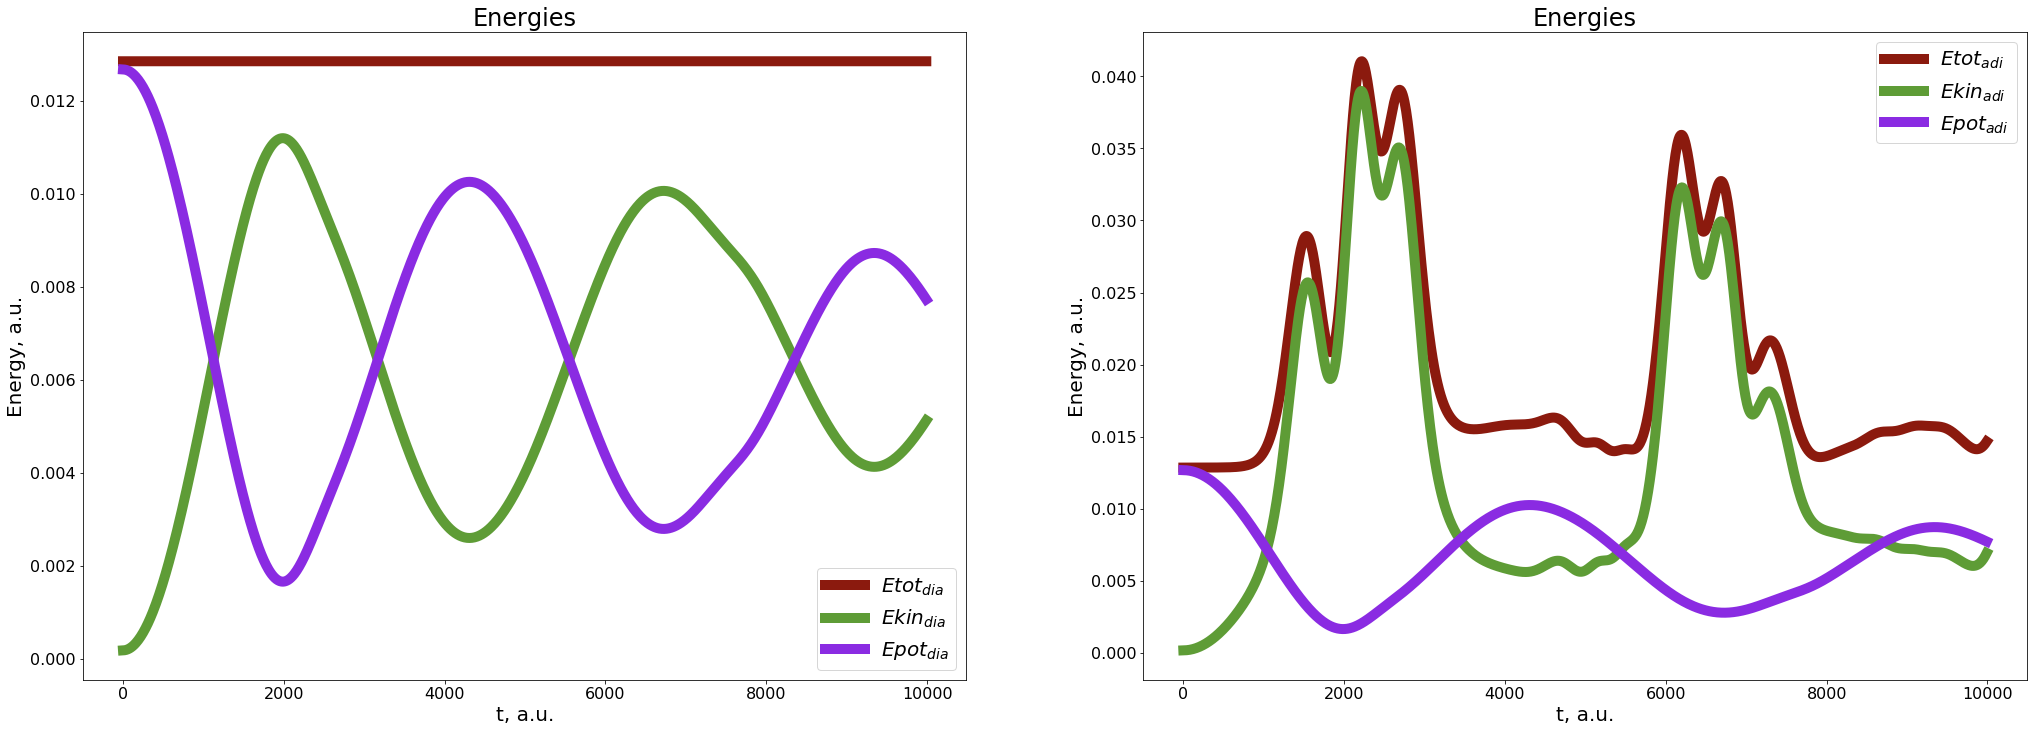

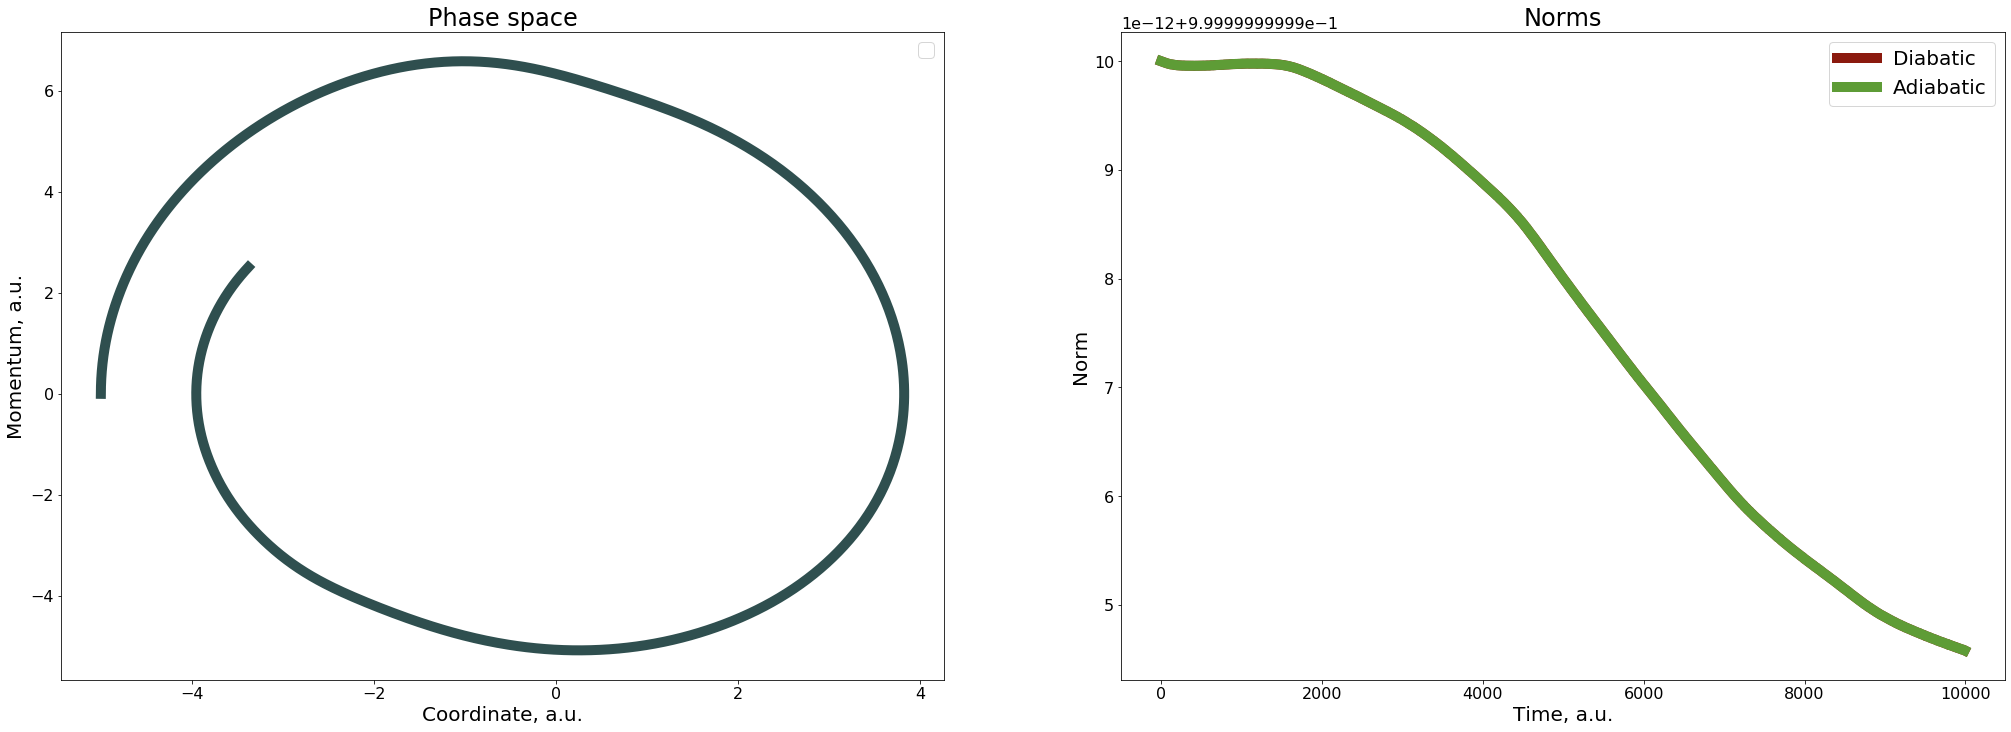

In [30]:
prefix = "Tut3-case-12"
plot_params1 = dict(plot_params)
plot_params1.update({"prefix":prefix, "which_adi_states":[0, 1, 2, 3], "which_dia_states":[0, 1, 2, 3]})
dynamics_exact.plot_hdf5(plot_params1)